## summary

* 2.5d segmentation
    *  segmentation_models_pytorch 
    *  Unet
* use only 6 slices in the middle
* slide inference

In [1]:

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, log_loss
import pickle
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
import warnings
import sys
import pandas as pd
import os
import gc
import sys
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter
import cv2

import scipy as sp
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from functools import partial

import argparse
import importlib
import torch
import torch.nn as nn
from torch.optim import Adam, SGD, AdamW

import torch
import torch.nn as nn
import torch.nn.functional as F
from functools import partial


import datetime

In [2]:
# sys.path.append('/kaggle/input/pretrainedmodels/pretrainedmodels-0.7.4')
# sys.path.append('/kaggle/input/efficientnet-pytorch/EfficientNet-PyTorch-master')
# sys.path.append('/kaggle/input/timm-pytorch-image-models/pytorch-image-models-master')
# sys.path.append('/kaggle/input/segmentation-models-pytorch/segmentation_models.pytorch-master')

In [3]:
import sys

sys.path.append("/home/viktor/Documents/kaggle/vesuvius-challenge/experiments/2.5d-segmentaion-baseline-[training]/exp-5-resnet34/resnet34-fold-1/resnet3d")
from resnet3d import generate_model

In [4]:
import segmentation_models_pytorch as smp

In [5]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

## config

In [6]:
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2

class CFG:
    # ============== comp exp name =============
    comp_name = 'vesuvius'

    # comp_dir_path = './'
    comp_dir_path = '/home/viktor/Documents/kaggle/vesuvius-challenge/kaggle-data/'
    comp_folder_name = 'vesuvius-challenge-ink-detection'
    # comp_dataset_path = f'{comp_dir_path}datasets/{comp_folder_name}/'
    comp_dataset_path = f'{comp_dir_path}{comp_folder_name}/'
    
    exp_name = 'vesuvius_2d_slide_exp002'

    # ============== pred target =============
    target_size = 1

    # ============== model cfg =============
    model_name = 'Unet'
    # backbone = 'efficientnet-b0'
    # backbone = 'se_resnext50_32x4d'
    backbone = 'resnet3d'

    in_chans = 32 # 65
    # ============== training cfg =============
    size = 224
    tile_size = 224
    stride = tile_size // 2

    train_batch_size = 32 # 32
    valid_batch_size = train_batch_size
    use_amp = True

    scheduler = 'GradualWarmupSchedulerV2'
    # scheduler = 'CosineAnnealingLR'
    epochs = 200 # 30

    # adamW warmupあり
    warmup_factor = 10
    # lr = 1e-4 / wsegarmup_factor
    lr = 1e-4 # / warmup_factor

    # ============== fold =============
    valid_id = 1

    # objective_cv = 'binary'  # 'binary', 'multiclass', 'regression'
    metric_direction = 'maximize'  # maximize, 'minimize'
    # metrics = 'dice_coef'

    # ============== fixed =============
    pretrained = True
    inf_weight = 'best'  # 'best'

    min_lr = 1e-6
    weight_decay = 1e-6
    max_grad_norm = 1000

    print_freq = 50
    num_workers = 4

    seed = 42
    
    # ==================== SWA ====================
    
    swa_start = 75
    swa_freq = 1
    swa_lr = 0.05

    # ============== set dataset path =============
    print('set dataset path')

    outputs_path = f'./{comp_name}/{exp_name}/'

    submission_dir = outputs_path + 'submissions/'
    submission_path = submission_dir + f'submission_{exp_name}.csv'

    model_dir = outputs_path + \
        f'{comp_name}-models/'

    figures_dir = outputs_path + 'figures/'

    log_dir = outputs_path + 'logs/'
    log_path = log_dir + f'{exp_name}.txt'

    # ============== augmentation =============
    train_aug_list = [
        # A.RandomResizedCrop(
        #     size, size, scale=(0.85, 1.0)),
        A.Resize(size, size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.75),
        A.ShiftScaleRotate(p=0.75),
        A.Rotate(limit=90, p=0.9), 
        A.OneOf([
                A.GaussNoise(var_limit=[10, 50]),
                A.GaussianBlur(),
                A.MotionBlur(),
                ], p=0.4),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        A.CoarseDropout(max_holes=1, max_width=int(size * 0.1), max_height=int(size * 0.1), 
                        mask_fill_value=0, p=0.5),
        # A.Cutout(max_h_size=int(size * 0.6),
        #          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]


set dataset path


## helper

In [7]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [8]:
def init_logger(log_file):
    from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

def set_seed(seed=None, cudnn_deterministic=True):
    if seed is None:
        seed = 42

    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = cudnn_deterministic
    torch.backends.cudnn.benchmark = False

In [9]:
def make_dirs(cfg):
    for dir in [cfg.model_dir, cfg.figures_dir, cfg.submission_dir, cfg.log_dir]:
        os.makedirs(dir, exist_ok=True)

In [10]:
def cfg_init(cfg, mode='train'):
    set_seed(cfg.seed)
    # set_env_name()
    # set_dataset_path(cfg)

    if mode == 'train':
        make_dirs(cfg)

In [11]:
cfg_init(CFG)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Logger = init_logger(log_file=CFG.log_path)

Logger.info('\n\n-------- exp_info -----------------')
# Logger.info(datetime.datetime.now().strftime('%Y年%m月%d日 %H:%M:%S'))



-------- exp_info -----------------


## image, mask

In [12]:
def read_image_mask(fragment_id):
    
    images = []

    # idxs = range(65)
    mid = 65 // 2
    start = mid - CFG.in_chans // 2
    end = mid + CFG.in_chans // 2
    idxs = range(start, end)

    for i in tqdm(idxs):
        
        image = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/surface_volume/{i:02}.tif", 0)

        pad0 = (CFG.tile_size - image.shape[0] % CFG.tile_size)
        pad1 = (CFG.tile_size - image.shape[1] % CFG.tile_size)

        image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)

        images.append(image)
    images = np.stack(images, axis=2)

    mask = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
    mask = np.pad(mask, [(0, pad0), (0, pad1)], constant_values=0)

    mask = mask.astype('float32')
    mask /= 255.0
    
    return images, mask

In [13]:
# def read_image_mask(fragment_id):
    
#     images = []
    
    
#     # take CFG.in_chans random idxs
#     idxs = np.random.choice(range(65), CFG.in_chans, replace=False)

#     for i in tqdm(idxs):
        
#         img_path = CFG.comp_dataset_path + f"train/{fragment_id}/surface_volume/{i:02}.tif"
#         print(img_path)
        
#         image = cv2.imread(img_path, 0)

#         pad0 = (CFG.tile_size - image.shape[0] % CFG.tile_size)
#         pad1 = (CFG.tile_size - image.shape[1] % CFG.tile_size)

#         image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)

#         images.append(image)
#     images = np.stack(images, axis=2)

#     mask = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
#     mask = np.pad(mask, [(0, pad0), (0, pad1)], constant_values=0)

#     mask = mask.astype('float32')
#     mask /= 255.0
    
#     return images, mask

In [14]:
def get_train_valid_dataset():
    train_images = []
    train_masks = []

    valid_images = []
    valid_masks = []
    valid_xyxys = []

    for fragment_id in range(1, 4):

        image, mask = read_image_mask(fragment_id)

        x1_list = list(range(0, image.shape[1]-CFG.tile_size+1, CFG.stride))
        y1_list = list(range(0, image.shape[0]-CFG.tile_size+1, CFG.stride))

        for y1 in y1_list:
            for x1 in x1_list:
                y2 = y1 + CFG.tile_size
                x2 = x1 + CFG.tile_size
                # xyxys.append((x1, y1, x2, y2))
        
                image_sub = image[y1:y2, x1:x2]
                mask_sub = mask[y1:y2, x1:x2, None]
                
                # if there is less then 10% of ink in the tile, skip it
                if np.sum(mask_sub) < 0.2 * CFG.tile_size * CFG.tile_size:
                    continue
                
                if fragment_id == CFG.valid_id:
                    valid_images.append(image_sub)
                    valid_masks.append(mask_sub)

                    valid_xyxys.append([x1, y1, x2, y2])
                else:
                    train_images.append(image_sub)
                    train_masks.append(mask_sub)

    return train_images, train_masks, valid_images, valid_masks, valid_xyxys

In [15]:
train_images, train_masks, valid_images, valid_masks, valid_xyxys = get_train_valid_dataset()

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

In [16]:
valid_xyxys = np.stack(valid_xyxys)

## dataset

In [17]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

In [18]:
def get_transforms(data, cfg):
    if data == 'train':
        aug = A.Compose(cfg.train_aug_list)
    elif data == 'valid':
        aug = A.Compose(cfg.valid_aug_list)

    # print(aug)
    return aug

class CustomDataset(Dataset):
    def __init__(self, images, cfg, labels=None, transform=None):
        self.images = images
        self.cfg = cfg
        self.labels = labels
        self.transform = transform

    def __len__(self):
        # return len(self.df)
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            data = self.transform(image=image, mask=label)
            image = data['image']
            label = data['mask']
            
        # image = (image - 0.45)/0.225
        
        
        return image, label

In [19]:

train_dataset = CustomDataset(
    train_images, CFG, labels=train_masks, transform=get_transforms(data='train', cfg=CFG))
valid_dataset = CustomDataset(
    valid_images, CFG, labels=valid_masks, transform=get_transforms(data='valid', cfg=CFG))

train_loader = DataLoader(train_dataset,
                          batch_size=CFG.train_batch_size,
                          shuffle=True,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True
                          )
valid_loader = DataLoader(valid_dataset,
                          batch_size=CFG.valid_batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)


In [20]:
train_dataset[0][0].max(), valid_dataset[0][0].max()

(tensor(1.), tensor(1.))

In [21]:
images=train_dataset[0][0].numpy()
print(images.shape)
np.min(images), np.max(images)

(16, 224, 224)


(0.0, 1.0)

In [22]:
valid_dataset[0][0].min(), valid_dataset[0][0].max()

(tensor(0.), tensor(1.))

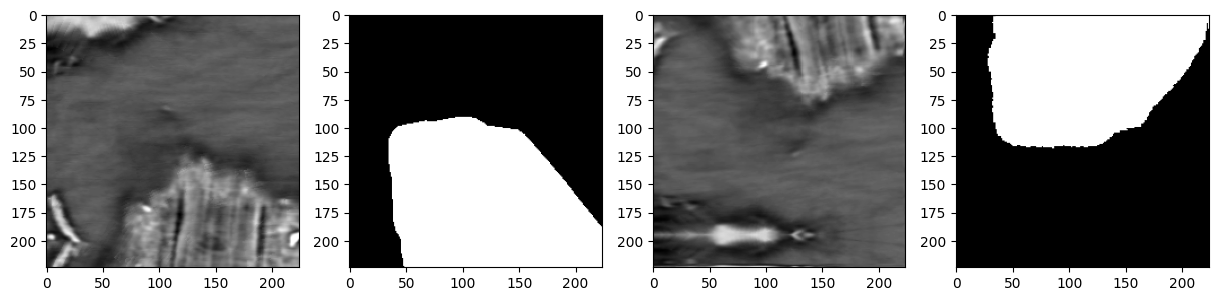

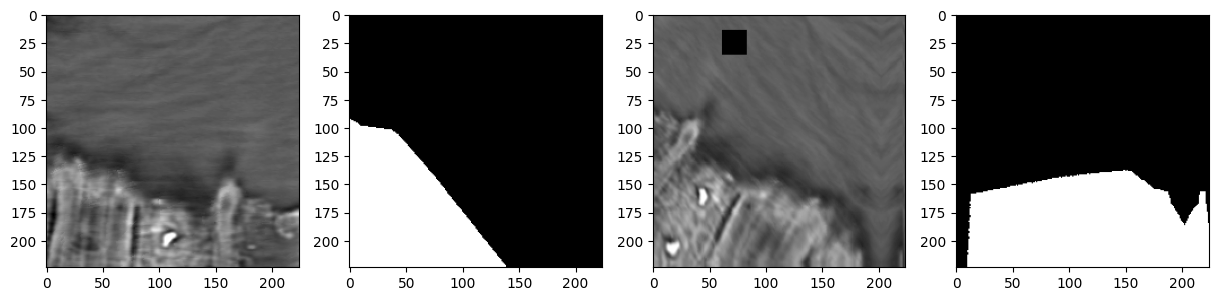

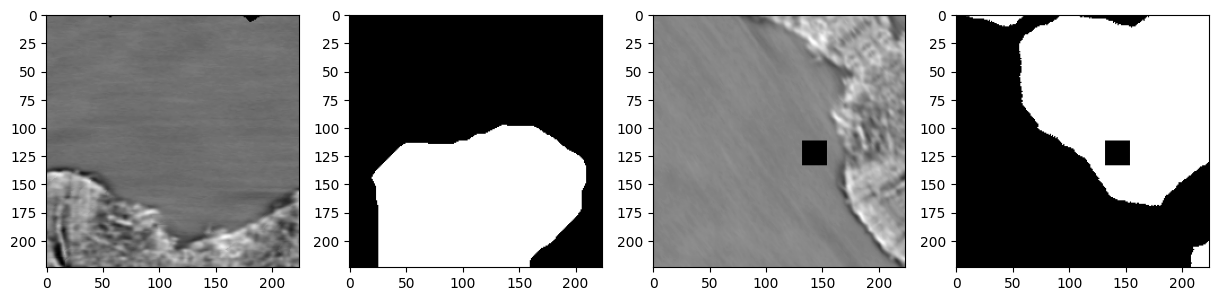

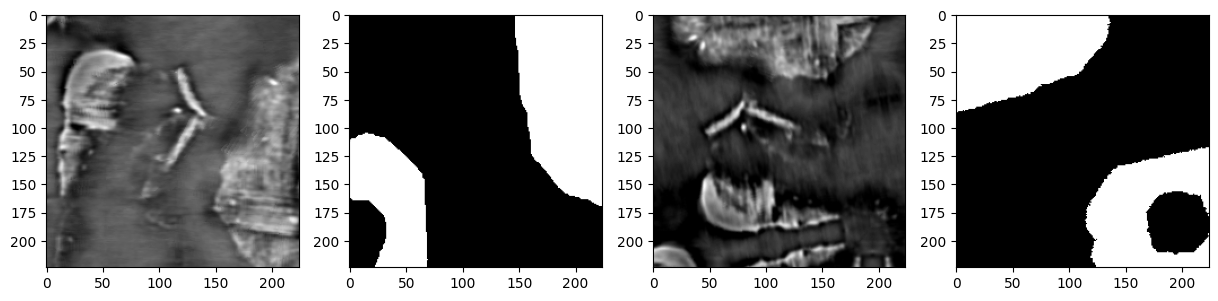

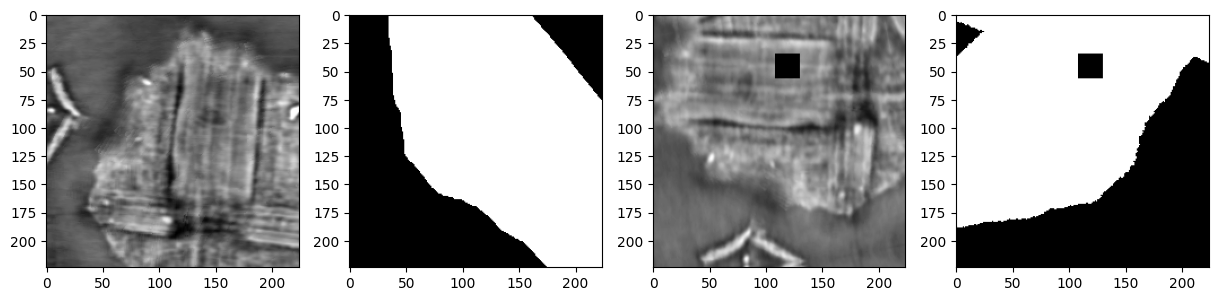

In [23]:

plot_dataset = CustomDataset(
    train_images, CFG, labels=train_masks)

transform = CFG.train_aug_list
transform = A.Compose(
    [t for t in transform if not isinstance(t, (A.Normalize, ToTensorV2))])


plot_count = 0
for i in range(1000):

    image, mask = plot_dataset[i]
    data = transform(image=image, mask=mask)
    aug_image = data['image']
    aug_mask = data['mask']

    if mask.sum() == 0:
        continue

    fig, axes = plt.subplots(1, 4, figsize=(15, 8))
    axes[0].imshow(image[..., 0], cmap="gray")
    axes[1].imshow(mask, cmap="gray")
    axes[2].imshow(aug_image[..., 0], cmap="gray")
    axes[3].imshow(aug_mask, cmap="gray")
    
    plt.savefig(CFG.figures_dir + f'aug_fold_{CFG.valid_id}_{plot_count}.png')

    plot_count += 1
    if plot_count == 5:
        break

In [24]:
# del plot_dataset
# gc.collect()

## model

In [25]:
class Decoder(nn.Module):
    def __init__(self, encoder_dims, upscale):
        super().__init__()
        self.convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(encoder_dims[i]+encoder_dims[i-1], encoder_dims[i-1], 3, 1, 1, bias=False),
                nn.BatchNorm2d(encoder_dims[i-1]),
                nn.ReLU(inplace=True)
            ) for i in range(1, len(encoder_dims))])

        self.logit = nn.Conv2d(encoder_dims[0], 1, 1, 1, 0)
        self.up = nn.Upsample(scale_factor=upscale, mode="bilinear")

    def forward(self, feature_maps):
        for i in range(len(feature_maps)-1, 0, -1):
            f_up = F.interpolate(feature_maps[i], scale_factor=2, mode="bilinear")
            f = torch.cat([feature_maps[i-1], f_up], dim=1)
            f_down = self.convs[i-1](f)
            feature_maps[i-1] = f_down

        x = self.logit(feature_maps[0])
        mask = self.up(x)
        return mask
    
class SegModel(nn.Module):
    def __init__(self,model_depth=34):
        super().__init__()
        self.encoder = generate_model(model_depth=model_depth, n_input_channels=1)
        self.decoder = Decoder(encoder_dims=[64, 128, 256, 512], upscale=4)
        
    def forward(self, x):
        if x.ndim==4:
            x=x[:,None]
        
        feat_maps = self.encoder(x)
        feat_maps_pooled = [torch.mean(f, dim=2) for f in feat_maps]
        pred_mask = self.decoder(feat_maps_pooled)
        return pred_mask
    
class CustomModel(nn.Module):
    def __init__(self, cfg, weight=None):
        super().__init__()
        self.cfg = cfg
        if cfg.backbone=="resnet3d":
            self.encoder=SegModel()
        else:
            self.encoder = smp.Unet(
                encoder_name=cfg.backbone, 
                encoder_weights=weight,
                in_channels=cfg.in_chans,
                classes=cfg.target_size,
                activation=None,
            )

    def forward(self, image):
        output = self.encoder(image)
        # output = output.squeeze(-1)
        return output


def build_model(cfg, weight="imagenet"):
    print('model_name', cfg.model_name)
    print('backbone', cfg.backbone)

    model = CustomModel(cfg, weight)

    return model

## scheduler

In [26]:

import torch.nn as nn
import torch
import math
import time
import numpy as np
import torch

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from warmup_scheduler import GradualWarmupScheduler


class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    """
    https://www.kaggle.com/code/underwearfitting/single-fold-training-of-resnet200d-lb0-965
    """
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(
            optimizer, multiplier, total_epoch, after_scheduler)

    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [
                        base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

def get_scheduler(cfg, optimizer):
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, cfg.epochs, eta_min=1e-7)
    scheduler = GradualWarmupSchedulerV2(
        optimizer, multiplier=10, total_epoch=1, after_scheduler=scheduler_cosine)

    return scheduler

def scheduler_step(scheduler, avg_val_loss, epoch):
    scheduler.step(epoch)


In [27]:
model = build_model(CFG)
model.to(device);

# optimizer = AdamW(model.parameters(), lr=CFG.lr)
# scheduler = get_scheduler(CFG, optimizer)

model_name Unet
backbone resnet3d


## loss

In [28]:

DiceLoss = smp.losses.DiceLoss(mode='binary')
BCELoss = smp.losses.SoftBCEWithLogitsLoss()

alpha = 0.5
beta = 1 - alpha
TverskyLoss = smp.losses.TverskyLoss(
    mode='binary', log_loss=False, alpha=alpha, beta=beta)

def criterion(y_pred, y_true):
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * DiceLoss(y_pred, y_true)
    bce_loss =  BCELoss(y_pred, y_true)
    return bce_loss
    
    y_preds_probas = torch.sigmoid(y_pred)
    dxx = torch.pow(torch.roll(y_preds_probas, shifts=-1, dims=-1) - 2*y_preds_probas + torch.roll(y_preds_probas, shifts=1, dims=-2), 2)
    dyy = torch.pow(torch.roll(y_preds_probas, shifts=-1, dims=-2) - 2*y_preds_probas + torch.roll(y_preds_probas, shifts=1, dims=-2), 2)

    # Average over all pixels
    kin_energy = torch.mean(dxx + dyy)

    
    return bce_loss + kin_energy
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * TverskyLoss(y_pred, y_true)

## train, val

In [29]:
def train_fn(train_loader, model, criterion, optimizer, device):
    model.train()

    scaler = GradScaler(enabled=CFG.use_amp)
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with autocast(CFG.use_amp):
            y_preds = model(images)
            loss = criterion(y_preds, labels)

        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(
            model.parameters(), CFG.max_grad_norm)

        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

    return losses.avg





def valid_fn(valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt):
    mask_pred = np.zeros(valid_mask_gt.shape)
    mask_count = np.zeros(valid_mask_gt.shape)

    model.eval()
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(valid_loader), total=len(valid_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with torch.no_grad():
            y_preds = model(images)
            loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)

        # make whole mask
        y_preds = torch.sigmoid(y_preds).to('cpu').numpy()
        start_idx = step*CFG.valid_batch_size
        end_idx = start_idx + batch_size
        for i, (x1, y1, x2, y2) in enumerate(valid_xyxys[start_idx:end_idx]):
            mask_pred[y1:y2, x1:x2] += y_preds[i].squeeze(0)
            mask_count[y1:y2, x1:x2] += np.ones((CFG.tile_size, CFG.tile_size))

    print(f'mask_count_min: {mask_count.min()}')
    mask_pred /= mask_count
    return losses.avg, mask_pred

## metrics

In [30]:
from sklearn.metrics import fbeta_score

def fbeta_numpy(targets, preds, beta=0.5, smooth=1e-5):
    """
    https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
    """
    y_true_count = targets.sum()
    ctp = preds[targets==1].sum()
    cfp = preds[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

def calc_fbeta(mask, mask_pred):
    mask = mask.astype(int).flatten()
    mask_pred = mask_pred.flatten()

    best_th = 0
    best_dice = 0
    for th in np.array(range(10, 100+1, 5)) / 100:
        
        # dice = fbeta_score(mask, (mask_pred >= th).astype(int), beta=0.5)
        dice = fbeta_numpy(mask, (mask_pred >= th).astype(int), beta=0.5)
        print(f'th: {th}, fbeta: {dice}')

        if dice > best_dice:
            best_dice = dice
            best_th = th
    
    Logger.info(f'best_th: {best_th}, fbeta: {best_dice}')
    return best_dice, best_th


def calc_cv(mask_gt, mask_pred):
    best_dice, best_th = calc_fbeta(mask_gt, mask_pred)

    return best_dice, best_th

## main

In [31]:
fragment_id = CFG.valid_id

valid_mask_gt = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
valid_mask_gt = valid_mask_gt / 255
pad0 = (CFG.tile_size - valid_mask_gt.shape[0] % CFG.tile_size)
pad1 = (CFG.tile_size - valid_mask_gt.shape[1] % CFG.tile_size)
valid_mask_gt = np.pad(valid_mask_gt, [(0, pad0), (0, pad1)], constant_values=0)

In [32]:
optimizer = torch.optim.AdamW(model.parameters(), lr=CFG.lr)

In [33]:
# custom implementation of torch.optim.swa_utils.update_bn(train_loader, swa_model)
def manual_update_bn(model):
    model.train()
    with torch.no_grad():  # deactivate autograd engine to reduce memory usage and speed up computations

        for step, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
            images = images.to(device)
            _ = model(images)

In [34]:
import copy

fold = CFG.valid_id

if CFG.metric_direction == 'minimize':
    best_score = np.inf
    best_score_swa = np.inf
elif CFG.metric_direction == 'maximize':
    best_score = -1
    best_score_swa = -1

best_loss = np.inf

swa_n = 0
for epoch in range(CFG.epochs):

    start_time = time.time()

    # train
    avg_loss = train_fn(train_loader, model, criterion, optimizer, device)

    # eval
    avg_val_loss, mask_pred = valid_fn(valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt)
    if epoch > CFG.swa_start:
        avg_val_loss_swa, mask_pred_swa = valid_fn(valid_loader, swa_model, criterion, device, valid_xyxys, valid_mask_gt)

    # scheduler_step(scheduler, avg_val_loss, epoch)

    # get best dice and threshold for both models
    best_dice, best_th = calc_cv(valid_mask_gt, mask_pred)
    if epoch > CFG.swa_start:
        best_dice_swa, best_th_swa = calc_cv(valid_mask_gt, mask_pred_swa)

    # score = avg_val_loss
    score = best_dice
    if epoch > CFG.swa_start:
        score_swa = best_dice_swa

    # score = avg_val_loss
    score = best_dice

    elapsed = time.time() - start_time

    Logger.info(
        f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
    if epoch > CFG.swa_start:
        Logger.info(
            f'Epoch {epoch+1} - SWA avg_val_loss: {avg_val_loss_swa:.4f}  time: {elapsed:.0f}s')

    Logger.info(
        f'Epoch {epoch+1} - avgScore: {score:.4f}')
    if epoch > CFG.swa_start:
        Logger.info(
            f'Epoch {epoch+1} - SWA avgScore: {score_swa:.4f}')

    if CFG.metric_direction == 'minimize':
        update_best = score < best_score
        if epoch > CFG.swa_start:
            update_best_swa = score_swa < best_score_swa
    elif CFG.metric_direction == 'maximize':
        update_best = score > best_score
        if epoch > CFG.swa_start:
            update_best_swa = score_swa > best_score_swa

    if update_best:
        best_loss = avg_val_loss
        best_score = score

        Logger.info(
            f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
        Logger.info(
            f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
        
        torch.save({'model': model.state_dict(),
                    'preds': mask_pred},
                    CFG.model_dir + f'{CFG.model_name}_fold{fold}_best.pth')

    if epoch > CFG.swa_start and update_best_swa:
        best_loss_swa = avg_val_loss_swa
        best_score_swa = score_swa

        Logger.info(
            f'Epoch {epoch+1} - Save Best SWA Score: {best_score_swa:.4f} Model')
        Logger.info(
            f'Epoch {epoch+1} - Save Best SWA Loss: {best_loss_swa:.4f} Model')
        
        torch.save({'model': swa_model.state_dict(),
                    'preds': mask_pred_swa},
                    CFG.model_dir + f'{CFG.model_name}_fold{fold}_swa_best.pth')
        
    # update SWA after a certain number of epochs
    if epoch >= CFG.swa_start and epoch % CFG.swa_freq == 0:
        
        if epoch == CFG.swa_start:
            # duplicate model to swa_model
            swa_model = build_model(CFG).to(device)
            swa_n = 0  # to track the number of models used for averaging
            
            # copy weights from model
            swa_model.load_state_dict(model.state_dict())
            
            # switch to SGD optimizer 
            # optimizer = torch.optim.SGD(model.parameters(), lr=CFG.swa_lr)
            
            
        else:
            # loop over each parameter and update the swa_model parameter as average
            swa_n += 1
            for swa_param, param in zip(swa_model.parameters(), model.parameters()):
                swa_param.data.mul_(swa_n).add_(param.data).div_(swa_n + 1)
            
        



  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0


/tmp/ipykernel_82922/751117431.py:58: RuntimeWarning: invalid value encountered in divide
  mask_pred /= mask_count


th: 0.1, fbeta: 0.4108369816778409
th: 0.15, fbeta: 0.4117869065568883
th: 0.2, fbeta: 0.4130831533271407
th: 0.25, fbeta: 0.4133634127983967
th: 0.3, fbeta: 0.41359007663305325
th: 0.35, fbeta: 0.4138436118728469
th: 0.4, fbeta: 0.4147492158307183
th: 0.45, fbeta: 0.4210255855853475
th: 0.5, fbeta: 0.43317018755044867
th: 0.55, fbeta: 0.45061853141014335
th: 0.6, fbeta: 0.4599570352023537
th: 0.65, fbeta: 0.4183186321696472
th: 0.7, fbeta: 0.24214862144952704
th: 0.75, fbeta: 0.07683492618125612
th: 0.8, fbeta: 0.01558648365879862
th: 0.85, fbeta: 0.0027206076665384727
th: 0.9, fbeta: 0.0
th: 0.95, fbeta: 0.0


best_th: 0.6, fbeta: 0.4599570352023537
Epoch 1 - avg_train_loss: 0.6894  avg_val_loss: 0.6947  time: 48s
Epoch 1 - avgScore: 0.4600
Epoch 1 - Save Best Score: 0.4600 Model
Epoch 1 - Save Best Loss: 0.6947 Model


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.4107190319780905
th: 0.15, fbeta: 0.41072286936122
th: 0.2, fbeta: 0.4107881666900791
th: 0.25, fbeta: 0.41099754274534794
th: 0.3, fbeta: 0.4123584042659371
th: 0.35, fbeta: 0.4284258855024367
th: 0.4, fbeta: 0.4630663111212291
th: 0.45, fbeta: 0.49760134935387945
th: 0.5, fbeta: 0.5090048722042435
th: 0.55, fbeta: 0.4914900092587513
th: 0.6, fbeta: 0.42881693636342516
th: 0.65, fbeta: 0.3000254258474817
th: 0.7, fbeta: 0.1635136527570465
th: 0.75, fbeta: 0.07123790537733968
th: 0.8, fbeta: 0.024948367476855263
th: 0.85, fbeta: 0.008080560821473246
th: 0.9, fbeta: 0.002344446600724178
th: 0.95, fbeta: 0.0


best_th: 0.5, fbeta: 0.5090048722042435
Epoch 2 - avg_train_loss: 0.6806  avg_val_loss: 0.6591  time: 47s
Epoch 2 - avgScore: 0.5090
Epoch 2 - Save Best Score: 0.5090 Model
Epoch 2 - Save Best Loss: 0.6591 Model


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.411070386034416
th: 0.15, fbeta: 0.41275203911577973
th: 0.2, fbeta: 0.41319636118543324
th: 0.25, fbeta: 0.4135060642630972
th: 0.3, fbeta: 0.41421118758340936
th: 0.35, fbeta: 0.4199704675778213
th: 0.4, fbeta: 0.4282170823090702
th: 0.45, fbeta: 0.4370780213316426
th: 0.5, fbeta: 0.4466642369655663
th: 0.55, fbeta: 0.4579457617725279
th: 0.6, fbeta: 0.4703732238890487
th: 0.65, fbeta: 0.4819776538389608
th: 0.7, fbeta: 0.491064206376317
th: 0.75, fbeta: 0.47825595446195596
th: 0.8, fbeta: 0.40531751513129655
th: 0.85, fbeta: 0.24390601704708537
th: 0.9, fbeta: 0.07284321994603085
th: 0.95, fbeta: 0.004067921783948037


best_th: 0.7, fbeta: 0.491064206376317
Epoch 3 - avg_train_loss: 0.6710  avg_val_loss: 0.7334  time: 47s
Epoch 3 - avgScore: 0.4911


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.41075616357558853
th: 0.15, fbeta: 0.4109295840514714
th: 0.2, fbeta: 0.41134427554874453
th: 0.25, fbeta: 0.4126372710454116
th: 0.3, fbeta: 0.41371054143156527
th: 0.35, fbeta: 0.41727002047520506
th: 0.4, fbeta: 0.42267679955858034
th: 0.45, fbeta: 0.4324074132555901
th: 0.5, fbeta: 0.44787418891392045
th: 0.55, fbeta: 0.46781644334520445
th: 0.6, fbeta: 0.4878144976933097
th: 0.65, fbeta: 0.5073220710894977
th: 0.7, fbeta: 0.5213501667969371
th: 0.75, fbeta: 0.5146596630190409
th: 0.8, fbeta: 0.4537756530279001
th: 0.85, fbeta: 0.3240755167701673
th: 0.9, fbeta: 0.14806537642882336
th: 0.95, fbeta: 0.029135080169391828


best_th: 0.7, fbeta: 0.5213501667969371
Epoch 4 - avg_train_loss: 0.6636  avg_val_loss: 0.7307  time: 47s
Epoch 4 - avgScore: 0.5214
Epoch 4 - Save Best Score: 0.5214 Model
Epoch 4 - Save Best Loss: 0.7307 Model


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.4108204544715961
th: 0.15, fbeta: 0.4109526330401778
th: 0.2, fbeta: 0.4113723912794959
th: 0.25, fbeta: 0.411965853967467
th: 0.3, fbeta: 0.41259861029248873
th: 0.35, fbeta: 0.41270004662709553
th: 0.4, fbeta: 0.4126639414265487
th: 0.45, fbeta: 0.4127075767342346
th: 0.5, fbeta: 0.41325869134249726
th: 0.55, fbeta: 0.41528668296952337
th: 0.6, fbeta: 0.42094781483745974
th: 0.65, fbeta: 0.4349958688254822
th: 0.7, fbeta: 0.45617856632711706
th: 0.75, fbeta: 0.46400181058424933
th: 0.8, fbeta: 0.4450577139139153
th: 0.85, fbeta: 0.35856215599068064
th: 0.9, fbeta: 0.18113242191369194
th: 0.95, fbeta: 0.01910511366285701


best_th: 0.75, fbeta: 0.46400181058424933
Epoch 5 - avg_train_loss: 0.6540  avg_val_loss: 0.8493  time: 47s
Epoch 5 - avgScore: 0.4640


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.4108104116650329
th: 0.15, fbeta: 0.4126947819834712
th: 0.2, fbeta: 0.42451134294759063
th: 0.25, fbeta: 0.450829729228527
th: 0.3, fbeta: 0.48328300290553255
th: 0.35, fbeta: 0.5145374142049765
th: 0.4, fbeta: 0.5301402171319787
th: 0.45, fbeta: 0.5231670944101751
th: 0.5, fbeta: 0.490105592491177
th: 0.55, fbeta: 0.42653584523180627
th: 0.6, fbeta: 0.33657700708067007
th: 0.65, fbeta: 0.2458951312699551
th: 0.7, fbeta: 0.1629036135626196
th: 0.75, fbeta: 0.09528688936457562
th: 0.8, fbeta: 0.05052251527441292
th: 0.85, fbeta: 0.016245646876349232
th: 0.9, fbeta: 0.003352740374654657
th: 0.95, fbeta: 0.0004960108930969528


best_th: 0.4, fbeta: 0.5301402171319787
Epoch 6 - avg_train_loss: 0.6438  avg_val_loss: 0.6634  time: 47s
Epoch 6 - avgScore: 0.5301
Epoch 6 - Save Best Score: 0.5301 Model
Epoch 6 - Save Best Loss: 0.6634 Model


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.41319431153968456
th: 0.15, fbeta: 0.41637216972918706
th: 0.2, fbeta: 0.42449427105852217
th: 0.25, fbeta: 0.4423993011262272
th: 0.3, fbeta: 0.4731150892749914
th: 0.35, fbeta: 0.505817470291508
th: 0.4, fbeta: 0.5354593122721343
th: 0.45, fbeta: 0.5474466194649847
th: 0.5, fbeta: 0.5434940366537655
th: 0.55, fbeta: 0.527538379998894
th: 0.6, fbeta: 0.48627208476723793
th: 0.65, fbeta: 0.42020775851354797
th: 0.7, fbeta: 0.33426311155788035
th: 0.75, fbeta: 0.23292970483525754
th: 0.8, fbeta: 0.140148551142938
th: 0.85, fbeta: 0.06375495555237147
th: 0.9, fbeta: 0.018155098895174342
th: 0.95, fbeta: 0.0026209898925444804


best_th: 0.45, fbeta: 0.5474466194649847
Epoch 7 - avg_train_loss: 0.6314  avg_val_loss: 0.6355  time: 47s
Epoch 7 - avgScore: 0.5474
Epoch 7 - Save Best Score: 0.5474 Model
Epoch 7 - Save Best Loss: 0.6355 Model


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.4163394446701115
th: 0.15, fbeta: 0.421320277860029
th: 0.2, fbeta: 0.4273698138847265
th: 0.25, fbeta: 0.434452688038827
th: 0.3, fbeta: 0.44221778454742106
th: 0.35, fbeta: 0.4507676717718012
th: 0.4, fbeta: 0.4612216978618653
th: 0.45, fbeta: 0.47281098383526937
th: 0.5, fbeta: 0.48447316546477903
th: 0.55, fbeta: 0.4989811256560532
th: 0.6, fbeta: 0.5141434787054338
th: 0.65, fbeta: 0.5289139123318742
th: 0.7, fbeta: 0.5397469422014918
th: 0.75, fbeta: 0.5470497205302421
th: 0.8, fbeta: 0.5392097337156364
th: 0.85, fbeta: 0.49651136605503426
th: 0.9, fbeta: 0.39060942988620795
th: 0.95, fbeta: 0.19479576630971449


best_th: 0.75, fbeta: 0.5470497205302421
Epoch 8 - avg_train_loss: 0.6218  avg_val_loss: 0.7181  time: 47s
Epoch 8 - avgScore: 0.5470


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.42979474733368545
th: 0.15, fbeta: 0.45267209683180853
th: 0.2, fbeta: 0.47610733406747074
th: 0.25, fbeta: 0.4989169868846334
th: 0.3, fbeta: 0.5172153439041947
th: 0.35, fbeta: 0.5323335766412018
th: 0.4, fbeta: 0.5467684655467476
th: 0.45, fbeta: 0.5611575786493118
th: 0.5, fbeta: 0.5667469583418772
th: 0.55, fbeta: 0.5652955264085409
th: 0.6, fbeta: 0.5503896228766779
th: 0.65, fbeta: 0.5209156962661837
th: 0.7, fbeta: 0.47631969601742596
th: 0.75, fbeta: 0.41385455984981023
th: 0.8, fbeta: 0.3351349810488046
th: 0.85, fbeta: 0.23648838922804943
th: 0.9, fbeta: 0.1170074137336247
th: 0.95, fbeta: 0.020979432955355322


best_th: 0.5, fbeta: 0.5667469583418772
Epoch 9 - avg_train_loss: 0.6119  avg_val_loss: 0.6381  time: 47s
Epoch 9 - avgScore: 0.5667
Epoch 9 - Save Best Score: 0.5667 Model
Epoch 9 - Save Best Loss: 0.6381 Model


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.43144558558917556
th: 0.15, fbeta: 0.4540418759310611
th: 0.2, fbeta: 0.47850780811025884
th: 0.25, fbeta: 0.500656474205668
th: 0.3, fbeta: 0.520379386058231
th: 0.35, fbeta: 0.5345736582399415
th: 0.4, fbeta: 0.542662889402436
th: 0.45, fbeta: 0.544936892014131
th: 0.5, fbeta: 0.539775607025976
th: 0.55, fbeta: 0.523224442506662
th: 0.6, fbeta: 0.49324214908552844
th: 0.65, fbeta: 0.4409619371337237
th: 0.7, fbeta: 0.35707899122962083
th: 0.75, fbeta: 0.2562801153908653
th: 0.8, fbeta: 0.14821664963118503
th: 0.85, fbeta: 0.05521900434852913
th: 0.9, fbeta: 0.006970699627747637
th: 0.95, fbeta: 0.00038006443527746874


best_th: 0.45, fbeta: 0.544936892014131
Epoch 10 - avg_train_loss: 0.6093  avg_val_loss: 0.6595  time: 47s
Epoch 10 - avgScore: 0.5449


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.4198994881897768
th: 0.15, fbeta: 0.4341609322548801
th: 0.2, fbeta: 0.4549514986986779
th: 0.25, fbeta: 0.4795204830169745
th: 0.3, fbeta: 0.5035094236453194
th: 0.35, fbeta: 0.5259342116350948
th: 0.4, fbeta: 0.5479774088489455
th: 0.45, fbeta: 0.5655427671793966
th: 0.5, fbeta: 0.5757014083776093
th: 0.55, fbeta: 0.5772275641459204
th: 0.6, fbeta: 0.5677491538336173
th: 0.65, fbeta: 0.5460190137762135
th: 0.7, fbeta: 0.5173515137175868
th: 0.75, fbeta: 0.47845995558570614
th: 0.8, fbeta: 0.4162278915460224
th: 0.85, fbeta: 0.31736265023710397
th: 0.9, fbeta: 0.19618503412879837
th: 0.95, fbeta: 0.06518759754008857


best_th: 0.55, fbeta: 0.5772275641459204
Epoch 11 - avg_train_loss: 0.6088  avg_val_loss: 0.6164  time: 47s
Epoch 11 - avgScore: 0.5772
Epoch 11 - Save Best Score: 0.5772 Model
Epoch 11 - Save Best Loss: 0.6164 Model


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.4389665964641071
th: 0.15, fbeta: 0.4642106249705112
th: 0.2, fbeta: 0.4843880582416232
th: 0.25, fbeta: 0.5044352043483084
th: 0.3, fbeta: 0.521025337350116
th: 0.35, fbeta: 0.5315802247263451
th: 0.4, fbeta: 0.5378903897572173
th: 0.45, fbeta: 0.5385351064935247
th: 0.5, fbeta: 0.5347011188335612
th: 0.55, fbeta: 0.5297708497987729
th: 0.6, fbeta: 0.5210196742976739
th: 0.65, fbeta: 0.4985579717109937
th: 0.7, fbeta: 0.4654051516499772
th: 0.75, fbeta: 0.4117024717932913
th: 0.8, fbeta: 0.33872320664255395
th: 0.85, fbeta: 0.24241413324721478
th: 0.9, fbeta: 0.13455806021364414
th: 0.95, fbeta: 0.04089370033967373


best_th: 0.45, fbeta: 0.5385351064935247
Epoch 12 - avg_train_loss: 0.5985  avg_val_loss: 0.6734  time: 47s
Epoch 12 - avgScore: 0.5385


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.4309201599915797
th: 0.15, fbeta: 0.4605480404069371
th: 0.2, fbeta: 0.4977278328270466
th: 0.25, fbeta: 0.534416743365939
th: 0.3, fbeta: 0.557207645211144
th: 0.35, fbeta: 0.5655271581332317
th: 0.4, fbeta: 0.5542724855292969
th: 0.45, fbeta: 0.5155067964418043
th: 0.5, fbeta: 0.4466355315995695
th: 0.55, fbeta: 0.35494703394433846
th: 0.6, fbeta: 0.24987904996297694
th: 0.65, fbeta: 0.15096091030860273
th: 0.7, fbeta: 0.07542851628617936
th: 0.75, fbeta: 0.02746151774400769
th: 0.8, fbeta: 0.007818796875845172
th: 0.85, fbeta: 0.001026359501355651
th: 0.9, fbeta: 0.0
th: 0.95, fbeta: 0.0


best_th: 0.35, fbeta: 0.5655271581332317
Epoch 13 - avg_train_loss: 0.5907  avg_val_loss: 0.6894  time: 47s
Epoch 13 - avgScore: 0.5655


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.4408638424821996
th: 0.15, fbeta: 0.4741844405640234
th: 0.2, fbeta: 0.5105300151740424
th: 0.25, fbeta: 0.5379561281381096
th: 0.3, fbeta: 0.5605770930114626
th: 0.35, fbeta: 0.5767944800208772
th: 0.4, fbeta: 0.5853650698295282
th: 0.45, fbeta: 0.5852057646592471
th: 0.5, fbeta: 0.5699045046383554
th: 0.55, fbeta: 0.5406250472203844
th: 0.6, fbeta: 0.49255552058757834
th: 0.65, fbeta: 0.4275050774695855
th: 0.7, fbeta: 0.3567729592215625
th: 0.75, fbeta: 0.2759029063012178
th: 0.8, fbeta: 0.18638666907886497
th: 0.85, fbeta: 0.08937919891961231
th: 0.9, fbeta: 0.02252323532062009
th: 0.95, fbeta: 0.0008608983672660321


best_th: 0.4, fbeta: 0.5853650698295282
Epoch 14 - avg_train_loss: 0.5925  avg_val_loss: 0.6586  time: 47s
Epoch 14 - avgScore: 0.5854
Epoch 14 - Save Best Score: 0.5854 Model
Epoch 14 - Save Best Loss: 0.6586 Model


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.42018586650382383
th: 0.15, fbeta: 0.43849663413493895
th: 0.2, fbeta: 0.46258229352684843
th: 0.25, fbeta: 0.4913359765890366
th: 0.3, fbeta: 0.5187959267066742
th: 0.35, fbeta: 0.5483406212725107
th: 0.4, fbeta: 0.5725083288848704
th: 0.45, fbeta: 0.5903830550220573
th: 0.5, fbeta: 0.6025190696712643
th: 0.55, fbeta: 0.6025180743565756
th: 0.6, fbeta: 0.5945616392443814
th: 0.65, fbeta: 0.5694862255990133
th: 0.7, fbeta: 0.5280837470149385
th: 0.75, fbeta: 0.45571677139701183
th: 0.8, fbeta: 0.347398133080811
th: 0.85, fbeta: 0.20885880550108912
th: 0.9, fbeta: 0.06914395996907094
th: 0.95, fbeta: 0.0038107136189376584


best_th: 0.5, fbeta: 0.6025190696712643
Epoch 15 - avg_train_loss: 0.5891  avg_val_loss: 0.5950  time: 47s
Epoch 15 - avgScore: 0.6025
Epoch 15 - Save Best Score: 0.6025 Model
Epoch 15 - Save Best Loss: 0.5950 Model


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.4200377671609953
th: 0.15, fbeta: 0.433901874064074
th: 0.2, fbeta: 0.4551416294680829
th: 0.25, fbeta: 0.47937893801619813
th: 0.3, fbeta: 0.5040183217642646
th: 0.35, fbeta: 0.5259423967246492
th: 0.4, fbeta: 0.544084867940788
th: 0.45, fbeta: 0.5549758850498059
th: 0.5, fbeta: 0.5630503505712379
th: 0.55, fbeta: 0.5638872595446781
th: 0.6, fbeta: 0.5588008771491659
th: 0.65, fbeta: 0.5426948449038623
th: 0.7, fbeta: 0.5176398866141078
th: 0.75, fbeta: 0.4851895968024166
th: 0.8, fbeta: 0.4306773885450231
th: 0.85, fbeta: 0.34366722534043087
th: 0.9, fbeta: 0.2260086126232484
th: 0.95, fbeta: 0.0835656646939025


best_th: 0.55, fbeta: 0.5638872595446781
Epoch 16 - avg_train_loss: 0.5808  avg_val_loss: 0.6289  time: 47s
Epoch 16 - avgScore: 0.5639


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.4270708893414867
th: 0.15, fbeta: 0.44593324997892164
th: 0.2, fbeta: 0.46703845638546665
th: 0.25, fbeta: 0.4900858439364351
th: 0.3, fbeta: 0.5135118311812464
th: 0.35, fbeta: 0.5333373699803658
th: 0.4, fbeta: 0.5477422110257069
th: 0.45, fbeta: 0.5593376257989044
th: 0.5, fbeta: 0.5629481546365733
th: 0.55, fbeta: 0.5525405821945628
th: 0.6, fbeta: 0.5261223104397919
th: 0.65, fbeta: 0.48846967451562223
th: 0.7, fbeta: 0.4321716616514529
th: 0.75, fbeta: 0.3426060548347535
th: 0.8, fbeta: 0.23497728997179462
th: 0.85, fbeta: 0.11680445564782324
th: 0.9, fbeta: 0.03117173328542533
th: 0.95, fbeta: 0.003034120913123626


best_th: 0.5, fbeta: 0.5629481546365733
Epoch 17 - avg_train_loss: 0.5762  avg_val_loss: 0.6440  time: 47s
Epoch 17 - avgScore: 0.5629


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.4360348965356097
th: 0.15, fbeta: 0.4542817238640141
th: 0.2, fbeta: 0.47282719839425164
th: 0.25, fbeta: 0.49004593715459194
th: 0.3, fbeta: 0.5050850169945011
th: 0.35, fbeta: 0.517398470472032
th: 0.4, fbeta: 0.5292081219294033
th: 0.45, fbeta: 0.5389664306156523
th: 0.5, fbeta: 0.5457316050010093
th: 0.55, fbeta: 0.5522022346365738
th: 0.6, fbeta: 0.5562536081683601
th: 0.65, fbeta: 0.5598214837273725
th: 0.7, fbeta: 0.560212380765261
th: 0.75, fbeta: 0.5510847915400673
th: 0.8, fbeta: 0.5337940067773674
th: 0.85, fbeta: 0.4989503899362829
th: 0.9, fbeta: 0.42888528581291746
th: 0.95, fbeta: 0.2759430321826405


best_th: 0.7, fbeta: 0.560212380765261
Epoch 18 - avg_train_loss: 0.5753  avg_val_loss: 0.6743  time: 47s
Epoch 18 - avgScore: 0.5602


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.43342830187415426
th: 0.15, fbeta: 0.4562983591543457
th: 0.2, fbeta: 0.4822113642837393
th: 0.25, fbeta: 0.5068668138592021
th: 0.3, fbeta: 0.5268348872908724
th: 0.35, fbeta: 0.5449830600065139
th: 0.4, fbeta: 0.5610064292488584
th: 0.45, fbeta: 0.5748019814370123
th: 0.5, fbeta: 0.5884092391793632
th: 0.55, fbeta: 0.598857096686789
th: 0.6, fbeta: 0.6064247032641986
th: 0.65, fbeta: 0.6078062640917422
th: 0.7, fbeta: 0.6058478815714924
th: 0.75, fbeta: 0.5919835437245602
th: 0.8, fbeta: 0.5543184473675414
th: 0.85, fbeta: 0.47784542844609
th: 0.9, fbeta: 0.32805784545302935
th: 0.95, fbeta: 0.09975563769768538


best_th: 0.65, fbeta: 0.6078062640917422
Epoch 19 - avg_train_loss: 0.5714  avg_val_loss: 0.6041  time: 47s
Epoch 19 - avgScore: 0.6078
Epoch 19 - Save Best Score: 0.6078 Model
Epoch 19 - Save Best Loss: 0.6041 Model


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.4452800194122333
th: 0.15, fbeta: 0.47496488189151415
th: 0.2, fbeta: 0.502823716778611
th: 0.25, fbeta: 0.5248490701236127
th: 0.3, fbeta: 0.544814342084159
th: 0.35, fbeta: 0.5592848396159313
th: 0.4, fbeta: 0.5698603397259887
th: 0.45, fbeta: 0.5768826900338696
th: 0.5, fbeta: 0.5806076129287653
th: 0.55, fbeta: 0.5793777543931553
th: 0.6, fbeta: 0.5747753713926287
th: 0.65, fbeta: 0.5626715248585581
th: 0.7, fbeta: 0.5457345949904416
th: 0.75, fbeta: 0.5144662584359351
th: 0.8, fbeta: 0.4558487985895548
th: 0.85, fbeta: 0.3603229909724355
th: 0.9, fbeta: 0.21969693142776833
th: 0.95, fbeta: 0.04409692384760447


best_th: 0.5, fbeta: 0.5806076129287653
Epoch 20 - avg_train_loss: 0.5720  avg_val_loss: 0.6418  time: 47s
Epoch 20 - avgScore: 0.5806


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.44399303573940885
th: 0.15, fbeta: 0.4798521009085208
th: 0.2, fbeta: 0.509851154410848
th: 0.25, fbeta: 0.5296293152448349
th: 0.3, fbeta: 0.5424150027064191
th: 0.35, fbeta: 0.5464893408976413
th: 0.4, fbeta: 0.5425990952679289
th: 0.45, fbeta: 0.5329547501497738
th: 0.5, fbeta: 0.5152051228583485
th: 0.55, fbeta: 0.49081757046803254
th: 0.6, fbeta: 0.45428346807727504
th: 0.65, fbeta: 0.41028879231729404
th: 0.7, fbeta: 0.3575922084534203
th: 0.75, fbeta: 0.29889676449838715
th: 0.8, fbeta: 0.22812719603580076
th: 0.85, fbeta: 0.15411533164140084
th: 0.9, fbeta: 0.07509612711547989
th: 0.95, fbeta: 0.013465658363658118


best_th: 0.35, fbeta: 0.5464893408976413
Epoch 21 - avg_train_loss: 0.5732  avg_val_loss: 0.7092  time: 47s
Epoch 21 - avgScore: 0.5465


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.4204859439354015
th: 0.15, fbeta: 0.4254558334091996
th: 0.2, fbeta: 0.4314921053788968
th: 0.25, fbeta: 0.43816913240267874
th: 0.3, fbeta: 0.4454616020192464
th: 0.35, fbeta: 0.4530633669623081
th: 0.4, fbeta: 0.4603694670251919
th: 0.45, fbeta: 0.46864282454218453
th: 0.5, fbeta: 0.4783468348261091
th: 0.55, fbeta: 0.48907635839765373
th: 0.6, fbeta: 0.5013716644139299
th: 0.65, fbeta: 0.5152275767574842
th: 0.7, fbeta: 0.5301684567218049
th: 0.75, fbeta: 0.5460392501620376
th: 0.8, fbeta: 0.5617583750148417
th: 0.85, fbeta: 0.5668732258120975
th: 0.9, fbeta: 0.5375839089002701
th: 0.95, fbeta: 0.3733074953199405


best_th: 0.85, fbeta: 0.5668732258120975
Epoch 22 - avg_train_loss: 0.5631  avg_val_loss: 0.7983  time: 47s
Epoch 22 - avgScore: 0.5669


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.45052177698199647
th: 0.15, fbeta: 0.47223354583141053
th: 0.2, fbeta: 0.4911723807087301
th: 0.25, fbeta: 0.5076919882197924
th: 0.3, fbeta: 0.5242961497550503
th: 0.35, fbeta: 0.539673842332426
th: 0.4, fbeta: 0.5513843167089387
th: 0.45, fbeta: 0.5614166138766404
th: 0.5, fbeta: 0.5715416095395198
th: 0.55, fbeta: 0.5791662152368953
th: 0.6, fbeta: 0.5842671878369639
th: 0.65, fbeta: 0.5853741026957313
th: 0.7, fbeta: 0.5801746145983051
th: 0.75, fbeta: 0.5636056893131818
th: 0.8, fbeta: 0.5329313458570456
th: 0.85, fbeta: 0.46683471361840334
th: 0.9, fbeta: 0.35746580542296214
th: 0.95, fbeta: 0.17305824089968846


best_th: 0.65, fbeta: 0.5853741026957313
Epoch 23 - avg_train_loss: 0.5590  avg_val_loss: 0.6318  time: 47s
Epoch 23 - avgScore: 0.5854


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.4505046304523392
th: 0.15, fbeta: 0.4753461880577844
th: 0.2, fbeta: 0.5051769984163768
th: 0.25, fbeta: 0.5322768349236359
th: 0.3, fbeta: 0.5563765025997993
th: 0.35, fbeta: 0.5783511178553674
th: 0.4, fbeta: 0.5941186544344234
th: 0.45, fbeta: 0.6024654145297214
th: 0.5, fbeta: 0.6024062268982884
th: 0.55, fbeta: 0.5927737150433193
th: 0.6, fbeta: 0.5711593674684179
th: 0.65, fbeta: 0.538699489300163
th: 0.7, fbeta: 0.4844764030034403
th: 0.75, fbeta: 0.40457023436405376
th: 0.8, fbeta: 0.30762738356900704
th: 0.85, fbeta: 0.188978861962745
th: 0.9, fbeta: 0.0709316440547436
th: 0.95, fbeta: 0.006487313744487462


best_th: 0.45, fbeta: 0.6024654145297214
Epoch 24 - avg_train_loss: 0.5599  avg_val_loss: 0.6091  time: 47s
Epoch 24 - avgScore: 0.6025


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.42833038413968544
th: 0.15, fbeta: 0.4498983032138463
th: 0.2, fbeta: 0.4750993706308435
th: 0.25, fbeta: 0.5006351463590656
th: 0.3, fbeta: 0.5259389247721598
th: 0.35, fbeta: 0.5503371914568663
th: 0.4, fbeta: 0.5668650152983661
th: 0.45, fbeta: 0.5788951659100351
th: 0.5, fbeta: 0.586324526265096
th: 0.55, fbeta: 0.5837208315524424
th: 0.6, fbeta: 0.5729197001926355
th: 0.65, fbeta: 0.553832012129417
th: 0.7, fbeta: 0.5200308248654828
th: 0.75, fbeta: 0.45979602534404806
th: 0.8, fbeta: 0.3666091927776837
th: 0.85, fbeta: 0.24288878671569258
th: 0.9, fbeta: 0.11965794208072714
th: 0.95, fbeta: 0.01717277209220485


best_th: 0.5, fbeta: 0.586324526265096
Epoch 25 - avg_train_loss: 0.5588  avg_val_loss: 0.6140  time: 47s
Epoch 25 - avgScore: 0.5863


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.4359920405816385
th: 0.15, fbeta: 0.45397824716933916
th: 0.2, fbeta: 0.4732797328018086
th: 0.25, fbeta: 0.49071014341794206
th: 0.3, fbeta: 0.5079122340057722
th: 0.35, fbeta: 0.5246043360847026
th: 0.4, fbeta: 0.5401188954837023
th: 0.45, fbeta: 0.5541480368991945
th: 0.5, fbeta: 0.5661971401343956
th: 0.55, fbeta: 0.5738784619506804
th: 0.6, fbeta: 0.5758987819730865
th: 0.65, fbeta: 0.5691981799432491
th: 0.7, fbeta: 0.5492077363545578
th: 0.75, fbeta: 0.5135713144553795
th: 0.8, fbeta: 0.4579669432653667
th: 0.85, fbeta: 0.36389006079266556
th: 0.9, fbeta: 0.21003458975828668
th: 0.95, fbeta: 0.04642323587065258


best_th: 0.6, fbeta: 0.5758987819730865
Epoch 26 - avg_train_loss: 0.5550  avg_val_loss: 0.6305  time: 47s
Epoch 26 - avgScore: 0.5759


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.4400831070667818
th: 0.15, fbeta: 0.46358059500139764
th: 0.2, fbeta: 0.4891337015093623
th: 0.25, fbeta: 0.5168496724487263
th: 0.3, fbeta: 0.5430429048028957
th: 0.35, fbeta: 0.5646140187842027
th: 0.4, fbeta: 0.5820107363969566
th: 0.45, fbeta: 0.5998848542682361
th: 0.5, fbeta: 0.6114070268016665
th: 0.55, fbeta: 0.6123580953581573
th: 0.6, fbeta: 0.6061130870014986
th: 0.65, fbeta: 0.5889012510264672
th: 0.7, fbeta: 0.5473459968384673
th: 0.75, fbeta: 0.47658321803129233
th: 0.8, fbeta: 0.38232223038646973
th: 0.85, fbeta: 0.257020263299711
th: 0.9, fbeta: 0.12483093469136496
th: 0.95, fbeta: 0.023244969039310535


best_th: 0.55, fbeta: 0.6123580953581573
Epoch 27 - avg_train_loss: 0.5574  avg_val_loss: 0.6009  time: 47s
Epoch 27 - avgScore: 0.6124
Epoch 27 - Save Best Score: 0.6124 Model
Epoch 27 - Save Best Loss: 0.6009 Model


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.46304560545961243
th: 0.15, fbeta: 0.491817328002494
th: 0.2, fbeta: 0.5172321175568372
th: 0.25, fbeta: 0.5413049472001515
th: 0.3, fbeta: 0.5618275324765577
th: 0.35, fbeta: 0.5795223889507792
th: 0.4, fbeta: 0.5929981489367026
th: 0.45, fbeta: 0.6011817746492512
th: 0.5, fbeta: 0.6067609104295123
th: 0.55, fbeta: 0.6088183104982968
th: 0.6, fbeta: 0.6046104506732236
th: 0.65, fbeta: 0.5918493460614425
th: 0.7, fbeta: 0.5726294351873916
th: 0.75, fbeta: 0.5403094508841889
th: 0.8, fbeta: 0.49069618720029606
th: 0.85, fbeta: 0.41002640139402546
th: 0.9, fbeta: 0.281508099994205
th: 0.95, fbeta: 0.09758892188274285


best_th: 0.55, fbeta: 0.6088183104982968
Epoch 28 - avg_train_loss: 0.5475  avg_val_loss: 0.6041  time: 47s
Epoch 28 - avgScore: 0.6088


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.42588813303157097
th: 0.15, fbeta: 0.43274925210476795
th: 0.2, fbeta: 0.44030485333346003
th: 0.25, fbeta: 0.44789920995855215
th: 0.3, fbeta: 0.45647171664556674
th: 0.35, fbeta: 0.46549974419855217
th: 0.4, fbeta: 0.4748943626961082
th: 0.45, fbeta: 0.4856058291496811
th: 0.5, fbeta: 0.4981764661898284
th: 0.55, fbeta: 0.5117640563870822
th: 0.6, fbeta: 0.5245380810338299
th: 0.65, fbeta: 0.5385526442390599
th: 0.7, fbeta: 0.5528999415015983
th: 0.75, fbeta: 0.5651921348060543
th: 0.8, fbeta: 0.5754469824780976
th: 0.85, fbeta: 0.5758032858790473
th: 0.9, fbeta: 0.5355101402518235
th: 0.95, fbeta: 0.3590522763381117


best_th: 0.85, fbeta: 0.5758032858790473
Epoch 29 - avg_train_loss: 0.5414  avg_val_loss: 0.7712  time: 47s
Epoch 29 - avgScore: 0.5758


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.43432736456293247
th: 0.15, fbeta: 0.4668710627086877
th: 0.2, fbeta: 0.5038874097115241
th: 0.25, fbeta: 0.540528733434126
th: 0.3, fbeta: 0.5666663334766433
th: 0.35, fbeta: 0.5908481912425603
th: 0.4, fbeta: 0.6110115962588906
th: 0.45, fbeta: 0.6207388235797289
th: 0.5, fbeta: 0.6195876937593503
th: 0.55, fbeta: 0.6092514435333909
th: 0.6, fbeta: 0.5887764173299619
th: 0.65, fbeta: 0.5556300770512426
th: 0.7, fbeta: 0.5070537682138965
th: 0.75, fbeta: 0.4325530660313291
th: 0.8, fbeta: 0.33821780003551294
th: 0.85, fbeta: 0.21509360866552477
th: 0.9, fbeta: 0.09751883829402405
th: 0.95, fbeta: 0.010742945917605138


best_th: 0.45, fbeta: 0.6207388235797289
Epoch 30 - avg_train_loss: 0.5504  avg_val_loss: 0.6155  time: 47s
Epoch 30 - avgScore: 0.6207
Epoch 30 - Save Best Score: 0.6207 Model
Epoch 30 - Save Best Loss: 0.6155 Model


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.4483394406041597
th: 0.15, fbeta: 0.4685547114883141
th: 0.2, fbeta: 0.48686250212819954
th: 0.25, fbeta: 0.503760586920664
th: 0.3, fbeta: 0.5173568383391488
th: 0.35, fbeta: 0.5303183037967345
th: 0.4, fbeta: 0.542180453482014
th: 0.45, fbeta: 0.5525734462287109
th: 0.5, fbeta: 0.562866034742648
th: 0.55, fbeta: 0.5714968416650197
th: 0.6, fbeta: 0.5784900753044596
th: 0.65, fbeta: 0.5808028952725198
th: 0.7, fbeta: 0.5773327669223167
th: 0.75, fbeta: 0.5712940720637103
th: 0.8, fbeta: 0.5597237903187472
th: 0.85, fbeta: 0.5257768287269194
th: 0.9, fbeta: 0.43612781230701536
th: 0.95, fbeta: 0.23943203802130902


best_th: 0.65, fbeta: 0.5808028952725198
Epoch 31 - avg_train_loss: 0.5448  avg_val_loss: 0.6424  time: 47s
Epoch 31 - avgScore: 0.5808


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.444059411596096
th: 0.15, fbeta: 0.46695142340813056
th: 0.2, fbeta: 0.49190056549047795
th: 0.25, fbeta: 0.5144283673876083
th: 0.3, fbeta: 0.5334036163365377
th: 0.35, fbeta: 0.5516961578147559
th: 0.4, fbeta: 0.5662038450507121
th: 0.45, fbeta: 0.5773041861515114
th: 0.5, fbeta: 0.5858960615552922
th: 0.55, fbeta: 0.5928993283728881
th: 0.6, fbeta: 0.5937393771361976
th: 0.65, fbeta: 0.5870413632347179
th: 0.7, fbeta: 0.5720405857236237
th: 0.75, fbeta: 0.5505816698836544
th: 0.8, fbeta: 0.511636231318312
th: 0.85, fbeta: 0.4442533544233947
th: 0.9, fbeta: 0.3200899088416026
th: 0.95, fbeta: 0.1050807175792144


best_th: 0.6, fbeta: 0.5937393771361976
Epoch 32 - avg_train_loss: 0.5367  avg_val_loss: 0.6198  time: 47s
Epoch 32 - avgScore: 0.5937


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.43434831506551413
th: 0.15, fbeta: 0.45476817216563986
th: 0.2, fbeta: 0.4773962170493602
th: 0.25, fbeta: 0.5011565198076667
th: 0.3, fbeta: 0.5230585141653349
th: 0.35, fbeta: 0.5413360913481507
th: 0.4, fbeta: 0.5587117914684469
th: 0.45, fbeta: 0.5764825400997841
th: 0.5, fbeta: 0.5923065746162147
th: 0.55, fbeta: 0.6032871491169597
th: 0.6, fbeta: 0.6111543500149272
th: 0.65, fbeta: 0.6135893940621971
th: 0.7, fbeta: 0.5984282055222474
th: 0.75, fbeta: 0.5545862424586488
th: 0.8, fbeta: 0.4624158201510181
th: 0.85, fbeta: 0.3055634200049387
th: 0.9, fbeta: 0.11774885836191902
th: 0.95, fbeta: 0.01145896501020903


best_th: 0.65, fbeta: 0.6135893940621971
Epoch 33 - avg_train_loss: 0.5407  avg_val_loss: 0.5986  time: 47s
Epoch 33 - avgScore: 0.6136


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.45879266444161493
th: 0.15, fbeta: 0.48787373112229343
th: 0.2, fbeta: 0.5141072007220376
th: 0.25, fbeta: 0.5364834100493255
th: 0.3, fbeta: 0.5542471048562815
th: 0.35, fbeta: 0.569466891332283
th: 0.4, fbeta: 0.5808661553372878
th: 0.45, fbeta: 0.5906691361657549
th: 0.5, fbeta: 0.5969634941742626
th: 0.55, fbeta: 0.5988662248792374
th: 0.6, fbeta: 0.5954628640472661
th: 0.65, fbeta: 0.5909662028256137
th: 0.7, fbeta: 0.5807734909719423
th: 0.75, fbeta: 0.5617955299660381
th: 0.8, fbeta: 0.5299604002545419
th: 0.85, fbeta: 0.46561943801765054
th: 0.9, fbeta: 0.3593627899436858
th: 0.95, fbeta: 0.17769718880468593


best_th: 0.55, fbeta: 0.5988662248792374
Epoch 34 - avg_train_loss: 0.5340  avg_val_loss: 0.6204  time: 47s
Epoch 34 - avgScore: 0.5989


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.4372998530082316
th: 0.15, fbeta: 0.46076752889951894
th: 0.2, fbeta: 0.48453609824110533
th: 0.25, fbeta: 0.504970381364368
th: 0.3, fbeta: 0.5211460073187005
th: 0.35, fbeta: 0.5334779947182099
th: 0.4, fbeta: 0.5481705972027798
th: 0.45, fbeta: 0.560327898413924
th: 0.5, fbeta: 0.5640260147509237
th: 0.55, fbeta: 0.5600902509851339
th: 0.6, fbeta: 0.5463709504251607
th: 0.65, fbeta: 0.5269366238164471
th: 0.7, fbeta: 0.5044659594657048
th: 0.75, fbeta: 0.46947877011147665
th: 0.8, fbeta: 0.41856859502793964
th: 0.85, fbeta: 0.346691780362524
th: 0.9, fbeta: 0.2476609407773504
th: 0.95, fbeta: 0.10078657277422245


best_th: 0.5, fbeta: 0.5640260147509237
Epoch 35 - avg_train_loss: 0.5323  avg_val_loss: 0.6599  time: 47s
Epoch 35 - avgScore: 0.5640


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.42945258818753435
th: 0.15, fbeta: 0.44534451235946676
th: 0.2, fbeta: 0.46586823416072914
th: 0.25, fbeta: 0.48663795857139014
th: 0.3, fbeta: 0.5070452463250267
th: 0.35, fbeta: 0.5255051926623526
th: 0.4, fbeta: 0.5419478001731051
th: 0.45, fbeta: 0.5586941246554069
th: 0.5, fbeta: 0.5742199613996769
th: 0.55, fbeta: 0.5880695516915735
th: 0.6, fbeta: 0.5987634295912915
th: 0.65, fbeta: 0.6038970171655271
th: 0.7, fbeta: 0.6022861318390862
th: 0.75, fbeta: 0.5822474462036165
th: 0.8, fbeta: 0.5225593958725244
th: 0.85, fbeta: 0.42399469029380016
th: 0.9, fbeta: 0.23895022413783668
th: 0.95, fbeta: 0.03943040347320456


best_th: 0.65, fbeta: 0.6038970171655271
Epoch 36 - avg_train_loss: 0.5292  avg_val_loss: 0.6108  time: 47s
Epoch 36 - avgScore: 0.6039


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.4689580348494612
th: 0.15, fbeta: 0.49481310464199507
th: 0.2, fbeta: 0.5155362170094069
th: 0.25, fbeta: 0.531864267040793
th: 0.3, fbeta: 0.5440151408691397
th: 0.35, fbeta: 0.5554733930760642
th: 0.4, fbeta: 0.5678366846940688
th: 0.45, fbeta: 0.574609349386752
th: 0.5, fbeta: 0.5809576926611579
th: 0.55, fbeta: 0.585662263364962
th: 0.6, fbeta: 0.582796673952801
th: 0.65, fbeta: 0.5752670019854489
th: 0.7, fbeta: 0.5619387624089013
th: 0.75, fbeta: 0.5412734961897211
th: 0.8, fbeta: 0.504071660144234
th: 0.85, fbeta: 0.4482547651163281
th: 0.9, fbeta: 0.3463845179320086
th: 0.95, fbeta: 0.13942643616887612


best_th: 0.55, fbeta: 0.585662263364962
Epoch 37 - avg_train_loss: 0.5331  avg_val_loss: 0.6682  time: 47s
Epoch 37 - avgScore: 0.5857


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.45225621755092377
th: 0.15, fbeta: 0.4819300609538505
th: 0.2, fbeta: 0.5104540523846571
th: 0.25, fbeta: 0.5375013703842311
th: 0.3, fbeta: 0.5599904404386138
th: 0.35, fbeta: 0.5757317859084919
th: 0.4, fbeta: 0.5906969959056068
th: 0.45, fbeta: 0.6023914482102024
th: 0.5, fbeta: 0.6083102225672615
th: 0.55, fbeta: 0.6063956034062061
th: 0.6, fbeta: 0.5970417367483957
th: 0.65, fbeta: 0.5812345444715297
th: 0.7, fbeta: 0.556304272107733
th: 0.75, fbeta: 0.5168349303941747
th: 0.8, fbeta: 0.45704491308705036
th: 0.85, fbeta: 0.3682567582273119
th: 0.9, fbeta: 0.24312426070000065
th: 0.95, fbeta: 0.08960553825057482


best_th: 0.5, fbeta: 0.6083102225672615
Epoch 38 - avg_train_loss: 0.5287  avg_val_loss: 0.6149  time: 47s
Epoch 38 - avgScore: 0.6083


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.4616797607704551
th: 0.15, fbeta: 0.49606194048099655
th: 0.2, fbeta: 0.5224364566515861
th: 0.25, fbeta: 0.5436499828232475
th: 0.3, fbeta: 0.562304899834384
th: 0.35, fbeta: 0.5781212479657079
th: 0.4, fbeta: 0.5901890012991813
th: 0.45, fbeta: 0.5936553211278862
th: 0.5, fbeta: 0.5881784571023512
th: 0.55, fbeta: 0.5715519008003399
th: 0.6, fbeta: 0.5444323976555606
th: 0.65, fbeta: 0.508920281055512
th: 0.7, fbeta: 0.4648198603569201
th: 0.75, fbeta: 0.4111602399796393
th: 0.8, fbeta: 0.34412975429077625
th: 0.85, fbeta: 0.24952000373473812
th: 0.9, fbeta: 0.13129552229058994
th: 0.95, fbeta: 0.025600922762527015


best_th: 0.45, fbeta: 0.5936553211278862
Epoch 39 - avg_train_loss: 0.5292  avg_val_loss: 0.6639  time: 47s
Epoch 39 - avgScore: 0.5937


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.44916925302132776
th: 0.15, fbeta: 0.4782123048903052
th: 0.2, fbeta: 0.5077966963222299
th: 0.25, fbeta: 0.535453391701126
th: 0.3, fbeta: 0.5575513452620473
th: 0.35, fbeta: 0.5778616717577358
th: 0.4, fbeta: 0.5955285078310656
th: 0.45, fbeta: 0.6013704257100463
th: 0.5, fbeta: 0.6002533337982355
th: 0.55, fbeta: 0.593653293054797
th: 0.6, fbeta: 0.5778609246389924
th: 0.65, fbeta: 0.5441974019269671
th: 0.7, fbeta: 0.4977959421522624
th: 0.75, fbeta: 0.4308267345652135
th: 0.8, fbeta: 0.3400701803516689
th: 0.85, fbeta: 0.2297233393863625
th: 0.9, fbeta: 0.10050635332196797
th: 0.95, fbeta: 0.012031427723795885


best_th: 0.45, fbeta: 0.6013704257100463
Epoch 40 - avg_train_loss: 0.5234  avg_val_loss: 0.6242  time: 47s
Epoch 40 - avgScore: 0.6014


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.4405500645284359
th: 0.15, fbeta: 0.4568077842852231
th: 0.2, fbeta: 0.4722345446284219
th: 0.25, fbeta: 0.48761367614201784
th: 0.3, fbeta: 0.5049541460984053
th: 0.35, fbeta: 0.5225771171393481
th: 0.4, fbeta: 0.5395061634929388
th: 0.45, fbeta: 0.5554310008286327
th: 0.5, fbeta: 0.5707681741672158
th: 0.55, fbeta: 0.5844423636801674
th: 0.6, fbeta: 0.5968389153271908
th: 0.65, fbeta: 0.6088448139189531
th: 0.7, fbeta: 0.6203361121839885
th: 0.75, fbeta: 0.6204314769777425
th: 0.8, fbeta: 0.5939223016890739
th: 0.85, fbeta: 0.5237541665072287
th: 0.9, fbeta: 0.3597608234111667
th: 0.95, fbeta: 0.10127848374587288


best_th: 0.75, fbeta: 0.6204314769777425
Epoch 41 - avg_train_loss: 0.5217  avg_val_loss: 0.6005  time: 47s
Epoch 41 - avgScore: 0.6204


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.46843784515713244
th: 0.15, fbeta: 0.49212114449596517
th: 0.2, fbeta: 0.51603616804018
th: 0.25, fbeta: 0.5360785191724576
th: 0.3, fbeta: 0.551533515632008
th: 0.35, fbeta: 0.5653700131079795
th: 0.4, fbeta: 0.578008017452347
th: 0.45, fbeta: 0.5887700193406069
th: 0.5, fbeta: 0.5952817092459133
th: 0.55, fbeta: 0.5987728548929585
th: 0.6, fbeta: 0.5988674738286903
th: 0.65, fbeta: 0.5924164967918877
th: 0.7, fbeta: 0.5753944552290825
th: 0.75, fbeta: 0.549472469090011
th: 0.8, fbeta: 0.5063377204137142
th: 0.85, fbeta: 0.4210733102764078
th: 0.9, fbeta: 0.27356298842906746
th: 0.95, fbeta: 0.07630999937523582


best_th: 0.6, fbeta: 0.5988674738286903
Epoch 42 - avg_train_loss: 0.5202  avg_val_loss: 0.6256  time: 47s
Epoch 42 - avgScore: 0.5989


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.4600463339422288
th: 0.15, fbeta: 0.4880561977850504
th: 0.2, fbeta: 0.5136406168993282
th: 0.25, fbeta: 0.5347826562074659
th: 0.3, fbeta: 0.5527720864199224
th: 0.35, fbeta: 0.567835804512477
th: 0.4, fbeta: 0.580845217146868
th: 0.45, fbeta: 0.5911724946554234
th: 0.5, fbeta: 0.5974058267407015
th: 0.55, fbeta: 0.6009765364342375
th: 0.6, fbeta: 0.6015352122759963
th: 0.65, fbeta: 0.5975278447230427
th: 0.7, fbeta: 0.592716307964634
th: 0.75, fbeta: 0.5787272753418248
th: 0.8, fbeta: 0.5516638151385195
th: 0.85, fbeta: 0.5036975751042658
th: 0.9, fbeta: 0.4110422955150555
th: 0.95, fbeta: 0.2223007640355261


best_th: 0.6, fbeta: 0.6015352122759963
Epoch 43 - avg_train_loss: 0.5147  avg_val_loss: 0.6115  time: 47s
Epoch 43 - avgScore: 0.6015


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.44543758835290725
th: 0.15, fbeta: 0.46915219411201237
th: 0.2, fbeta: 0.4960384849780772
th: 0.25, fbeta: 0.5258206769236865
th: 0.3, fbeta: 0.551621012712695
th: 0.35, fbeta: 0.5708291498801613
th: 0.4, fbeta: 0.5818904757361963
th: 0.45, fbeta: 0.5927278628422141
th: 0.5, fbeta: 0.6019284951246863
th: 0.55, fbeta: 0.6073000617132566
th: 0.6, fbeta: 0.6050990407948655
th: 0.65, fbeta: 0.591711597972633
th: 0.7, fbeta: 0.5681520053932151
th: 0.75, fbeta: 0.5365851510071202
th: 0.8, fbeta: 0.4901139779747239
th: 0.85, fbeta: 0.4212540063848941
th: 0.9, fbeta: 0.3102225765709471
th: 0.95, fbeta: 0.13459931001313777


best_th: 0.55, fbeta: 0.6073000617132566
Epoch 44 - avg_train_loss: 0.5184  avg_val_loss: 0.6172  time: 47s
Epoch 44 - avgScore: 0.6073


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.44436537336827137
th: 0.15, fbeta: 0.46758393012345933
th: 0.2, fbeta: 0.4945316122956511
th: 0.25, fbeta: 0.5214142098353299
th: 0.3, fbeta: 0.544719045236367
th: 0.35, fbeta: 0.5631275975745668
th: 0.4, fbeta: 0.5742298584688815
th: 0.45, fbeta: 0.5753798935474593
th: 0.5, fbeta: 0.5771785890881912
th: 0.55, fbeta: 0.5674775298582508
th: 0.6, fbeta: 0.5453650173359342
th: 0.65, fbeta: 0.5123989122425013
th: 0.7, fbeta: 0.4682161504549734
th: 0.75, fbeta: 0.4170933721686092
th: 0.8, fbeta: 0.3572949332802817
th: 0.85, fbeta: 0.27637337037402254
th: 0.9, fbeta: 0.17282389613033963
th: 0.95, fbeta: 0.05136846267763823


best_th: 0.5, fbeta: 0.5771785890881912
Epoch 45 - avg_train_loss: 0.5157  avg_val_loss: 0.6395  time: 47s
Epoch 45 - avgScore: 0.5772


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.4744298606813568
th: 0.15, fbeta: 0.501034513889616
th: 0.2, fbeta: 0.5218880734189602
th: 0.25, fbeta: 0.5394978265791254
th: 0.3, fbeta: 0.5549354695506681
th: 0.35, fbeta: 0.5686857451907967
th: 0.4, fbeta: 0.5814943399265131
th: 0.45, fbeta: 0.5910785293481875
th: 0.5, fbeta: 0.5963285012247325
th: 0.55, fbeta: 0.5966293720990397
th: 0.6, fbeta: 0.5909551528669633
th: 0.65, fbeta: 0.5812959413913096
th: 0.7, fbeta: 0.566439728630697
th: 0.75, fbeta: 0.5445012175573383
th: 0.8, fbeta: 0.5098609401907026
th: 0.85, fbeta: 0.45292155169553566
th: 0.9, fbeta: 0.3529597088299432
th: 0.95, fbeta: 0.16016571812354263


best_th: 0.55, fbeta: 0.5966293720990397
Epoch 46 - avg_train_loss: 0.5125  avg_val_loss: 0.6538  time: 47s
Epoch 46 - avgScore: 0.5966


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.43223864400760204
th: 0.15, fbeta: 0.45081131795914464
th: 0.2, fbeta: 0.46839485742294956
th: 0.25, fbeta: 0.48712114653617605
th: 0.3, fbeta: 0.5067247281158445
th: 0.35, fbeta: 0.5248152586080208
th: 0.4, fbeta: 0.5415102993154354
th: 0.45, fbeta: 0.5568070904541157
th: 0.5, fbeta: 0.5679547122442269
th: 0.55, fbeta: 0.5696601972374971
th: 0.6, fbeta: 0.5609648559704915
th: 0.65, fbeta: 0.5430627793505663
th: 0.7, fbeta: 0.5098304939220764
th: 0.75, fbeta: 0.44670984756126925
th: 0.8, fbeta: 0.3500109020052926
th: 0.85, fbeta: 0.21395008801821247
th: 0.9, fbeta: 0.08879197638072758
th: 0.95, fbeta: 0.01847594670545654


best_th: 0.55, fbeta: 0.5696601972374971
Epoch 47 - avg_train_loss: 0.5109  avg_val_loss: 0.6434  time: 47s
Epoch 47 - avgScore: 0.5697


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.496710810542883
th: 0.15, fbeta: 0.5278239310840818
th: 0.2, fbeta: 0.5534104927807044
th: 0.25, fbeta: 0.573976820841778
th: 0.3, fbeta: 0.58959115333672
th: 0.35, fbeta: 0.6017042532732838
th: 0.4, fbeta: 0.6097589498390446
th: 0.45, fbeta: 0.6147346427329217
th: 0.5, fbeta: 0.616854863757464
th: 0.55, fbeta: 0.6158638269806718
th: 0.6, fbeta: 0.6104369476357384
th: 0.65, fbeta: 0.6014051787104925
th: 0.7, fbeta: 0.5878053589861271
th: 0.75, fbeta: 0.5637765053094164
th: 0.8, fbeta: 0.5176926175721404
th: 0.85, fbeta: 0.435472578053886
th: 0.9, fbeta: 0.29204643249801243
th: 0.95, fbeta: 0.08968802728214503


best_th: 0.5, fbeta: 0.616854863757464
Epoch 48 - avg_train_loss: 0.5111  avg_val_loss: 0.6337  time: 47s
Epoch 48 - avgScore: 0.6169


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.4615619182425396
th: 0.15, fbeta: 0.47980618068284653
th: 0.2, fbeta: 0.4965542309048254
th: 0.25, fbeta: 0.5125588117154889
th: 0.3, fbeta: 0.5282457017343437
th: 0.35, fbeta: 0.5407946649991575
th: 0.4, fbeta: 0.551275378122842
th: 0.45, fbeta: 0.5610726859809293
th: 0.5, fbeta: 0.5686153493846533
th: 0.55, fbeta: 0.5741935782855763
th: 0.6, fbeta: 0.5766192448508589
th: 0.65, fbeta: 0.5741691335171433
th: 0.7, fbeta: 0.5664766870386507
th: 0.75, fbeta: 0.5536183444363414
th: 0.8, fbeta: 0.5312247945739358
th: 0.85, fbeta: 0.49142037055069215
th: 0.9, fbeta: 0.4009321576649138
th: 0.95, fbeta: 0.19826978436979


best_th: 0.6, fbeta: 0.5766192448508589
Epoch 49 - avg_train_loss: 0.5033  avg_val_loss: 0.6584  time: 47s
Epoch 49 - avgScore: 0.5766


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.44135650545905875
th: 0.15, fbeta: 0.4599850203523015
th: 0.2, fbeta: 0.47843499111444626
th: 0.25, fbeta: 0.49521962030445704
th: 0.3, fbeta: 0.511563953734898
th: 0.35, fbeta: 0.5284420480037446
th: 0.4, fbeta: 0.543124744959573
th: 0.45, fbeta: 0.5591135179044251
th: 0.5, fbeta: 0.5718952780217492
th: 0.55, fbeta: 0.5806609096778681
th: 0.6, fbeta: 0.5860316145380998
th: 0.65, fbeta: 0.5875245000958114
th: 0.7, fbeta: 0.5861012828720843
th: 0.75, fbeta: 0.5819434606476905
th: 0.8, fbeta: 0.5693476896335055
th: 0.85, fbeta: 0.5457040400419084
th: 0.9, fbeta: 0.49138974033383115
th: 0.95, fbeta: 0.32263618751623047


best_th: 0.65, fbeta: 0.5875245000958114
Epoch 50 - avg_train_loss: 0.4996  avg_val_loss: 0.6498  time: 47s
Epoch 50 - avgScore: 0.5875


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.45317293739978953
th: 0.15, fbeta: 0.46877031176869616
th: 0.2, fbeta: 0.4829302016200865
th: 0.25, fbeta: 0.4951837066831933
th: 0.3, fbeta: 0.5073919661642134
th: 0.35, fbeta: 0.5180866169542397
th: 0.4, fbeta: 0.5269289294105478
th: 0.45, fbeta: 0.5347203897489692
th: 0.5, fbeta: 0.5431055673919357
th: 0.55, fbeta: 0.5515771155656065
th: 0.6, fbeta: 0.5604044789914541
th: 0.65, fbeta: 0.5660492058021237
th: 0.7, fbeta: 0.5668285586656585
th: 0.75, fbeta: 0.5650737282761849
th: 0.8, fbeta: 0.5585031328927966
th: 0.85, fbeta: 0.5465608817898171
th: 0.9, fbeta: 0.5129231704320977
th: 0.95, fbeta: 0.40950015786201016


best_th: 0.7, fbeta: 0.5668285586656585
Epoch 51 - avg_train_loss: 0.5044  avg_val_loss: 0.7054  time: 47s
Epoch 51 - avgScore: 0.5668


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.48456150202640186
th: 0.15, fbeta: 0.5229083535020418
th: 0.2, fbeta: 0.555380011830338
th: 0.25, fbeta: 0.5783337242776181
th: 0.3, fbeta: 0.5934498924616101
th: 0.35, fbeta: 0.6034583541810331
th: 0.4, fbeta: 0.6145845000688956
th: 0.45, fbeta: 0.6199048181977896
th: 0.5, fbeta: 0.6164723274934669
th: 0.55, fbeta: 0.6069407231103834
th: 0.6, fbeta: 0.5921701775523037
th: 0.65, fbeta: 0.572328388399771
th: 0.7, fbeta: 0.5505498648184063
th: 0.75, fbeta: 0.5186679900755277
th: 0.8, fbeta: 0.4704615542352301
th: 0.85, fbeta: 0.3931474705776599
th: 0.9, fbeta: 0.2796451299565194
th: 0.95, fbeta: 0.10639417091823906


best_th: 0.45, fbeta: 0.6199048181977896
Epoch 52 - avg_train_loss: 0.5057  avg_val_loss: 0.6631  time: 47s
Epoch 52 - avgScore: 0.6199


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.4438817006903376
th: 0.15, fbeta: 0.45848983604019194
th: 0.2, fbeta: 0.4689059927870447
th: 0.25, fbeta: 0.47816091835429436
th: 0.3, fbeta: 0.4881151666990111
th: 0.35, fbeta: 0.4979526674881633
th: 0.4, fbeta: 0.5070037744538346
th: 0.45, fbeta: 0.5156984587227104
th: 0.5, fbeta: 0.5242895459284383
th: 0.55, fbeta: 0.5336222540928874
th: 0.6, fbeta: 0.5430103021254153
th: 0.65, fbeta: 0.5536212197518168
th: 0.7, fbeta: 0.5650273320729524
th: 0.75, fbeta: 0.5759922041199965
th: 0.8, fbeta: 0.5856032708525702
th: 0.85, fbeta: 0.5953435001144121
th: 0.9, fbeta: 0.5937476119429775
th: 0.95, fbeta: 0.539959617890376


best_th: 0.85, fbeta: 0.5953435001144121
Epoch 53 - avg_train_loss: 0.4991  avg_val_loss: 0.7916  time: 47s
Epoch 53 - avgScore: 0.5953


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.47605307421593984
th: 0.15, fbeta: 0.506622880645475
th: 0.2, fbeta: 0.534589814665738
th: 0.25, fbeta: 0.5596301286249983
th: 0.3, fbeta: 0.5832705849672398
th: 0.35, fbeta: 0.6022541735738193
th: 0.4, fbeta: 0.6164097965964194
th: 0.45, fbeta: 0.6224976695024209
th: 0.5, fbeta: 0.6251867902083088
th: 0.55, fbeta: 0.6255976839319267
th: 0.6, fbeta: 0.6226695524762274
th: 0.65, fbeta: 0.6129140111291929
th: 0.7, fbeta: 0.5945403965622572
th: 0.75, fbeta: 0.5635918861598911
th: 0.8, fbeta: 0.5171690449167491
th: 0.85, fbeta: 0.4378578415048038
th: 0.9, fbeta: 0.3051863541335945
th: 0.95, fbeta: 0.10935656611241751


best_th: 0.55, fbeta: 0.6255976839319267
Epoch 54 - avg_train_loss: 0.4949  avg_val_loss: 0.6147  time: 47s
Epoch 54 - avgScore: 0.6256
Epoch 54 - Save Best Score: 0.6256 Model
Epoch 54 - Save Best Loss: 0.6147 Model


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.4747098810728317
th: 0.15, fbeta: 0.5019526243218739
th: 0.2, fbeta: 0.5252463245839605
th: 0.25, fbeta: 0.5465834307189906
th: 0.3, fbeta: 0.566448710014894
th: 0.35, fbeta: 0.5796787379578213
th: 0.4, fbeta: 0.5851105027281348
th: 0.45, fbeta: 0.5814099793629325
th: 0.5, fbeta: 0.5729984873399886
th: 0.55, fbeta: 0.5618838555888805
th: 0.6, fbeta: 0.5428709091561121
th: 0.65, fbeta: 0.5149150761261901
th: 0.7, fbeta: 0.4753904320636901
th: 0.75, fbeta: 0.4281376689592275
th: 0.8, fbeta: 0.3647734451351546
th: 0.85, fbeta: 0.2845100028438244
th: 0.9, fbeta: 0.16652876055386248
th: 0.95, fbeta: 0.03959520085490452


best_th: 0.4, fbeta: 0.5851105027281348
Epoch 55 - avg_train_loss: 0.4957  avg_val_loss: 0.6923  time: 47s
Epoch 55 - avgScore: 0.5851


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.44101272117855367
th: 0.15, fbeta: 0.45650922144067785
th: 0.2, fbeta: 0.4692274930688322
th: 0.25, fbeta: 0.48134003966831096
th: 0.3, fbeta: 0.4912102751102702
th: 0.35, fbeta: 0.4998109792915305
th: 0.4, fbeta: 0.5077877109678262
th: 0.45, fbeta: 0.5150804167632905
th: 0.5, fbeta: 0.5217921175766461
th: 0.55, fbeta: 0.5277492640996444
th: 0.6, fbeta: 0.5305505799944134
th: 0.65, fbeta: 0.5339046954563789
th: 0.7, fbeta: 0.536251005358188
th: 0.75, fbeta: 0.5333324832293254
th: 0.8, fbeta: 0.5214221179081161
th: 0.85, fbeta: 0.4986061982591184
th: 0.9, fbeta: 0.43333759413378037
th: 0.95, fbeta: 0.250483582107696


best_th: 0.7, fbeta: 0.536251005358188
Epoch 56 - avg_train_loss: 0.4990  avg_val_loss: 0.7190  time: 47s
Epoch 56 - avgScore: 0.5363


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.4370446603930349
th: 0.15, fbeta: 0.4511642231939868
th: 0.2, fbeta: 0.4661019170947769
th: 0.25, fbeta: 0.48113724654856616
th: 0.3, fbeta: 0.4958042336501429
th: 0.35, fbeta: 0.5110517276428181
th: 0.4, fbeta: 0.5255621679864894
th: 0.45, fbeta: 0.5376373625540539
th: 0.5, fbeta: 0.5514495338372156
th: 0.55, fbeta: 0.5635025004240789
th: 0.6, fbeta: 0.5717455907945602
th: 0.65, fbeta: 0.5765063886090427
th: 0.7, fbeta: 0.5740743384832194
th: 0.75, fbeta: 0.5596490402391199
th: 0.8, fbeta: 0.5313226701928083
th: 0.85, fbeta: 0.46269560435222923
th: 0.9, fbeta: 0.30263891264399934
th: 0.95, fbeta: 0.06946184927318158


best_th: 0.65, fbeta: 0.5765063886090427
Epoch 57 - avg_train_loss: 0.4988  avg_val_loss: 0.6506  time: 47s
Epoch 57 - avgScore: 0.5765


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.47114068894233657
th: 0.15, fbeta: 0.5004447785878103
th: 0.2, fbeta: 0.5249799834425382
th: 0.25, fbeta: 0.5478007637344936
th: 0.3, fbeta: 0.5659513777957829
th: 0.35, fbeta: 0.580747578828328
th: 0.4, fbeta: 0.5929019971959497
th: 0.45, fbeta: 0.6008496784840851
th: 0.5, fbeta: 0.6050545493343605
th: 0.55, fbeta: 0.604869682405702
th: 0.6, fbeta: 0.6000613058264143
th: 0.65, fbeta: 0.5891883977611477
th: 0.7, fbeta: 0.5731249672505393
th: 0.75, fbeta: 0.552261660710505
th: 0.8, fbeta: 0.5126099295309399
th: 0.85, fbeta: 0.4486429369244867
th: 0.9, fbeta: 0.35341801349502644
th: 0.95, fbeta: 0.1791911348758714


best_th: 0.5, fbeta: 0.6050545493343605
Epoch 58 - avg_train_loss: 0.4963  avg_val_loss: 0.6345  time: 47s
Epoch 58 - avgScore: 0.6051


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.44838372787077263
th: 0.15, fbeta: 0.4737865936070288
th: 0.2, fbeta: 0.49795818209638937
th: 0.25, fbeta: 0.5183145552518732
th: 0.3, fbeta: 0.5351819243445511
th: 0.35, fbeta: 0.5484030314219533
th: 0.4, fbeta: 0.5630810407913575
th: 0.45, fbeta: 0.5755815026314646
th: 0.5, fbeta: 0.5866174771303262
th: 0.55, fbeta: 0.5918553878936529
th: 0.6, fbeta: 0.5922147927132382
th: 0.65, fbeta: 0.5850087854731989
th: 0.7, fbeta: 0.5684545522785919
th: 0.75, fbeta: 0.5449915687564917
th: 0.8, fbeta: 0.5103010997760561
th: 0.85, fbeta: 0.45199032770239644
th: 0.9, fbeta: 0.3553741539646859
th: 0.95, fbeta: 0.17155819170564418


best_th: 0.6, fbeta: 0.5922147927132382
Epoch 59 - avg_train_loss: 0.4937  avg_val_loss: 0.6215  time: 47s
Epoch 59 - avgScore: 0.5922


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.4503745035745109
th: 0.15, fbeta: 0.4746153288671257
th: 0.2, fbeta: 0.49862353329202497
th: 0.25, fbeta: 0.5225697123933775
th: 0.3, fbeta: 0.5474742079417253
th: 0.35, fbeta: 0.5716741088507341
th: 0.4, fbeta: 0.5920237829168394
th: 0.45, fbeta: 0.6097284751029796
th: 0.5, fbeta: 0.6216557845275261
th: 0.55, fbeta: 0.6292687513910601
th: 0.6, fbeta: 0.6266669895154539
th: 0.65, fbeta: 0.617398908703435
th: 0.7, fbeta: 0.5955312124273757
th: 0.75, fbeta: 0.5587308392341912
th: 0.8, fbeta: 0.49030983668616035
th: 0.85, fbeta: 0.3712459468914491
th: 0.9, fbeta: 0.2022990624404148
th: 0.95, fbeta: 0.04906610515064507


best_th: 0.55, fbeta: 0.6292687513910601
Epoch 60 - avg_train_loss: 0.4854  avg_val_loss: 0.5849  time: 47s
Epoch 60 - avgScore: 0.6293
Epoch 60 - Save Best Score: 0.6293 Model
Epoch 60 - Save Best Loss: 0.5849 Model


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.4686196382604431
th: 0.15, fbeta: 0.49648746782112757
th: 0.2, fbeta: 0.5203567335800527
th: 0.25, fbeta: 0.5373470620258481
th: 0.3, fbeta: 0.5514686505110403
th: 0.35, fbeta: 0.5652019891634602
th: 0.4, fbeta: 0.5763135518367937
th: 0.45, fbeta: 0.5810579475132397
th: 0.5, fbeta: 0.5815608342355619
th: 0.55, fbeta: 0.5800758930716811
th: 0.6, fbeta: 0.5763564900636442
th: 0.65, fbeta: 0.5674137142108101
th: 0.7, fbeta: 0.5537635085059894
th: 0.75, fbeta: 0.532843281051486
th: 0.8, fbeta: 0.49475350691801673
th: 0.85, fbeta: 0.42745500265950326
th: 0.9, fbeta: 0.30729276277595025
th: 0.95, fbeta: 0.11866227898416133


best_th: 0.5, fbeta: 0.5815608342355619
Epoch 61 - avg_train_loss: 0.4829  avg_val_loss: 0.6552  time: 47s
Epoch 61 - avgScore: 0.5816


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.4568213128284439
th: 0.15, fbeta: 0.47617063221066974
th: 0.2, fbeta: 0.4946112580355986
th: 0.25, fbeta: 0.5108548699313445
th: 0.3, fbeta: 0.5257705956628478
th: 0.35, fbeta: 0.5425786407650016
th: 0.4, fbeta: 0.5594910171269335
th: 0.45, fbeta: 0.5762335580560576
th: 0.5, fbeta: 0.5905762837112875
th: 0.55, fbeta: 0.6008546648667416
th: 0.6, fbeta: 0.609089620215844
th: 0.65, fbeta: 0.6159496098388679
th: 0.7, fbeta: 0.6178763260818428
th: 0.75, fbeta: 0.6159517663653119
th: 0.8, fbeta: 0.6073962926734189
th: 0.85, fbeta: 0.5846490154452233
th: 0.9, fbeta: 0.5295618989486593
th: 0.95, fbeta: 0.366582742322216


best_th: 0.7, fbeta: 0.6178763260818428
Epoch 62 - avg_train_loss: 0.4825  avg_val_loss: 0.6142  time: 47s
Epoch 62 - avgScore: 0.6179


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.4513920129446217
th: 0.15, fbeta: 0.47614068179066965
th: 0.2, fbeta: 0.5034815076710043
th: 0.25, fbeta: 0.5312142242075634
th: 0.3, fbeta: 0.5564295080936982
th: 0.35, fbeta: 0.5766562566154788
th: 0.4, fbeta: 0.5931456359815485
th: 0.45, fbeta: 0.6095898458521564
th: 0.5, fbeta: 0.6236369794998546
th: 0.55, fbeta: 0.6315576166725165
th: 0.6, fbeta: 0.6329546455106325
th: 0.65, fbeta: 0.625662307160291
th: 0.7, fbeta: 0.6064256663251016
th: 0.75, fbeta: 0.5686479795475867
th: 0.8, fbeta: 0.5070475728630193
th: 0.85, fbeta: 0.4235624008479339
th: 0.9, fbeta: 0.3037013314930019
th: 0.95, fbeta: 0.12900518345224482


best_th: 0.6, fbeta: 0.6329546455106325
Epoch 63 - avg_train_loss: 0.4853  avg_val_loss: 0.5922  time: 47s
Epoch 63 - avgScore: 0.6330
Epoch 63 - Save Best Score: 0.6330 Model
Epoch 63 - Save Best Loss: 0.5922 Model


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.46379527665893283
th: 0.15, fbeta: 0.48224259992734614
th: 0.2, fbeta: 0.4969688705289278
th: 0.25, fbeta: 0.5097337917752257
th: 0.3, fbeta: 0.5208059038053571
th: 0.35, fbeta: 0.5316438955844295
th: 0.4, fbeta: 0.5421543165418568
th: 0.45, fbeta: 0.5509354406681916
th: 0.5, fbeta: 0.5594216023835795
th: 0.55, fbeta: 0.566875537100786
th: 0.6, fbeta: 0.5731264170649063
th: 0.65, fbeta: 0.578178572498236
th: 0.7, fbeta: 0.5812434802278209
th: 0.75, fbeta: 0.5828081561459342
th: 0.8, fbeta: 0.5807577237334618
th: 0.85, fbeta: 0.5721714780046818
th: 0.9, fbeta: 0.540336448876706
th: 0.95, fbeta: 0.43461460586853506


best_th: 0.75, fbeta: 0.5828081561459342
Epoch 64 - avg_train_loss: 0.4814  avg_val_loss: 0.6910  time: 47s
Epoch 64 - avgScore: 0.5828


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.4571738065216269
th: 0.15, fbeta: 0.48477091081448276
th: 0.2, fbeta: 0.5108280876280493
th: 0.25, fbeta: 0.5350555611923
th: 0.3, fbeta: 0.5561105033255865
th: 0.35, fbeta: 0.5742201334162801
th: 0.4, fbeta: 0.5911109138825953
th: 0.45, fbeta: 0.6043632502428415
th: 0.5, fbeta: 0.6130473104483133
th: 0.55, fbeta: 0.6173578054809269
th: 0.6, fbeta: 0.6174544373223303
th: 0.65, fbeta: 0.6121423082266646
th: 0.7, fbeta: 0.6015443946004111
th: 0.75, fbeta: 0.5827987088514622
th: 0.8, fbeta: 0.5453940377226341
th: 0.85, fbeta: 0.48372951165170924
th: 0.9, fbeta: 0.38275752570924026
th: 0.95, fbeta: 0.19260323211873123


best_th: 0.6, fbeta: 0.6174544373223303
Epoch 65 - avg_train_loss: 0.4746  avg_val_loss: 0.6081  time: 47s
Epoch 65 - avgScore: 0.6175


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.4897586562291333
th: 0.15, fbeta: 0.5158182334028796
th: 0.2, fbeta: 0.5388582276629349
th: 0.25, fbeta: 0.5583720421876283
th: 0.3, fbeta: 0.57720111381284
th: 0.35, fbeta: 0.5931191985485724
th: 0.4, fbeta: 0.6070323582183503
th: 0.45, fbeta: 0.6210443223891047
th: 0.5, fbeta: 0.6313766633071267
th: 0.55, fbeta: 0.6362057865665566
th: 0.6, fbeta: 0.6377406428357161
th: 0.65, fbeta: 0.6320222420617152
th: 0.7, fbeta: 0.6201615093212796
th: 0.75, fbeta: 0.598957573311362
th: 0.8, fbeta: 0.5544840287215116
th: 0.85, fbeta: 0.4811574715331
th: 0.9, fbeta: 0.3564748329200166
th: 0.95, fbeta: 0.14511676725067263


best_th: 0.6, fbeta: 0.6377406428357161
Epoch 66 - avg_train_loss: 0.4771  avg_val_loss: 0.5979  time: 47s
Epoch 66 - avgScore: 0.6377
Epoch 66 - Save Best Score: 0.6377 Model
Epoch 66 - Save Best Loss: 0.5979 Model


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.4557775755594124
th: 0.15, fbeta: 0.48724640109291567
th: 0.2, fbeta: 0.5150848507782094
th: 0.25, fbeta: 0.5384961465800385
th: 0.3, fbeta: 0.5559718888919178
th: 0.35, fbeta: 0.5704588647617322
th: 0.4, fbeta: 0.5831729663576845
th: 0.45, fbeta: 0.5947656755571141
th: 0.5, fbeta: 0.6042933188438845
th: 0.55, fbeta: 0.6101665623989511
th: 0.6, fbeta: 0.6112496761164988
th: 0.65, fbeta: 0.6060971483853161
th: 0.7, fbeta: 0.5953731488057633
th: 0.75, fbeta: 0.5740980507035829
th: 0.8, fbeta: 0.5378440284716927
th: 0.85, fbeta: 0.4835417496675871
th: 0.9, fbeta: 0.3854197946769539
th: 0.95, fbeta: 0.22113393320087563


best_th: 0.6, fbeta: 0.6112496761164988
Epoch 67 - avg_train_loss: 0.4779  avg_val_loss: 0.6186  time: 47s
Epoch 67 - avgScore: 0.6112


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.476153259099432
th: 0.15, fbeta: 0.49938724859686306
th: 0.2, fbeta: 0.5186176110685096
th: 0.25, fbeta: 0.5355711685570863
th: 0.3, fbeta: 0.5522264858002348
th: 0.35, fbeta: 0.5680940323161571
th: 0.4, fbeta: 0.5819401187932816
th: 0.45, fbeta: 0.5925454918850066
th: 0.5, fbeta: 0.6026721094200227
th: 0.55, fbeta: 0.6075612227526647
th: 0.6, fbeta: 0.6082265076231783
th: 0.65, fbeta: 0.6083841053684323
th: 0.7, fbeta: 0.6048292299281198
th: 0.75, fbeta: 0.5958403781065936
th: 0.8, fbeta: 0.5819178783339931
th: 0.85, fbeta: 0.5551909647149589
th: 0.9, fbeta: 0.498783968461365
th: 0.95, fbeta: 0.3759984703195175


best_th: 0.65, fbeta: 0.6083841053684323
Epoch 68 - avg_train_loss: 0.4711  avg_val_loss: 0.6346  time: 47s
Epoch 68 - avgScore: 0.6084


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.4904696470927852
th: 0.15, fbeta: 0.5236600559666045
th: 0.2, fbeta: 0.5497281904705915
th: 0.25, fbeta: 0.5727505404137759
th: 0.3, fbeta: 0.5927401347049609
th: 0.35, fbeta: 0.6085421357187472
th: 0.4, fbeta: 0.621970753518867
th: 0.45, fbeta: 0.6329781829093644
th: 0.5, fbeta: 0.6427663622532888
th: 0.55, fbeta: 0.6467271470211
th: 0.6, fbeta: 0.6493801412041428
th: 0.65, fbeta: 0.6440918591977041
th: 0.7, fbeta: 0.6276861729175377
th: 0.75, fbeta: 0.6056897905919977
th: 0.8, fbeta: 0.5703141570046322
th: 0.85, fbeta: 0.5118574226789313
th: 0.9, fbeta: 0.41243450907928103
th: 0.95, fbeta: 0.23172861878952708


best_th: 0.6, fbeta: 0.6493801412041428
Epoch 69 - avg_train_loss: 0.4725  avg_val_loss: 0.6012  time: 47s
Epoch 69 - avgScore: 0.6494
Epoch 69 - Save Best Score: 0.6494 Model
Epoch 69 - Save Best Loss: 0.6012 Model


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.46699779859512275
th: 0.15, fbeta: 0.4893448439022558
th: 0.2, fbeta: 0.5103713613274978
th: 0.25, fbeta: 0.5315288226622592
th: 0.3, fbeta: 0.5507224983294454
th: 0.35, fbeta: 0.5684432028337112
th: 0.4, fbeta: 0.5839765050529302
th: 0.45, fbeta: 0.5972314561729304
th: 0.5, fbeta: 0.6085555254757627
th: 0.55, fbeta: 0.6186256793204149
th: 0.6, fbeta: 0.6258449737850067
th: 0.65, fbeta: 0.6332218757177043
th: 0.7, fbeta: 0.6371299141872923
th: 0.75, fbeta: 0.6342519837948986
th: 0.8, fbeta: 0.6180900462834952
th: 0.85, fbeta: 0.579976860716044
th: 0.9, fbeta: 0.49118337714498184
th: 0.95, fbeta: 0.2745235708128719


best_th: 0.7, fbeta: 0.6371299141872923
Epoch 70 - avg_train_loss: 0.4717  avg_val_loss: 0.6059  time: 47s
Epoch 70 - avgScore: 0.6371


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.4740238920680577
th: 0.15, fbeta: 0.506336978010234
th: 0.2, fbeta: 0.5358250655338257
th: 0.25, fbeta: 0.5606660047842248
th: 0.3, fbeta: 0.5827284597467389
th: 0.35, fbeta: 0.6013210511675725
th: 0.4, fbeta: 0.6165914909283476
th: 0.45, fbeta: 0.6214559503165157
th: 0.5, fbeta: 0.6219420062443468
th: 0.55, fbeta: 0.6137180725375494
th: 0.6, fbeta: 0.5979244665817098
th: 0.65, fbeta: 0.5772105052559755
th: 0.7, fbeta: 0.5401654948464029
th: 0.75, fbeta: 0.49214918551680403
th: 0.8, fbeta: 0.41951639736669577
th: 0.85, fbeta: 0.3146304433156513
th: 0.9, fbeta: 0.17821863959593245
th: 0.95, fbeta: 0.04793698952229373


best_th: 0.5, fbeta: 0.6219420062443468
Epoch 71 - avg_train_loss: 0.4618  avg_val_loss: 0.6349  time: 47s
Epoch 71 - avgScore: 0.6219


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.47182684351764714
th: 0.15, fbeta: 0.5051324199361258
th: 0.2, fbeta: 0.5325640731591921
th: 0.25, fbeta: 0.5554573083837725
th: 0.3, fbeta: 0.5761811664783031
th: 0.35, fbeta: 0.5944352678574167
th: 0.4, fbeta: 0.609603987757197
th: 0.45, fbeta: 0.6190865193894848
th: 0.5, fbeta: 0.6271085489320796
th: 0.55, fbeta: 0.6326660562210997
th: 0.6, fbeta: 0.6347284730598206
th: 0.65, fbeta: 0.6315098141977976
th: 0.7, fbeta: 0.6223705315126765
th: 0.75, fbeta: 0.6056141505859725
th: 0.8, fbeta: 0.5729769165254517
th: 0.85, fbeta: 0.5218962392348537
th: 0.9, fbeta: 0.4399456567196641
th: 0.95, fbeta: 0.27523746509579655


best_th: 0.6, fbeta: 0.6347284730598206
Epoch 72 - avg_train_loss: 0.4615  avg_val_loss: 0.6062  time: 47s
Epoch 72 - avgScore: 0.6347


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.4522208235462797
th: 0.15, fbeta: 0.4694739920617518
th: 0.2, fbeta: 0.48683607791835004
th: 0.25, fbeta: 0.5022285136408756
th: 0.3, fbeta: 0.5162651017618396
th: 0.35, fbeta: 0.5305696448267251
th: 0.4, fbeta: 0.5458970682312105
th: 0.45, fbeta: 0.5614232284881047
th: 0.5, fbeta: 0.5732602893271607
th: 0.55, fbeta: 0.5822959990403878
th: 0.6, fbeta: 0.589753770614503
th: 0.65, fbeta: 0.5920030118722103
th: 0.7, fbeta: 0.5889273480603785
th: 0.75, fbeta: 0.5843558490808979
th: 0.8, fbeta: 0.5678418682801428
th: 0.85, fbeta: 0.5186502923318852
th: 0.9, fbeta: 0.39777274374767796
th: 0.95, fbeta: 0.14853130615482457


best_th: 0.65, fbeta: 0.5920030118722103
Epoch 73 - avg_train_loss: 0.4657  avg_val_loss: 0.6298  time: 47s
Epoch 73 - avgScore: 0.5920


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.46283946687578736
th: 0.15, fbeta: 0.4874030362048006
th: 0.2, fbeta: 0.5091273744756964
th: 0.25, fbeta: 0.5277461150424898
th: 0.3, fbeta: 0.5455301256905214
th: 0.35, fbeta: 0.5621999952404945
th: 0.4, fbeta: 0.578073741655901
th: 0.45, fbeta: 0.5911988999631375
th: 0.5, fbeta: 0.5968491478411516
th: 0.55, fbeta: 0.601370027712123
th: 0.6, fbeta: 0.6054340608805854
th: 0.65, fbeta: 0.5982808548537788
th: 0.7, fbeta: 0.5799508140443116
th: 0.75, fbeta: 0.5457147987526504
th: 0.8, fbeta: 0.4951342203056197
th: 0.85, fbeta: 0.41853321112577274
th: 0.9, fbeta: 0.2985592722591159
th: 0.95, fbeta: 0.11769786054360054


best_th: 0.6, fbeta: 0.6054340608805854
Epoch 74 - avg_train_loss: 0.4614  avg_val_loss: 0.6274  time: 47s
Epoch 74 - avgScore: 0.6054


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.4325627474789336
th: 0.15, fbeta: 0.4453456537487731
th: 0.2, fbeta: 0.45884233728515417
th: 0.25, fbeta: 0.4735873983438832
th: 0.3, fbeta: 0.4895208529404924
th: 0.35, fbeta: 0.5048013085561949
th: 0.4, fbeta: 0.5197670183321088
th: 0.45, fbeta: 0.5354861327460192
th: 0.5, fbeta: 0.5496735189472697
th: 0.55, fbeta: 0.5622678882062547
th: 0.6, fbeta: 0.5738683976997824
th: 0.65, fbeta: 0.5843841931334913
th: 0.7, fbeta: 0.5944955381072057
th: 0.75, fbeta: 0.6003763377037901
th: 0.8, fbeta: 0.6014454487303567
th: 0.85, fbeta: 0.5927871816662105
th: 0.9, fbeta: 0.555901480085626
th: 0.95, fbeta: 0.4070941522972969


best_th: 0.8, fbeta: 0.6014454487303567
Epoch 75 - avg_train_loss: 0.4617  avg_val_loss: 0.6805  time: 47s
Epoch 75 - avgScore: 0.6014


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.45000494524918494
th: 0.15, fbeta: 0.4666747810742784
th: 0.2, fbeta: 0.48301159779315095
th: 0.25, fbeta: 0.4983736019791633
th: 0.3, fbeta: 0.5135797706417902
th: 0.35, fbeta: 0.5280626063262204
th: 0.4, fbeta: 0.5431927302586944
th: 0.45, fbeta: 0.5581069997066136
th: 0.5, fbeta: 0.572561134447495
th: 0.55, fbeta: 0.5855709608021726
th: 0.6, fbeta: 0.5953259547489084
th: 0.65, fbeta: 0.5988022457362543
th: 0.7, fbeta: 0.5951807062817687
th: 0.75, fbeta: 0.5861377068534972
th: 0.8, fbeta: 0.5630621256548349
th: 0.85, fbeta: 0.5190625539477652
th: 0.9, fbeta: 0.4227081331548014
th: 0.95, fbeta: 0.20866300758499373


best_th: 0.65, fbeta: 0.5988022457362543
Epoch 76 - avg_train_loss: 0.4557  avg_val_loss: 0.6459  time: 47s
Epoch 76 - avgScore: 0.5988


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.4886188952459441
th: 0.15, fbeta: 0.5201252209233111
th: 0.2, fbeta: 0.5459391856101815
th: 0.25, fbeta: 0.5688569100842752
th: 0.3, fbeta: 0.5908179862461255
th: 0.35, fbeta: 0.6109212704935283
th: 0.4, fbeta: 0.6270884626739243
th: 0.45, fbeta: 0.6386226067356396
th: 0.5, fbeta: 0.646238929746068
th: 0.55, fbeta: 0.6495928836383945
th: 0.6, fbeta: 0.6456825279582082
th: 0.65, fbeta: 0.6281625245685504
th: 0.7, fbeta: 0.5994259146817545
th: 0.75, fbeta: 0.5537794103507806
th: 0.8, fbeta: 0.4974601279591227
th: 0.85, fbeta: 0.41857377756584846
th: 0.9, fbeta: 0.301112699061462
th: 0.95, fbeta: 0.13309926301053482


best_th: 0.55, fbeta: 0.6495928836383945
Epoch 77 - avg_train_loss: 0.4603  avg_val_loss: 0.5920  time: 47s
Epoch 77 - avgScore: 0.6496
Epoch 77 - Save Best Score: 0.6496 Model
Epoch 77 - Save Best Loss: 0.5920 Model


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.4711635913142912
th: 0.15, fbeta: 0.503857239801406
th: 0.2, fbeta: 0.5325885780343028
th: 0.25, fbeta: 0.5586260965987048
th: 0.3, fbeta: 0.579390915392299
th: 0.35, fbeta: 0.5954018266546279
th: 0.4, fbeta: 0.6088866999915818
th: 0.45, fbeta: 0.6167684880516812
th: 0.5, fbeta: 0.6107292158089593
th: 0.55, fbeta: 0.5941067959504461
th: 0.6, fbeta: 0.567419572081927
th: 0.65, fbeta: 0.5279349529526557
th: 0.7, fbeta: 0.4806188061034646
th: 0.75, fbeta: 0.42582771592858737
th: 0.8, fbeta: 0.35951191888283546
th: 0.85, fbeta: 0.280554557652569
th: 0.9, fbeta: 0.1809946686640272
th: 0.95, fbeta: 0.059533256149636594


best_th: 0.45, fbeta: 0.6167684880516812
Epoch 78 - avg_train_loss: 0.4558  avg_val_loss: 0.6467  time: 47s
Epoch 78 - avgScore: 0.6168


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.4746747163419502
th: 0.15, fbeta: 0.5042561890777381
th: 0.2, fbeta: 0.5328898708510366
th: 0.25, fbeta: 0.5557054063443446
th: 0.3, fbeta: 0.5739633405006912
th: 0.35, fbeta: 0.59092301887241
th: 0.4, fbeta: 0.6035646639739272
th: 0.45, fbeta: 0.6142329645915743
th: 0.5, fbeta: 0.622299132731168
th: 0.55, fbeta: 0.6259385960003341
th: 0.6, fbeta: 0.6259295213519904
th: 0.65, fbeta: 0.620989183017066
th: 0.7, fbeta: 0.6109637952359127
th: 0.75, fbeta: 0.5890130663564832
th: 0.8, fbeta: 0.5488811164668909
th: 0.85, fbeta: 0.4863954376171879
th: 0.9, fbeta: 0.3739129973497926
th: 0.95, fbeta: 0.16898805513164789


best_th: 0.55, fbeta: 0.6259385960003341
Epoch 79 - avg_train_loss: 0.4496  avg_val_loss: 0.6078  time: 47s
Epoch 79 - avgScore: 0.6259


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.4900333429572035
th: 0.15, fbeta: 0.5212087348548834
th: 0.2, fbeta: 0.5415824123715169
th: 0.25, fbeta: 0.5554507566181619
th: 0.3, fbeta: 0.5647549930069005
th: 0.35, fbeta: 0.5691297498297521
th: 0.4, fbeta: 0.5700889213241946
th: 0.45, fbeta: 0.570716357485
th: 0.5, fbeta: 0.5733225048237264
th: 0.55, fbeta: 0.5717739154468687
th: 0.6, fbeta: 0.5600028194531346
th: 0.65, fbeta: 0.540588351172369
th: 0.7, fbeta: 0.5146936107244762
th: 0.75, fbeta: 0.48595419845414956
th: 0.8, fbeta: 0.4397046376880202
th: 0.85, fbeta: 0.3741179408901425
th: 0.9, fbeta: 0.2712832906321472
th: 0.95, fbeta: 0.11983686174970487


best_th: 0.5, fbeta: 0.5733225048237264
Epoch 80 - avg_train_loss: 0.4471  avg_val_loss: 0.7024  time: 47s
Epoch 80 - avgScore: 0.5733


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.47129287693849364
th: 0.15, fbeta: 0.5032024874893629
th: 0.2, fbeta: 0.5323816444326659
th: 0.25, fbeta: 0.5559506614845594
th: 0.3, fbeta: 0.5768478004616142
th: 0.35, fbeta: 0.5944787125751226
th: 0.4, fbeta: 0.6057747008613479
th: 0.45, fbeta: 0.6144321450757347
th: 0.5, fbeta: 0.6190617761446288
th: 0.55, fbeta: 0.6195702829292973
th: 0.6, fbeta: 0.6131548645279418
th: 0.65, fbeta: 0.5973710305049009
th: 0.7, fbeta: 0.5748742267861817
th: 0.75, fbeta: 0.5343716812721061
th: 0.8, fbeta: 0.4779559448776419
th: 0.85, fbeta: 0.4077693025069487
th: 0.9, fbeta: 0.3047427499527097
th: 0.95, fbeta: 0.14872200898274401


best_th: 0.55, fbeta: 0.6195702829292973
Epoch 81 - avg_train_loss: 0.4470  avg_val_loss: 0.6207  time: 47s
Epoch 81 - avgScore: 0.6196


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.45868402426154126
th: 0.15, fbeta: 0.4816615028876894
th: 0.2, fbeta: 0.5008731583278196
th: 0.25, fbeta: 0.5172767470563175
th: 0.3, fbeta: 0.5345333476524969
th: 0.35, fbeta: 0.5481365049778337
th: 0.4, fbeta: 0.5588054300770808
th: 0.45, fbeta: 0.5635309550817293
th: 0.5, fbeta: 0.5604412550970367
th: 0.55, fbeta: 0.5549983089444988
th: 0.6, fbeta: 0.5454412526508102
th: 0.65, fbeta: 0.5268387539806277
th: 0.7, fbeta: 0.49130010291020604
th: 0.75, fbeta: 0.44679393631446296
th: 0.8, fbeta: 0.3814684243808024
th: 0.85, fbeta: 0.2925388600584632
th: 0.9, fbeta: 0.16858491451415233
th: 0.95, fbeta: 0.043538836721739776


best_th: 0.45, fbeta: 0.5635309550817293
Epoch 82 - avg_train_loss: 0.4458  avg_val_loss: 0.6658  time: 47s
Epoch 82 - avgScore: 0.5635


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.47011182821523384
th: 0.15, fbeta: 0.4961346252549264
th: 0.2, fbeta: 0.5187211890812711
th: 0.25, fbeta: 0.5415893877906292
th: 0.3, fbeta: 0.5598109553316022
th: 0.35, fbeta: 0.5722104970986103
th: 0.4, fbeta: 0.5860653754951406
th: 0.45, fbeta: 0.5944005975003988
th: 0.5, fbeta: 0.5979144063080775
th: 0.55, fbeta: 0.5919036382485877
th: 0.6, fbeta: 0.5786337822819954
th: 0.65, fbeta: 0.5543368375201797
th: 0.7, fbeta: 0.5141258833969024
th: 0.75, fbeta: 0.4642258186655266
th: 0.8, fbeta: 0.39685502307687204
th: 0.85, fbeta: 0.30976431956741085
th: 0.9, fbeta: 0.20897479060421634
th: 0.95, fbeta: 0.08828416359049276


best_th: 0.5, fbeta: 0.5979144063080775
Epoch 83 - avg_train_loss: 0.4486  avg_val_loss: 0.6553  time: 47s
Epoch 83 - avgScore: 0.5979


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.4721024318078436
th: 0.15, fbeta: 0.49872316021053376
th: 0.2, fbeta: 0.5201292950182039
th: 0.25, fbeta: 0.5391019508351046
th: 0.3, fbeta: 0.5550391563341901
th: 0.35, fbeta: 0.5689907675917528
th: 0.4, fbeta: 0.581881517710368
th: 0.45, fbeta: 0.5926632780529896
th: 0.5, fbeta: 0.5995464225942505
th: 0.55, fbeta: 0.6053383704320053
th: 0.6, fbeta: 0.6064275959871105
th: 0.65, fbeta: 0.6011995898310241
th: 0.7, fbeta: 0.5895240838195981
th: 0.75, fbeta: 0.5760325145389393
th: 0.8, fbeta: 0.5511407615137213
th: 0.85, fbeta: 0.5054701577318517
th: 0.9, fbeta: 0.42629311689961485
th: 0.95, fbeta: 0.2620625055795192


best_th: 0.6, fbeta: 0.6064275959871105
Epoch 84 - avg_train_loss: 0.4433  avg_val_loss: 0.6397  time: 47s
Epoch 84 - avgScore: 0.6064


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.4830724601273469
th: 0.15, fbeta: 0.5139802588875266
th: 0.2, fbeta: 0.5407524187876435
th: 0.25, fbeta: 0.5616906082570606
th: 0.3, fbeta: 0.5800223473857641
th: 0.35, fbeta: 0.5947850776160152
th: 0.4, fbeta: 0.6056909463451315
th: 0.45, fbeta: 0.6141963323948877
th: 0.5, fbeta: 0.6183847375801216
th: 0.55, fbeta: 0.6179779570870783
th: 0.6, fbeta: 0.6151308738589986
th: 0.65, fbeta: 0.6076595387206873
th: 0.7, fbeta: 0.5933634134107991
th: 0.75, fbeta: 0.5701499091139115
th: 0.8, fbeta: 0.5342580778141094
th: 0.85, fbeta: 0.4806426765968332
th: 0.9, fbeta: 0.38964620887859264
th: 0.95, fbeta: 0.21162193626877196


best_th: 0.5, fbeta: 0.6183847375801216
Epoch 85 - avg_train_loss: 0.4486  avg_val_loss: 0.6417  time: 47s
Epoch 85 - avgScore: 0.6184


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.49270650592555654
th: 0.15, fbeta: 0.5191121698661235
th: 0.2, fbeta: 0.5399747017818386
th: 0.25, fbeta: 0.5576350806834101
th: 0.3, fbeta: 0.5726477344032892
th: 0.35, fbeta: 0.5859948004716985
th: 0.4, fbeta: 0.5971398940602827
th: 0.45, fbeta: 0.6077840347764558
th: 0.5, fbeta: 0.6172259443294927
th: 0.55, fbeta: 0.6224528297317478
th: 0.6, fbeta: 0.623177278308688
th: 0.65, fbeta: 0.6195074973814957
th: 0.7, fbeta: 0.611026668056785
th: 0.75, fbeta: 0.5964671971727372
th: 0.8, fbeta: 0.567732561626231
th: 0.85, fbeta: 0.5131338027421565
th: 0.9, fbeta: 0.4163505173225104
th: 0.95, fbeta: 0.2024151365566101


best_th: 0.6, fbeta: 0.623177278308688
Epoch 86 - avg_train_loss: 0.4430  avg_val_loss: 0.6243  time: 47s
Epoch 86 - avgScore: 0.6232


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.4627313470207701
th: 0.15, fbeta: 0.486892395996846
th: 0.2, fbeta: 0.509507009736401
th: 0.25, fbeta: 0.5273944840677377
th: 0.3, fbeta: 0.545437502164117
th: 0.35, fbeta: 0.5644686493802193
th: 0.4, fbeta: 0.5803425367761714
th: 0.45, fbeta: 0.591750886250404
th: 0.5, fbeta: 0.5974074135025971
th: 0.55, fbeta: 0.6002559477265593
th: 0.6, fbeta: 0.5998745750296757
th: 0.65, fbeta: 0.5945057510551529
th: 0.7, fbeta: 0.5843894150185207
th: 0.75, fbeta: 0.5639715211867993
th: 0.8, fbeta: 0.5356256741605607
th: 0.85, fbeta: 0.4880492463496342
th: 0.9, fbeta: 0.4005467224722819
th: 0.95, fbeta: 0.2255007434227705


best_th: 0.55, fbeta: 0.6002559477265593
Epoch 87 - avg_train_loss: 0.4429  avg_val_loss: 0.6386  time: 47s
Epoch 87 - avgScore: 0.6003


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.5221692166933771
th: 0.15, fbeta: 0.5519928169953914
th: 0.2, fbeta: 0.5763716375054072
th: 0.25, fbeta: 0.5958624604852385
th: 0.3, fbeta: 0.6127091266571825
th: 0.35, fbeta: 0.6276377548490941
th: 0.4, fbeta: 0.6384679129600822
th: 0.45, fbeta: 0.640043034659113
th: 0.5, fbeta: 0.6327866927842966
th: 0.55, fbeta: 0.6218586712724453
th: 0.6, fbeta: 0.6048345296231198
th: 0.65, fbeta: 0.5816028478125291
th: 0.7, fbeta: 0.5515823857152726
th: 0.75, fbeta: 0.5080854717535771
th: 0.8, fbeta: 0.4508390254742903
th: 0.85, fbeta: 0.36597092879671606
th: 0.9, fbeta: 0.23993522364072897
th: 0.95, fbeta: 0.08034092080893965


best_th: 0.45, fbeta: 0.640043034659113
Epoch 88 - avg_train_loss: 0.4421  avg_val_loss: 0.6872  time: 47s
Epoch 88 - avgScore: 0.6400


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.45095254779767935
th: 0.15, fbeta: 0.4722522532959415
th: 0.2, fbeta: 0.4922989534112173
th: 0.25, fbeta: 0.5099687534127932
th: 0.3, fbeta: 0.5267306582389808
th: 0.35, fbeta: 0.543335436381598
th: 0.4, fbeta: 0.5606139805114778
th: 0.45, fbeta: 0.5754715806763561
th: 0.5, fbeta: 0.5890792053662272
th: 0.55, fbeta: 0.5980946228968839
th: 0.6, fbeta: 0.6042544610676519
th: 0.65, fbeta: 0.6106387280658563
th: 0.7, fbeta: 0.6145360117744658
th: 0.75, fbeta: 0.6138655106971157
th: 0.8, fbeta: 0.6072192478069334
th: 0.85, fbeta: 0.5868843580095269
th: 0.9, fbeta: 0.5297952889775353
th: 0.95, fbeta: 0.36937661976026515


best_th: 0.7, fbeta: 0.6145360117744658
Epoch 89 - avg_train_loss: 0.4383  avg_val_loss: 0.6540  time: 47s
Epoch 89 - avgScore: 0.6145


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.4652430267425283
th: 0.15, fbeta: 0.48307733937597214
th: 0.2, fbeta: 0.5012366400882103
th: 0.25, fbeta: 0.5185869282756232
th: 0.3, fbeta: 0.5371136140023339
th: 0.35, fbeta: 0.5539738866945575
th: 0.4, fbeta: 0.5708388147234189
th: 0.45, fbeta: 0.5864052804638681
th: 0.5, fbeta: 0.599460027907274
th: 0.55, fbeta: 0.611134016417646
th: 0.6, fbeta: 0.621897826229516
th: 0.65, fbeta: 0.6302031490723681
th: 0.7, fbeta: 0.6340758606043609
th: 0.75, fbeta: 0.6305119270104301
th: 0.8, fbeta: 0.6175590486952871
th: 0.85, fbeta: 0.583350640260258
th: 0.9, fbeta: 0.5050945510654544
th: 0.95, fbeta: 0.30619065792212086


best_th: 0.7, fbeta: 0.6340758606043609
Epoch 90 - avg_train_loss: 0.4339  avg_val_loss: 0.6291  time: 47s
Epoch 90 - avgScore: 0.6341


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.45031576738324236
th: 0.15, fbeta: 0.4651998794196424
th: 0.2, fbeta: 0.4774463334367022
th: 0.25, fbeta: 0.4891253567549595
th: 0.3, fbeta: 0.5015583528866528
th: 0.35, fbeta: 0.5145436802731828
th: 0.4, fbeta: 0.5273438662887638
th: 0.45, fbeta: 0.5410478303986401
th: 0.5, fbeta: 0.5545736542019645
th: 0.55, fbeta: 0.5659332138605739
th: 0.6, fbeta: 0.5755730349853052
th: 0.65, fbeta: 0.5802901420902663
th: 0.7, fbeta: 0.579142336457768
th: 0.75, fbeta: 0.5782172278950226
th: 0.8, fbeta: 0.5757259727388259
th: 0.85, fbeta: 0.5709730139732027
th: 0.9, fbeta: 0.5488872424994906
th: 0.95, fbeta: 0.4528440343557243


best_th: 0.65, fbeta: 0.5802901420902663
Epoch 91 - avg_train_loss: 0.4318  avg_val_loss: 0.7065  time: 47s
Epoch 91 - avgScore: 0.5803


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.48958623029255033
th: 0.15, fbeta: 0.5144063877580111
th: 0.2, fbeta: 0.5362358903475398
th: 0.25, fbeta: 0.5540523820625046
th: 0.3, fbeta: 0.5701648065338799
th: 0.35, fbeta: 0.5832279515216688
th: 0.4, fbeta: 0.5929991938050562
th: 0.45, fbeta: 0.5990311415740579
th: 0.5, fbeta: 0.6012597270390853
th: 0.55, fbeta: 0.6056243128648416
th: 0.6, fbeta: 0.610463673595079
th: 0.65, fbeta: 0.6113222843465383
th: 0.7, fbeta: 0.6066841533266969
th: 0.75, fbeta: 0.5943004388854369
th: 0.8, fbeta: 0.5695657406172312
th: 0.85, fbeta: 0.5262808415512188
th: 0.9, fbeta: 0.4399638342815306
th: 0.95, fbeta: 0.23700157976301364


best_th: 0.65, fbeta: 0.6113222843465383
Epoch 92 - avg_train_loss: 0.4300  avg_val_loss: 0.6399  time: 47s
Epoch 92 - avgScore: 0.6113


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.46501223698079686
th: 0.15, fbeta: 0.4851683758154173
th: 0.2, fbeta: 0.5031996561713736
th: 0.25, fbeta: 0.5202276904708099
th: 0.3, fbeta: 0.536019788951894
th: 0.35, fbeta: 0.5499982228682557
th: 0.4, fbeta: 0.5660784847269786
th: 0.45, fbeta: 0.5821469458346985
th: 0.5, fbeta: 0.5936189274446713
th: 0.55, fbeta: 0.6026084947978133
th: 0.6, fbeta: 0.6052989896022734
th: 0.65, fbeta: 0.6021998477925382
th: 0.7, fbeta: 0.5935129535944422
th: 0.75, fbeta: 0.5773415025953212
th: 0.8, fbeta: 0.5444907771427857
th: 0.85, fbeta: 0.4767266985633093
th: 0.9, fbeta: 0.34555051655059194
th: 0.95, fbeta: 0.13443102442499763


best_th: 0.6, fbeta: 0.6052989896022734
Epoch 93 - avg_train_loss: 0.4293  avg_val_loss: 0.6292  time: 47s
Epoch 93 - avgScore: 0.6053


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.45832231358644554
th: 0.15, fbeta: 0.48004293232400513
th: 0.2, fbeta: 0.49814261344225247
th: 0.25, fbeta: 0.5137645975616228
th: 0.3, fbeta: 0.5299008569292868
th: 0.35, fbeta: 0.5454330748038002
th: 0.4, fbeta: 0.558483269023167
th: 0.45, fbeta: 0.5715899038961622
th: 0.5, fbeta: 0.583727821088059
th: 0.55, fbeta: 0.594833298807032
th: 0.6, fbeta: 0.6051238788391147
th: 0.65, fbeta: 0.6107480140912822
th: 0.7, fbeta: 0.6108718849651547
th: 0.75, fbeta: 0.601334334277271
th: 0.8, fbeta: 0.5757741540184441
th: 0.85, fbeta: 0.5329404135849624
th: 0.9, fbeta: 0.43388350044043555
th: 0.95, fbeta: 0.20983719349597021


best_th: 0.7, fbeta: 0.6108718849651547
Epoch 94 - avg_train_loss: 0.4265  avg_val_loss: 0.6251  time: 47s
Epoch 94 - avgScore: 0.6109


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.49258561947789997
th: 0.15, fbeta: 0.5231034116846103
th: 0.2, fbeta: 0.5502954272151462
th: 0.25, fbeta: 0.5743983624647635
th: 0.3, fbeta: 0.5940311432957898
th: 0.35, fbeta: 0.6126387538606533
th: 0.4, fbeta: 0.6297972701140322
th: 0.45, fbeta: 0.6454915107107436
th: 0.5, fbeta: 0.6546210789523287
th: 0.55, fbeta: 0.6572484761030029
th: 0.6, fbeta: 0.6555043990062948
th: 0.65, fbeta: 0.6461756076411116
th: 0.7, fbeta: 0.6272851896709735
th: 0.75, fbeta: 0.596643846103555
th: 0.8, fbeta: 0.5536856390021236
th: 0.85, fbeta: 0.48743673779752567
th: 0.9, fbeta: 0.3892756010226758
th: 0.95, fbeta: 0.2082887122326255


best_th: 0.55, fbeta: 0.6572484761030029
Epoch 95 - avg_train_loss: 0.4219  avg_val_loss: 0.5910  time: 47s
Epoch 95 - avgScore: 0.6572
Epoch 95 - Save Best Score: 0.6572 Model
Epoch 95 - Save Best Loss: 0.5910 Model


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.45196008671036186
th: 0.15, fbeta: 0.46904370156502767
th: 0.2, fbeta: 0.4831419445947954
th: 0.25, fbeta: 0.49658864563684113
th: 0.3, fbeta: 0.5087279940614349
th: 0.35, fbeta: 0.5202428683602299
th: 0.4, fbeta: 0.5310002691646359
th: 0.45, fbeta: 0.5409159732343072
th: 0.5, fbeta: 0.5504922700394768
th: 0.55, fbeta: 0.5607552052496909
th: 0.6, fbeta: 0.5716794564382982
th: 0.65, fbeta: 0.581484661966576
th: 0.7, fbeta: 0.5910349732096395
th: 0.75, fbeta: 0.598547666249732
th: 0.8, fbeta: 0.596976401418014
th: 0.85, fbeta: 0.5798534752665316
th: 0.9, fbeta: 0.5040399641229771
th: 0.95, fbeta: 0.2636557003076041


best_th: 0.75, fbeta: 0.598547666249732
Epoch 96 - avg_train_loss: 0.4213  avg_val_loss: 0.6733  time: 47s
Epoch 96 - avgScore: 0.5985


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.49961797662660423
th: 0.15, fbeta: 0.5267592150505109
th: 0.2, fbeta: 0.5481715512165025
th: 0.25, fbeta: 0.5658312126271567
th: 0.3, fbeta: 0.5771303891384424
th: 0.35, fbeta: 0.5858824434535519
th: 0.4, fbeta: 0.591736879548383
th: 0.45, fbeta: 0.5925972583670291
th: 0.5, fbeta: 0.5879163716866596
th: 0.55, fbeta: 0.5779595387076402
th: 0.6, fbeta: 0.5579582578589808
th: 0.65, fbeta: 0.5274393870576407
th: 0.7, fbeta: 0.4885280626838063
th: 0.75, fbeta: 0.4430272580255859
th: 0.8, fbeta: 0.386878603610267
th: 0.85, fbeta: 0.3173050747813808
th: 0.9, fbeta: 0.23802841635328004
th: 0.95, fbeta: 0.11416415628685941


best_th: 0.45, fbeta: 0.5925972583670291
Epoch 97 - avg_train_loss: 0.4232  avg_val_loss: 0.7382  time: 47s
Epoch 97 - avgScore: 0.5926


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.4807208677598312
th: 0.15, fbeta: 0.5183552920574143
th: 0.2, fbeta: 0.551532960460882
th: 0.25, fbeta: 0.5767715734483448
th: 0.3, fbeta: 0.593698443565368
th: 0.35, fbeta: 0.6058832643027924
th: 0.4, fbeta: 0.6155571893124264
th: 0.45, fbeta: 0.6179562682696605
th: 0.5, fbeta: 0.6156079867382802
th: 0.55, fbeta: 0.6096573836806601
th: 0.6, fbeta: 0.5964510935999191
th: 0.65, fbeta: 0.5720424128689733
th: 0.7, fbeta: 0.5362468547399817
th: 0.75, fbeta: 0.4943892161165549
th: 0.8, fbeta: 0.4418222119082362
th: 0.85, fbeta: 0.3687142093067669
th: 0.9, fbeta: 0.2669674107300349
th: 0.95, fbeta: 0.12009352032147545


best_th: 0.45, fbeta: 0.6179562682696605
Epoch 98 - avg_train_loss: 0.4178  avg_val_loss: 0.6535  time: 47s
Epoch 98 - avgScore: 0.6180


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.49044865215220634
th: 0.15, fbeta: 0.5232326600446543
th: 0.2, fbeta: 0.552464763597551
th: 0.25, fbeta: 0.5765114987096074
th: 0.3, fbeta: 0.5915976660561202
th: 0.35, fbeta: 0.6006893579053247
th: 0.4, fbeta: 0.608797967264481
th: 0.45, fbeta: 0.608630038834915
th: 0.5, fbeta: 0.6008853942427328
th: 0.55, fbeta: 0.5879836181371221
th: 0.6, fbeta: 0.5661159609942946
th: 0.65, fbeta: 0.5372746138463816
th: 0.7, fbeta: 0.4993039641203201
th: 0.75, fbeta: 0.45130080532207073
th: 0.8, fbeta: 0.3893502074949264
th: 0.85, fbeta: 0.31341355098870055
th: 0.9, fbeta: 0.2135477674738083
th: 0.95, fbeta: 0.08883117580107945


best_th: 0.4, fbeta: 0.608797967264481
Epoch 99 - avg_train_loss: 0.4210  avg_val_loss: 0.6763  time: 47s
Epoch 99 - avgScore: 0.6088


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.4749144124313311
th: 0.15, fbeta: 0.5002379797732892
th: 0.2, fbeta: 0.5215200351681955
th: 0.25, fbeta: 0.540548850207452
th: 0.3, fbeta: 0.5588642210958895
th: 0.35, fbeta: 0.5747347882825593
th: 0.4, fbeta: 0.5901711945624958
th: 0.45, fbeta: 0.6033947097839529
th: 0.5, fbeta: 0.613547523128727
th: 0.55, fbeta: 0.6214726243834442
th: 0.6, fbeta: 0.6256030503735892
th: 0.65, fbeta: 0.6271122616066437
th: 0.7, fbeta: 0.6257523885530626
th: 0.75, fbeta: 0.6176331363573399
th: 0.8, fbeta: 0.6007383588532285
th: 0.85, fbeta: 0.5588548946172824
th: 0.9, fbeta: 0.4781666802686493
th: 0.95, fbeta: 0.28957855089435425


best_th: 0.65, fbeta: 0.6271122616066437
Epoch 100 - avg_train_loss: 0.4156  avg_val_loss: 0.6152  time: 47s
Epoch 100 - avgScore: 0.6271


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.49206968720887073
th: 0.15, fbeta: 0.5287068150133146
th: 0.2, fbeta: 0.5573492944101274
th: 0.25, fbeta: 0.5782653579725877
th: 0.3, fbeta: 0.5961122834906164
th: 0.35, fbeta: 0.6118680501564921
th: 0.4, fbeta: 0.6226750535553941
th: 0.45, fbeta: 0.6324723894660059
th: 0.5, fbeta: 0.6419529904456693
th: 0.55, fbeta: 0.6452572509948181
th: 0.6, fbeta: 0.6399552279764333
th: 0.65, fbeta: 0.6296837531569994
th: 0.7, fbeta: 0.6122645517122272
th: 0.75, fbeta: 0.5839227855345924
th: 0.8, fbeta: 0.5418553519220448
th: 0.85, fbeta: 0.48046835948651945
th: 0.9, fbeta: 0.3869570312255935
th: 0.95, fbeta: 0.22236253633314912


best_th: 0.55, fbeta: 0.6452572509948181
Epoch 101 - avg_train_loss: 0.4141  avg_val_loss: 0.6197  time: 47s
Epoch 101 - avgScore: 0.6453


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.4524599902017323
th: 0.15, fbeta: 0.4683997534091176
th: 0.2, fbeta: 0.4816234652777596
th: 0.25, fbeta: 0.49429564386623664
th: 0.3, fbeta: 0.5069809114679766
th: 0.35, fbeta: 0.5176518710498539
th: 0.4, fbeta: 0.5281223861379656
th: 0.45, fbeta: 0.5380038862536547
th: 0.5, fbeta: 0.5470621774895781
th: 0.55, fbeta: 0.5563351713538122
th: 0.6, fbeta: 0.5653058227894115
th: 0.65, fbeta: 0.5717704137001194
th: 0.7, fbeta: 0.5751144559067671
th: 0.75, fbeta: 0.5768907877015855
th: 0.8, fbeta: 0.5701365631732636
th: 0.85, fbeta: 0.5505744155397894
th: 0.9, fbeta: 0.5122894927448937
th: 0.95, fbeta: 0.38920756381521776


best_th: 0.75, fbeta: 0.5768907877015855
Epoch 102 - avg_train_loss: 0.4193  avg_val_loss: 0.6996  time: 47s
Epoch 102 - avgScore: 0.5769


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.49451387123867346
th: 0.15, fbeta: 0.5203274341285469
th: 0.2, fbeta: 0.5421908577796273
th: 0.25, fbeta: 0.5622099875107464
th: 0.3, fbeta: 0.5797174841541324
th: 0.35, fbeta: 0.5973168455631
th: 0.4, fbeta: 0.6125743130584151
th: 0.45, fbeta: 0.6243958115146164
th: 0.5, fbeta: 0.6317219818348192
th: 0.55, fbeta: 0.6365196877151101
th: 0.6, fbeta: 0.6376452499527091
th: 0.65, fbeta: 0.635163191103054
th: 0.7, fbeta: 0.6279179024832339
th: 0.75, fbeta: 0.6104822671147322
th: 0.8, fbeta: 0.5794230289009902
th: 0.85, fbeta: 0.5340571362886654
th: 0.9, fbeta: 0.46526007593372665
th: 0.95, fbeta: 0.3310639860388539


best_th: 0.6, fbeta: 0.6376452499527091
Epoch 103 - avg_train_loss: 0.4096  avg_val_loss: 0.6266  time: 47s
Epoch 103 - avgScore: 0.6376


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.5060293251914202
th: 0.15, fbeta: 0.5387218439507762
th: 0.2, fbeta: 0.5627577683166762
th: 0.25, fbeta: 0.5808812075427783
th: 0.3, fbeta: 0.5897392009715986
th: 0.35, fbeta: 0.5935384592277819
th: 0.4, fbeta: 0.5922210280898301
th: 0.45, fbeta: 0.5849137855159225
th: 0.5, fbeta: 0.5739740012477664
th: 0.55, fbeta: 0.5582425856608669
th: 0.6, fbeta: 0.5398194791282788
th: 0.65, fbeta: 0.5143117210982012
th: 0.7, fbeta: 0.48288746557737855
th: 0.75, fbeta: 0.4444847510521076
th: 0.8, fbeta: 0.3941851281544063
th: 0.85, fbeta: 0.3318325131603392
th: 0.9, fbeta: 0.24954984368833433
th: 0.95, fbeta: 0.12346281973491302


best_th: 0.35, fbeta: 0.5935384592277819
Epoch 104 - avg_train_loss: 0.4125  avg_val_loss: 0.7516  time: 47s
Epoch 104 - avgScore: 0.5935


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.509752865880165
th: 0.15, fbeta: 0.5460347863549451
th: 0.2, fbeta: 0.5719293088884336
th: 0.25, fbeta: 0.5894028353763698
th: 0.3, fbeta: 0.5975875695317637
th: 0.35, fbeta: 0.602507920785995
th: 0.4, fbeta: 0.6026507922875265
th: 0.45, fbeta: 0.5986798426182788
th: 0.5, fbeta: 0.5900918051952253
th: 0.55, fbeta: 0.5734392926385217
th: 0.6, fbeta: 0.5490096481570661
th: 0.65, fbeta: 0.5186537776366164
th: 0.7, fbeta: 0.4857119107959285
th: 0.75, fbeta: 0.44021200942323124
th: 0.8, fbeta: 0.38150101013241045
th: 0.85, fbeta: 0.3094273617432912
th: 0.9, fbeta: 0.22239662195297427
th: 0.95, fbeta: 0.11086162124625153


best_th: 0.4, fbeta: 0.6026507922875265
Epoch 105 - avg_train_loss: 0.4125  avg_val_loss: 0.7303  time: 47s
Epoch 105 - avgScore: 0.6027


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.48016519573927485
th: 0.15, fbeta: 0.5067063228956108
th: 0.2, fbeta: 0.5268076542443477
th: 0.25, fbeta: 0.5410134717318443
th: 0.3, fbeta: 0.5551606935934601
th: 0.35, fbeta: 0.5692640110517792
th: 0.4, fbeta: 0.579386227693149
th: 0.45, fbeta: 0.5849821849166641
th: 0.5, fbeta: 0.5876809816000725
th: 0.55, fbeta: 0.5846497685307854
th: 0.6, fbeta: 0.5777491030748722
th: 0.65, fbeta: 0.567554381799668
th: 0.7, fbeta: 0.5552974655514016
th: 0.75, fbeta: 0.5361885721475774
th: 0.8, fbeta: 0.5085800949206649
th: 0.85, fbeta: 0.47429466428747863
th: 0.9, fbeta: 0.41212503478438106
th: 0.95, fbeta: 0.2694915464285787


best_th: 0.5, fbeta: 0.5876809816000725
Epoch 106 - avg_train_loss: 0.4069  avg_val_loss: 0.7110  time: 47s
Epoch 106 - avgScore: 0.5877


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.5035241200966601
th: 0.15, fbeta: 0.538748854020677
th: 0.2, fbeta: 0.566852037979583
th: 0.25, fbeta: 0.589424046514176
th: 0.3, fbeta: 0.6063213595516405
th: 0.35, fbeta: 0.6155952939995852
th: 0.4, fbeta: 0.6205170606362935
th: 0.45, fbeta: 0.622692734228434
th: 0.5, fbeta: 0.6181114772626434
th: 0.55, fbeta: 0.6057851819047978
th: 0.6, fbeta: 0.5834790471186827
th: 0.65, fbeta: 0.5552533121362546
th: 0.7, fbeta: 0.5208998226108096
th: 0.75, fbeta: 0.4794845698538084
th: 0.8, fbeta: 0.42278027580158206
th: 0.85, fbeta: 0.35333203529044377
th: 0.9, fbeta: 0.2653566669622308
th: 0.95, fbeta: 0.13293904665876227


best_th: 0.45, fbeta: 0.622692734228434
Epoch 107 - avg_train_loss: 0.4063  avg_val_loss: 0.7171  time: 47s
Epoch 107 - avgScore: 0.6227


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.5298839139946736
th: 0.15, fbeta: 0.5598348807021234
th: 0.2, fbeta: 0.5820541001912125
th: 0.25, fbeta: 0.6001103164273182
th: 0.3, fbeta: 0.613813261750751
th: 0.35, fbeta: 0.6236968401933985
th: 0.4, fbeta: 0.6284859042131732
th: 0.45, fbeta: 0.6288545683238825
th: 0.5, fbeta: 0.6269765905016965
th: 0.55, fbeta: 0.6250122555647689
th: 0.6, fbeta: 0.6181918654767815
th: 0.65, fbeta: 0.610482339565487
th: 0.7, fbeta: 0.5969764513337379
th: 0.75, fbeta: 0.5752823937846886
th: 0.8, fbeta: 0.5425368639361217
th: 0.85, fbeta: 0.49781743490279884
th: 0.9, fbeta: 0.4282656530585478
th: 0.95, fbeta: 0.2854319272614729


best_th: 0.45, fbeta: 0.6288545683238825
Epoch 108 - avg_train_loss: 0.4042  avg_val_loss: 0.6837  time: 47s
Epoch 108 - avgScore: 0.6289


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.4927784403831958
th: 0.15, fbeta: 0.5123152730990329
th: 0.2, fbeta: 0.5285763457393111
th: 0.25, fbeta: 0.5429907974388616
th: 0.3, fbeta: 0.5550466311237755
th: 0.35, fbeta: 0.5674572740287512
th: 0.4, fbeta: 0.5775099215173318
th: 0.45, fbeta: 0.5865489238988232
th: 0.5, fbeta: 0.5948432155706401
th: 0.55, fbeta: 0.6011720379199793
th: 0.6, fbeta: 0.6032390456598457
th: 0.65, fbeta: 0.5999220639413503
th: 0.7, fbeta: 0.5947389191787771
th: 0.75, fbeta: 0.5854071469843929
th: 0.8, fbeta: 0.5701410867545865
th: 0.85, fbeta: 0.5479918829289399
th: 0.9, fbeta: 0.5067798043007559
th: 0.95, fbeta: 0.40928233933823976


best_th: 0.6, fbeta: 0.6032390456598457
Epoch 109 - avg_train_loss: 0.4013  avg_val_loss: 0.6982  time: 47s
Epoch 109 - avgScore: 0.6032


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.5193431409109209
th: 0.15, fbeta: 0.5464558916850418
th: 0.2, fbeta: 0.565230853068923
th: 0.25, fbeta: 0.5785805179307414
th: 0.3, fbeta: 0.5895295589137752
th: 0.35, fbeta: 0.5974352403762035
th: 0.4, fbeta: 0.6041192051152232
th: 0.45, fbeta: 0.6086735456079005
th: 0.5, fbeta: 0.6103890829884715
th: 0.55, fbeta: 0.6079994707953243
th: 0.6, fbeta: 0.6024802512039557
th: 0.65, fbeta: 0.5950880839966508
th: 0.7, fbeta: 0.5844944461544163
th: 0.75, fbeta: 0.5678180401073071
th: 0.8, fbeta: 0.5448429653569725
th: 0.85, fbeta: 0.5084219036869435
th: 0.9, fbeta: 0.44079396707328783
th: 0.95, fbeta: 0.29437680670180894


best_th: 0.5, fbeta: 0.6103890829884715
Epoch 110 - avg_train_loss: 0.3984  avg_val_loss: 0.7324  time: 47s
Epoch 110 - avgScore: 0.6104


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.5016310480565761
th: 0.15, fbeta: 0.5313506632420814
th: 0.2, fbeta: 0.555998730384617
th: 0.25, fbeta: 0.5764669063582978
th: 0.3, fbeta: 0.5922287582664503
th: 0.35, fbeta: 0.6063713864381721
th: 0.4, fbeta: 0.6187631824735073
th: 0.45, fbeta: 0.6268731670406487
th: 0.5, fbeta: 0.6296849026647549
th: 0.55, fbeta: 0.6283816313933144
th: 0.6, fbeta: 0.625795218286035
th: 0.65, fbeta: 0.6185661103427128
th: 0.7, fbeta: 0.6018992584642462
th: 0.75, fbeta: 0.5763260773667283
th: 0.8, fbeta: 0.5427588355935271
th: 0.85, fbeta: 0.49733442565872316
th: 0.9, fbeta: 0.43130556781714446
th: 0.95, fbeta: 0.316752034388141


best_th: 0.5, fbeta: 0.6296849026647549
Epoch 111 - avg_train_loss: 0.4047  avg_val_loss: 0.6490  time: 47s
Epoch 111 - avgScore: 0.6297


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.5004364555990912
th: 0.15, fbeta: 0.5238434690588714
th: 0.2, fbeta: 0.5432447842351302
th: 0.25, fbeta: 0.5587494211183949
th: 0.3, fbeta: 0.5716706877334269
th: 0.35, fbeta: 0.5822832282597327
th: 0.4, fbeta: 0.5896701407628574
th: 0.45, fbeta: 0.5948136615534481
th: 0.5, fbeta: 0.5968117751045763
th: 0.55, fbeta: 0.5968520896947996
th: 0.6, fbeta: 0.5931612078552835
th: 0.65, fbeta: 0.5824463646541684
th: 0.7, fbeta: 0.5684713668876257
th: 0.75, fbeta: 0.5523020183241915
th: 0.8, fbeta: 0.5323253180688924
th: 0.85, fbeta: 0.5060839758393498
th: 0.9, fbeta: 0.45609492822822056
th: 0.95, fbeta: 0.3312833692257449


best_th: 0.55, fbeta: 0.5968520896947996
Epoch 112 - avg_train_loss: 0.3953  avg_val_loss: 0.7035  time: 47s
Epoch 112 - avgScore: 0.5969


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.4738203828396934
th: 0.15, fbeta: 0.49719598504682344
th: 0.2, fbeta: 0.5172641521876873
th: 0.25, fbeta: 0.5364372170891449
th: 0.3, fbeta: 0.5532766257700091
th: 0.35, fbeta: 0.5706218583828344
th: 0.4, fbeta: 0.5867350120284192
th: 0.45, fbeta: 0.6008654985726494
th: 0.5, fbeta: 0.6134813599861886
th: 0.55, fbeta: 0.6210722233001269
th: 0.6, fbeta: 0.6261231920557199
th: 0.65, fbeta: 0.6292780632257506
th: 0.7, fbeta: 0.6312746673545582
th: 0.75, fbeta: 0.6286673108122721
th: 0.8, fbeta: 0.6186588288642836
th: 0.85, fbeta: 0.5984157290323454
th: 0.9, fbeta: 0.5522713395218058
th: 0.95, fbeta: 0.4172918358689761


best_th: 0.7, fbeta: 0.6312746673545582
Epoch 113 - avg_train_loss: 0.3932  avg_val_loss: 0.6321  time: 47s
Epoch 113 - avgScore: 0.6313


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.4921332289260454
th: 0.15, fbeta: 0.5187003157316135
th: 0.2, fbeta: 0.5402380694891475
th: 0.25, fbeta: 0.5609879253078182
th: 0.3, fbeta: 0.5796746345799723
th: 0.35, fbeta: 0.5931487457049639
th: 0.4, fbeta: 0.6031328122419735
th: 0.45, fbeta: 0.6136574722083508
th: 0.5, fbeta: 0.6192772053261412
th: 0.55, fbeta: 0.619828848230701
th: 0.6, fbeta: 0.6146908437734966
th: 0.65, fbeta: 0.6040340395022562
th: 0.7, fbeta: 0.5855396497242245
th: 0.75, fbeta: 0.5563494152051417
th: 0.8, fbeta: 0.5094549371839096
th: 0.85, fbeta: 0.44666945789660617
th: 0.9, fbeta: 0.3435891594923334
th: 0.95, fbeta: 0.1744092405260155


best_th: 0.55, fbeta: 0.619828848230701
Epoch 114 - avg_train_loss: 0.3960  avg_val_loss: 0.6457  time: 47s
Epoch 114 - avgScore: 0.6198


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.48877335747174794
th: 0.15, fbeta: 0.520322319203367
th: 0.2, fbeta: 0.5497058153948486
th: 0.25, fbeta: 0.5746619933517119
th: 0.3, fbeta: 0.5980450966323182
th: 0.35, fbeta: 0.613371383213694
th: 0.4, fbeta: 0.6242334389721946
th: 0.45, fbeta: 0.6294633588569845
th: 0.5, fbeta: 0.6295955685944656
th: 0.55, fbeta: 0.6239052312702715
th: 0.6, fbeta: 0.609936593902631
th: 0.65, fbeta: 0.5871296654051849
th: 0.7, fbeta: 0.5565093579807232
th: 0.75, fbeta: 0.5159234690365061
th: 0.8, fbeta: 0.46328530460236966
th: 0.85, fbeta: 0.4026372561922139
th: 0.9, fbeta: 0.31227378678923373
th: 0.95, fbeta: 0.16261582239331887


best_th: 0.5, fbeta: 0.6295955685944656
Epoch 115 - avg_train_loss: 0.3920  avg_val_loss: 0.6398  time: 47s
Epoch 115 - avgScore: 0.6296


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.47667164475634305
th: 0.15, fbeta: 0.5021296676848338
th: 0.2, fbeta: 0.5233161069473227
th: 0.25, fbeta: 0.5418766189149498
th: 0.3, fbeta: 0.5595424916706748
th: 0.35, fbeta: 0.5736888921703124
th: 0.4, fbeta: 0.5871584540769399
th: 0.45, fbeta: 0.5996052877507735
th: 0.5, fbeta: 0.6101976817890122
th: 0.55, fbeta: 0.6179007470287808
th: 0.6, fbeta: 0.6223907987494054
th: 0.65, fbeta: 0.6216909558339296
th: 0.7, fbeta: 0.616106472384507
th: 0.75, fbeta: 0.6017540216010663
th: 0.8, fbeta: 0.574284815828344
th: 0.85, fbeta: 0.5265218527353267
th: 0.9, fbeta: 0.43295223797784427
th: 0.95, fbeta: 0.22852395456255203


best_th: 0.6, fbeta: 0.6223907987494054
Epoch 116 - avg_train_loss: 0.3894  avg_val_loss: 0.6231  time: 47s
Epoch 116 - avgScore: 0.6224


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.46130166528102284
th: 0.15, fbeta: 0.47962788501527576
th: 0.2, fbeta: 0.4970036791484623
th: 0.25, fbeta: 0.51546426297714
th: 0.3, fbeta: 0.5347561026868746
th: 0.35, fbeta: 0.5538435446552723
th: 0.4, fbeta: 0.5721165240565674
th: 0.45, fbeta: 0.5895211539965769
th: 0.5, fbeta: 0.6060978101325056
th: 0.55, fbeta: 0.6211058444440354
th: 0.6, fbeta: 0.6353150659293609
th: 0.65, fbeta: 0.6460012843436642
th: 0.7, fbeta: 0.6488982218494347
th: 0.75, fbeta: 0.6462649449261868
th: 0.8, fbeta: 0.6320324364892422
th: 0.85, fbeta: 0.5963680887393599
th: 0.9, fbeta: 0.520240167416038
th: 0.95, fbeta: 0.3387786471298881


best_th: 0.7, fbeta: 0.6488982218494347
Epoch 117 - avg_train_loss: 0.3886  avg_val_loss: 0.6142  time: 47s
Epoch 117 - avgScore: 0.6489


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.498627804629321
th: 0.15, fbeta: 0.5202063834404855
th: 0.2, fbeta: 0.5369553112278891
th: 0.25, fbeta: 0.5510764214859483
th: 0.3, fbeta: 0.5614179548370903
th: 0.35, fbeta: 0.5712647261965706
th: 0.4, fbeta: 0.5780277538822038
th: 0.45, fbeta: 0.5838809133025127
th: 0.5, fbeta: 0.5914406859491904
th: 0.55, fbeta: 0.597136149610774
th: 0.6, fbeta: 0.6017460085401236
th: 0.65, fbeta: 0.6049391577277671
th: 0.7, fbeta: 0.6047023636157285
th: 0.75, fbeta: 0.5987504538700104
th: 0.8, fbeta: 0.5881445116999661
th: 0.85, fbeta: 0.5756058352477296
th: 0.9, fbeta: 0.5436213456125233
th: 0.95, fbeta: 0.46434444553266796


best_th: 0.65, fbeta: 0.6049391577277671
Epoch 118 - avg_train_loss: 0.3874  avg_val_loss: 0.7127  time: 47s
Epoch 118 - avgScore: 0.6049


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.49202926332660757
th: 0.15, fbeta: 0.5187956121453289
th: 0.2, fbeta: 0.5391486570385139
th: 0.25, fbeta: 0.5550453444078585
th: 0.3, fbeta: 0.5684622739460258
th: 0.35, fbeta: 0.5785918696790457
th: 0.4, fbeta: 0.5856882762799052
th: 0.45, fbeta: 0.5876910181595498
th: 0.5, fbeta: 0.5874105979789753
th: 0.55, fbeta: 0.587512148773526
th: 0.6, fbeta: 0.5848634609326604
th: 0.65, fbeta: 0.5782257166378263
th: 0.7, fbeta: 0.5680053793903788
th: 0.75, fbeta: 0.5536434080691187
th: 0.8, fbeta: 0.5379556163915132
th: 0.85, fbeta: 0.5076247786234612
th: 0.9, fbeta: 0.44950322459183206
th: 0.95, fbeta: 0.33183067142762523


best_th: 0.45, fbeta: 0.5876910181595498
Epoch 119 - avg_train_loss: 0.3863  avg_val_loss: 0.6882  time: 47s
Epoch 119 - avgScore: 0.5877


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.48436390649444316
th: 0.15, fbeta: 0.5072832690602507
th: 0.2, fbeta: 0.5270813627612687
th: 0.25, fbeta: 0.5438892913050349
th: 0.3, fbeta: 0.558521371391358
th: 0.35, fbeta: 0.5710075272037529
th: 0.4, fbeta: 0.5818951400734934
th: 0.45, fbeta: 0.5905318363497549
th: 0.5, fbeta: 0.5969585647207023
th: 0.55, fbeta: 0.6004868093494361
th: 0.6, fbeta: 0.6033782205048561
th: 0.65, fbeta: 0.6043677598916286
th: 0.7, fbeta: 0.603411924305782
th: 0.75, fbeta: 0.5975025708246752
th: 0.8, fbeta: 0.5867429857454152
th: 0.85, fbeta: 0.5649738870712406
th: 0.9, fbeta: 0.5180951722380356
th: 0.95, fbeta: 0.38491959818300275


best_th: 0.65, fbeta: 0.6043677598916286
Epoch 120 - avg_train_loss: 0.3822  avg_val_loss: 0.6665  time: 47s
Epoch 120 - avgScore: 0.6044


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.4692557874797235
th: 0.15, fbeta: 0.4943315256928751
th: 0.2, fbeta: 0.5138211988279409
th: 0.25, fbeta: 0.5292744041627631
th: 0.3, fbeta: 0.5418466520390177
th: 0.35, fbeta: 0.5534207685068917
th: 0.4, fbeta: 0.5647743030507331
th: 0.45, fbeta: 0.5748153724538773
th: 0.5, fbeta: 0.5832457906224987
th: 0.55, fbeta: 0.5871887077857455
th: 0.6, fbeta: 0.5903518727075979
th: 0.65, fbeta: 0.5911994037113029
th: 0.7, fbeta: 0.5873241452164744
th: 0.75, fbeta: 0.5755083409112094
th: 0.8, fbeta: 0.5545802578156128
th: 0.85, fbeta: 0.5184791764126951
th: 0.9, fbeta: 0.4534670114955594
th: 0.95, fbeta: 0.3350866742656457


best_th: 0.65, fbeta: 0.5911994037113029
Epoch 121 - avg_train_loss: 0.3863  avg_val_loss: 0.6808  time: 47s
Epoch 121 - avgScore: 0.5912


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.5185684573761964
th: 0.15, fbeta: 0.5507626963644433
th: 0.2, fbeta: 0.5783000200158331
th: 0.25, fbeta: 0.6025409479194225
th: 0.3, fbeta: 0.6183801503381084
th: 0.35, fbeta: 0.6271723726683098
th: 0.4, fbeta: 0.631075960224483
th: 0.45, fbeta: 0.6321167862965272
th: 0.5, fbeta: 0.6299634923601768
th: 0.55, fbeta: 0.6250069056051918
th: 0.6, fbeta: 0.617379707246012
th: 0.65, fbeta: 0.6061440682477808
th: 0.7, fbeta: 0.5913115191891587
th: 0.75, fbeta: 0.5692101279697434
th: 0.8, fbeta: 0.5423064230896252
th: 0.85, fbeta: 0.5016801385651692
th: 0.9, fbeta: 0.4388314560935087
th: 0.95, fbeta: 0.30550341035206535


best_th: 0.45, fbeta: 0.6321167862965272
Epoch 122 - avg_train_loss: 0.3825  avg_val_loss: 0.6862  time: 47s
Epoch 122 - avgScore: 0.6321


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.4974711379169315
th: 0.15, fbeta: 0.5217615292465121
th: 0.2, fbeta: 0.543300425815041
th: 0.25, fbeta: 0.5607697210429992
th: 0.3, fbeta: 0.5743088199398723
th: 0.35, fbeta: 0.5844537694985996
th: 0.4, fbeta: 0.5928862933382256
th: 0.45, fbeta: 0.599941236602842
th: 0.5, fbeta: 0.603893246957916
th: 0.55, fbeta: 0.606406614660811
th: 0.6, fbeta: 0.6089077287743959
th: 0.65, fbeta: 0.609107572069735
th: 0.7, fbeta: 0.605780720402328
th: 0.75, fbeta: 0.5979204653914099
th: 0.8, fbeta: 0.5847940474555429
th: 0.85, fbeta: 0.5616567120028874
th: 0.9, fbeta: 0.5178343728155937
th: 0.95, fbeta: 0.4124150903399065


best_th: 0.65, fbeta: 0.609107572069735
Epoch 123 - avg_train_loss: 0.3775  avg_val_loss: 0.7234  time: 47s
Epoch 123 - avgScore: 0.6091


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.5010429187666161
th: 0.15, fbeta: 0.5267695242022558
th: 0.2, fbeta: 0.5473746821502982
th: 0.25, fbeta: 0.5660602432008578
th: 0.3, fbeta: 0.5824634235029512
th: 0.35, fbeta: 0.5954811174318735
th: 0.4, fbeta: 0.6052967093530381
th: 0.45, fbeta: 0.6129490798167239
th: 0.5, fbeta: 0.6192239187908528
th: 0.55, fbeta: 0.6216145300737872
th: 0.6, fbeta: 0.6211077333146962
th: 0.65, fbeta: 0.6170685459063174
th: 0.7, fbeta: 0.6104884234471845
th: 0.75, fbeta: 0.5986949818823812
th: 0.8, fbeta: 0.5790761269198121
th: 0.85, fbeta: 0.5458083621482246
th: 0.9, fbeta: 0.4885410010750534
th: 0.95, fbeta: 0.36955611361962165


best_th: 0.55, fbeta: 0.6216145300737872
Epoch 124 - avg_train_loss: 0.3807  avg_val_loss: 0.6618  time: 47s
Epoch 124 - avgScore: 0.6216


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.488694661132777
th: 0.15, fbeta: 0.5143654445375063
th: 0.2, fbeta: 0.5353902651691681
th: 0.25, fbeta: 0.5536402989595747
th: 0.3, fbeta: 0.5686055230972101
th: 0.35, fbeta: 0.580064196708178
th: 0.4, fbeta: 0.5856754183941499
th: 0.45, fbeta: 0.5875672904115692
th: 0.5, fbeta: 0.5878392780509109
th: 0.55, fbeta: 0.5856758173729407
th: 0.6, fbeta: 0.5805115425512674
th: 0.65, fbeta: 0.5685219655529191
th: 0.7, fbeta: 0.5479602203649846
th: 0.75, fbeta: 0.5200899374166423
th: 0.8, fbeta: 0.47957728607021166
th: 0.85, fbeta: 0.4278654578516213
th: 0.9, fbeta: 0.35162714432672687
th: 0.95, fbeta: 0.22230141953111512


best_th: 0.5, fbeta: 0.5878392780509109
Epoch 125 - avg_train_loss: 0.3786  avg_val_loss: 0.6942  time: 47s
Epoch 125 - avgScore: 0.5878


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.5320208547740236
th: 0.15, fbeta: 0.5581769220252921
th: 0.2, fbeta: 0.5761588855195947
th: 0.25, fbeta: 0.5900543438003416
th: 0.3, fbeta: 0.6008244125875825
th: 0.35, fbeta: 0.6069880618931969
th: 0.4, fbeta: 0.6099454602117418
th: 0.45, fbeta: 0.6123608456687082
th: 0.5, fbeta: 0.6126878445776097
th: 0.55, fbeta: 0.6104948467232849
th: 0.6, fbeta: 0.6070397272879132
th: 0.65, fbeta: 0.5994183970249176
th: 0.7, fbeta: 0.585662039975119
th: 0.75, fbeta: 0.5665435804282174
th: 0.8, fbeta: 0.5410871816996408
th: 0.85, fbeta: 0.5025523203080857
th: 0.9, fbeta: 0.44325550544761233
th: 0.95, fbeta: 0.3216549096725429


best_th: 0.5, fbeta: 0.6126878445776097
Epoch 126 - avg_train_loss: 0.3740  avg_val_loss: 0.7195  time: 47s
Epoch 126 - avgScore: 0.6127


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.45493316870332023
th: 0.15, fbeta: 0.4701682966490754
th: 0.2, fbeta: 0.4837851801166941
th: 0.25, fbeta: 0.4963451521250245
th: 0.3, fbeta: 0.5075283306215999
th: 0.35, fbeta: 0.5175957627082662
th: 0.4, fbeta: 0.527128187883483
th: 0.45, fbeta: 0.5351647776305737
th: 0.5, fbeta: 0.543205023142566
th: 0.55, fbeta: 0.5510079011168102
th: 0.6, fbeta: 0.5562258950542477
th: 0.65, fbeta: 0.5598718391791304
th: 0.7, fbeta: 0.563664408055301
th: 0.75, fbeta: 0.5679415949721053
th: 0.8, fbeta: 0.5708546029123577
th: 0.85, fbeta: 0.5657672653515311
th: 0.9, fbeta: 0.5506082129367041
th: 0.95, fbeta: 0.49522080354024245


best_th: 0.8, fbeta: 0.5708546029123577
Epoch 127 - avg_train_loss: 0.3727  avg_val_loss: 0.7893  time: 47s
Epoch 127 - avgScore: 0.5709


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.5030703366632361
th: 0.15, fbeta: 0.5313597148847082
th: 0.2, fbeta: 0.5529123128528552
th: 0.25, fbeta: 0.5685093979258234
th: 0.3, fbeta: 0.580750340528354
th: 0.35, fbeta: 0.5909279614890519
th: 0.4, fbeta: 0.5995520304329932
th: 0.45, fbeta: 0.6046212187078602
th: 0.5, fbeta: 0.6049136635407323
th: 0.55, fbeta: 0.6030357106818425
th: 0.6, fbeta: 0.6006597039676793
th: 0.65, fbeta: 0.596432082418117
th: 0.7, fbeta: 0.5896818929751981
th: 0.75, fbeta: 0.5774162626757362
th: 0.8, fbeta: 0.5579778681082246
th: 0.85, fbeta: 0.532399556033853
th: 0.9, fbeta: 0.4966180454462867
th: 0.95, fbeta: 0.4351304440248064


best_th: 0.5, fbeta: 0.6049136635407323
Epoch 128 - avg_train_loss: 0.3742  avg_val_loss: 0.7485  time: 47s
Epoch 128 - avgScore: 0.6049


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.4950714917741069
th: 0.15, fbeta: 0.5199262247051231
th: 0.2, fbeta: 0.5398386536344978
th: 0.25, fbeta: 0.5560932261686756
th: 0.3, fbeta: 0.5681563391102732
th: 0.35, fbeta: 0.5788429967727854
th: 0.4, fbeta: 0.5870595180536909
th: 0.45, fbeta: 0.5903207408990431
th: 0.5, fbeta: 0.5915744068411314
th: 0.55, fbeta: 0.5898989981953126
th: 0.6, fbeta: 0.5798151073888632
th: 0.65, fbeta: 0.5623944781191486
th: 0.7, fbeta: 0.5377166759394172
th: 0.75, fbeta: 0.5020130838607557
th: 0.8, fbeta: 0.4564645486086017
th: 0.85, fbeta: 0.4029625740751167
th: 0.9, fbeta: 0.3367926225746148
th: 0.95, fbeta: 0.22151579390933174


best_th: 0.5, fbeta: 0.5915744068411314
Epoch 129 - avg_train_loss: 0.3731  avg_val_loss: 0.7377  time: 47s
Epoch 129 - avgScore: 0.5916


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.4634962165067393
th: 0.15, fbeta: 0.479651296263931
th: 0.2, fbeta: 0.49347173174085684
th: 0.25, fbeta: 0.5069096172943042
th: 0.3, fbeta: 0.5188346238081377
th: 0.35, fbeta: 0.5312862051388092
th: 0.4, fbeta: 0.5443285986233829
th: 0.45, fbeta: 0.5570753219046626
th: 0.5, fbeta: 0.5694963639664319
th: 0.55, fbeta: 0.5802033260350844
th: 0.6, fbeta: 0.5895678550697978
th: 0.65, fbeta: 0.5981021180789945
th: 0.7, fbeta: 0.6067223620948421
th: 0.75, fbeta: 0.6144043428504521
th: 0.8, fbeta: 0.6218143870978953
th: 0.85, fbeta: 0.6216227456132087
th: 0.9, fbeta: 0.6002380952234393
th: 0.95, fbeta: 0.5069001579874546


best_th: 0.8, fbeta: 0.6218143870978953
Epoch 130 - avg_train_loss: 0.3745  avg_val_loss: 0.6869  time: 47s
Epoch 130 - avgScore: 0.6218


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.515581345132088
th: 0.15, fbeta: 0.5395836366985481
th: 0.2, fbeta: 0.5590925513282222
th: 0.25, fbeta: 0.5759007227715178
th: 0.3, fbeta: 0.5905713990970058
th: 0.35, fbeta: 0.602619122533227
th: 0.4, fbeta: 0.6136910000465322
th: 0.45, fbeta: 0.6220627670179943
th: 0.5, fbeta: 0.6290369856227418
th: 0.55, fbeta: 0.6356725702554101
th: 0.6, fbeta: 0.6381449242193723
th: 0.65, fbeta: 0.6392051400947188
th: 0.7, fbeta: 0.6357297353248544
th: 0.75, fbeta: 0.6313632518694211
th: 0.8, fbeta: 0.620302636828641
th: 0.85, fbeta: 0.5995647422510102
th: 0.9, fbeta: 0.5613881339413608
th: 0.95, fbeta: 0.4513518045648089


best_th: 0.65, fbeta: 0.6392051400947188
Epoch 131 - avg_train_loss: 0.3716  avg_val_loss: 0.6607  time: 47s
Epoch 131 - avgScore: 0.6392


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.502821296540667
th: 0.15, fbeta: 0.531155640451686
th: 0.2, fbeta: 0.5537707013208253
th: 0.25, fbeta: 0.5726546948221125
th: 0.3, fbeta: 0.5848257805702283
th: 0.35, fbeta: 0.5925975903756061
th: 0.4, fbeta: 0.5949073859302138
th: 0.45, fbeta: 0.5941584138150328
th: 0.5, fbeta: 0.5906702362193981
th: 0.55, fbeta: 0.5850377582499716
th: 0.6, fbeta: 0.5721373280384028
th: 0.65, fbeta: 0.5527258358021846
th: 0.7, fbeta: 0.521078928990087
th: 0.75, fbeta: 0.4841020496209741
th: 0.8, fbeta: 0.44306946148865495
th: 0.85, fbeta: 0.39173247339220435
th: 0.9, fbeta: 0.31910004341282605
th: 0.95, fbeta: 0.18225959292941638


best_th: 0.4, fbeta: 0.5949073859302138
Epoch 132 - avg_train_loss: 0.3614  avg_val_loss: 0.7215  time: 48s
Epoch 132 - avgScore: 0.5949


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.5054008113698328
th: 0.15, fbeta: 0.5332938868248432
th: 0.2, fbeta: 0.5541318510586748
th: 0.25, fbeta: 0.5707476630918635
th: 0.3, fbeta: 0.5843506659460915
th: 0.35, fbeta: 0.5948374300243231
th: 0.4, fbeta: 0.6048533270210693
th: 0.45, fbeta: 0.6133563996721383
th: 0.5, fbeta: 0.6166101425880665
th: 0.55, fbeta: 0.6169145830430004
th: 0.6, fbeta: 0.6130979495055919
th: 0.65, fbeta: 0.605106251187101
th: 0.7, fbeta: 0.5909087615472834
th: 0.75, fbeta: 0.567887835836943
th: 0.8, fbeta: 0.5361204538394513
th: 0.85, fbeta: 0.49358391999420725
th: 0.9, fbeta: 0.43203338451535184
th: 0.95, fbeta: 0.2989877459860791


best_th: 0.55, fbeta: 0.6169145830430004
Epoch 133 - avg_train_loss: 0.3651  avg_val_loss: 0.6906  time: 48s
Epoch 133 - avgScore: 0.6169


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.5122459809853941
th: 0.15, fbeta: 0.5451665612155571
th: 0.2, fbeta: 0.5704654905153818
th: 0.25, fbeta: 0.5896212523384332
th: 0.3, fbeta: 0.6036977384021983
th: 0.35, fbeta: 0.6127143123592171
th: 0.4, fbeta: 0.6179955712381142
th: 0.45, fbeta: 0.6212142209494141
th: 0.5, fbeta: 0.6209865012161834
th: 0.55, fbeta: 0.6177350017066514
th: 0.6, fbeta: 0.6117574557189898
th: 0.65, fbeta: 0.6018703246596341
th: 0.7, fbeta: 0.5844713517690721
th: 0.75, fbeta: 0.5542124096305616
th: 0.8, fbeta: 0.5159979189557913
th: 0.85, fbeta: 0.46820105667477213
th: 0.9, fbeta: 0.38855023379493664
th: 0.95, fbeta: 0.23132425135370194


best_th: 0.45, fbeta: 0.6212142209494141
Epoch 134 - avg_train_loss: 0.3599  avg_val_loss: 0.6955  time: 47s
Epoch 134 - avgScore: 0.6212


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.4704342647068019
th: 0.15, fbeta: 0.48730585910007396
th: 0.2, fbeta: 0.5013742091963128
th: 0.25, fbeta: 0.513681130823122
th: 0.3, fbeta: 0.5232913813810708
th: 0.35, fbeta: 0.5309918115411183
th: 0.4, fbeta: 0.5388368402583749
th: 0.45, fbeta: 0.545154658143506
th: 0.5, fbeta: 0.5508426782544316
th: 0.55, fbeta: 0.5553455152943633
th: 0.6, fbeta: 0.5573772238400643
th: 0.65, fbeta: 0.5575775573579321
th: 0.7, fbeta: 0.5560046666737144
th: 0.75, fbeta: 0.5529724293239591
th: 0.8, fbeta: 0.5481578103371199
th: 0.85, fbeta: 0.5354661251815269
th: 0.9, fbeta: 0.5079393012172155
th: 0.95, fbeta: 0.4323822732039965


best_th: 0.65, fbeta: 0.5575775573579321
Epoch 135 - avg_train_loss: 0.3659  avg_val_loss: 0.7837  time: 48s
Epoch 135 - avgScore: 0.5576


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.5138842159542872
th: 0.15, fbeta: 0.5394639571499754
th: 0.2, fbeta: 0.5583989423730866
th: 0.25, fbeta: 0.5745731268789139
th: 0.3, fbeta: 0.5900324429260689
th: 0.35, fbeta: 0.6021845106490101
th: 0.4, fbeta: 0.612699433390449
th: 0.45, fbeta: 0.6208872284685362
th: 0.5, fbeta: 0.6263042897252136
th: 0.55, fbeta: 0.626549236599828
th: 0.6, fbeta: 0.6240828554142553
th: 0.65, fbeta: 0.6161077634029012
th: 0.7, fbeta: 0.6047104300944252
th: 0.75, fbeta: 0.588309110530192
th: 0.8, fbeta: 0.5645496429273997
th: 0.85, fbeta: 0.5288628487547722
th: 0.9, fbeta: 0.46643775112991315
th: 0.95, fbeta: 0.32352020315575203


best_th: 0.55, fbeta: 0.626549236599828
Epoch 136 - avg_train_loss: 0.3647  avg_val_loss: 0.6709  time: 48s
Epoch 136 - avgScore: 0.6265


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.4970935207717305
th: 0.15, fbeta: 0.5261367217689265
th: 0.2, fbeta: 0.5472805204997115
th: 0.25, fbeta: 0.5588551690791864
th: 0.3, fbeta: 0.5643867072751519
th: 0.35, fbeta: 0.5649159035417312
th: 0.4, fbeta: 0.5636185915748144
th: 0.45, fbeta: 0.5609591681576376
th: 0.5, fbeta: 0.5572405159650777
th: 0.55, fbeta: 0.5508593834164962
th: 0.6, fbeta: 0.53973155588009
th: 0.65, fbeta: 0.5278386752059054
th: 0.7, fbeta: 0.5093361794744469
th: 0.75, fbeta: 0.48514503013445465
th: 0.8, fbeta: 0.45314587132623285
th: 0.85, fbeta: 0.4144993464266437
th: 0.9, fbeta: 0.3502510577937571
th: 0.95, fbeta: 0.21072651672104703


best_th: 0.35, fbeta: 0.5649159035417312
Epoch 137 - avg_train_loss: 0.3593  avg_val_loss: 0.7964  time: 48s
Epoch 137 - avgScore: 0.5649


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.4783015337957133
th: 0.15, fbeta: 0.5020140114916078
th: 0.2, fbeta: 0.5205690559095848
th: 0.25, fbeta: 0.5353421824085289
th: 0.3, fbeta: 0.5464527740405573
th: 0.35, fbeta: 0.5537104240473972
th: 0.4, fbeta: 0.5592402902304274
th: 0.45, fbeta: 0.562258051077426
th: 0.5, fbeta: 0.5627155117220368
th: 0.55, fbeta: 0.5620552101642353
th: 0.6, fbeta: 0.5584734175247404
th: 0.65, fbeta: 0.5472739183636741
th: 0.7, fbeta: 0.5326195052017548
th: 0.75, fbeta: 0.5107627412033147
th: 0.8, fbeta: 0.47874475818977047
th: 0.85, fbeta: 0.43194919071621474
th: 0.9, fbeta: 0.35665599012715093
th: 0.95, fbeta: 0.22180041996751443


best_th: 0.5, fbeta: 0.5627155117220368
Epoch 138 - avg_train_loss: 0.3540  avg_val_loss: 0.7374  time: 47s
Epoch 138 - avgScore: 0.5627


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.49242512484718326
th: 0.15, fbeta: 0.5195573190849856
th: 0.2, fbeta: 0.5434819371172792
th: 0.25, fbeta: 0.562613703875393
th: 0.3, fbeta: 0.5753170087690973
th: 0.35, fbeta: 0.5874179370541561
th: 0.4, fbeta: 0.5967069248126433
th: 0.45, fbeta: 0.603837367447037
th: 0.5, fbeta: 0.6086815921293952
th: 0.55, fbeta: 0.609811734419092
th: 0.6, fbeta: 0.6048797980666341
th: 0.65, fbeta: 0.5937100406272853
th: 0.7, fbeta: 0.5751463830557313
th: 0.75, fbeta: 0.5493663843287621
th: 0.8, fbeta: 0.5142371207031564
th: 0.85, fbeta: 0.4669693677526435
th: 0.9, fbeta: 0.3977095593518257
th: 0.95, fbeta: 0.2653885853665646


best_th: 0.55, fbeta: 0.609811734419092
Epoch 139 - avg_train_loss: 0.3521  avg_val_loss: 0.6843  time: 48s
Epoch 139 - avgScore: 0.6098


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.5343952784258705
th: 0.15, fbeta: 0.5635762091176635
th: 0.2, fbeta: 0.5854539096605034
th: 0.25, fbeta: 0.6002605901467014
th: 0.3, fbeta: 0.6107642438387809
th: 0.35, fbeta: 0.6181936675164463
th: 0.4, fbeta: 0.6221098992347812
th: 0.45, fbeta: 0.6224621074479435
th: 0.5, fbeta: 0.6169151230612102
th: 0.55, fbeta: 0.6067574741758676
th: 0.6, fbeta: 0.5938171459634557
th: 0.65, fbeta: 0.5792860711671449
th: 0.7, fbeta: 0.5631340169989093
th: 0.75, fbeta: 0.5442011257024454
th: 0.8, fbeta: 0.5168440099050845
th: 0.85, fbeta: 0.47085695201640815
th: 0.9, fbeta: 0.3959999348129041
th: 0.95, fbeta: 0.2602829817486764


best_th: 0.45, fbeta: 0.6224621074479435
Epoch 140 - avg_train_loss: 0.3577  avg_val_loss: 0.7611  time: 48s
Epoch 140 - avgScore: 0.6225


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.5067623057256175
th: 0.15, fbeta: 0.529516228584358
th: 0.2, fbeta: 0.5474485965330109
th: 0.25, fbeta: 0.5631069803536471
th: 0.3, fbeta: 0.5764331046475475
th: 0.35, fbeta: 0.5879204612184638
th: 0.4, fbeta: 0.597687344571808
th: 0.45, fbeta: 0.6041976647720685
th: 0.5, fbeta: 0.6088330224545849
th: 0.55, fbeta: 0.6113952722769678
th: 0.6, fbeta: 0.6104292644822438
th: 0.65, fbeta: 0.6072590267216137
th: 0.7, fbeta: 0.6046611723023618
th: 0.75, fbeta: 0.5977474690387407
th: 0.8, fbeta: 0.5880677933809499
th: 0.85, fbeta: 0.5730700053946803
th: 0.9, fbeta: 0.5434774235864047
th: 0.95, fbeta: 0.44887398762239494


best_th: 0.55, fbeta: 0.6113952722769678
Epoch 141 - avg_train_loss: 0.3502  avg_val_loss: 0.7062  time: 48s
Epoch 141 - avgScore: 0.6114


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.5331322945190704
th: 0.15, fbeta: 0.5626385638245659
th: 0.2, fbeta: 0.5837976019576575
th: 0.25, fbeta: 0.5981199355693914
th: 0.3, fbeta: 0.6080365792927667
th: 0.35, fbeta: 0.6154758835953786
th: 0.4, fbeta: 0.6183158276323045
th: 0.45, fbeta: 0.6192038560984502
th: 0.5, fbeta: 0.6163571824544244
th: 0.55, fbeta: 0.6086527977083557
th: 0.6, fbeta: 0.595235099452204
th: 0.65, fbeta: 0.5794611880485653
th: 0.7, fbeta: 0.5582424529350968
th: 0.75, fbeta: 0.5253026343273821
th: 0.8, fbeta: 0.48117232078784317
th: 0.85, fbeta: 0.4276272103071588
th: 0.9, fbeta: 0.3499234220478952
th: 0.95, fbeta: 0.23180100445727087


best_th: 0.45, fbeta: 0.6192038560984502
Epoch 142 - avg_train_loss: 0.3499  avg_val_loss: 0.7365  time: 48s
Epoch 142 - avgScore: 0.6192


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.49711864563222435
th: 0.15, fbeta: 0.5187839646352125
th: 0.2, fbeta: 0.5385892698959467
th: 0.25, fbeta: 0.5552712360642335
th: 0.3, fbeta: 0.5709154180959111
th: 0.35, fbeta: 0.5845412450795338
th: 0.4, fbeta: 0.5962585069672067
th: 0.45, fbeta: 0.6074954253662138
th: 0.5, fbeta: 0.6159877886534598
th: 0.55, fbeta: 0.6223852476187032
th: 0.6, fbeta: 0.6268793228529426
th: 0.65, fbeta: 0.6281065076319605
th: 0.7, fbeta: 0.6260951926858902
th: 0.75, fbeta: 0.6191387552979237
th: 0.8, fbeta: 0.6054186139612001
th: 0.85, fbeta: 0.585854867077671
th: 0.9, fbeta: 0.5510686401389846
th: 0.95, fbeta: 0.4689835682950015


best_th: 0.65, fbeta: 0.6281065076319605
Epoch 143 - avg_train_loss: 0.3519  avg_val_loss: 0.6616  time: 48s
Epoch 143 - avgScore: 0.6281


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.4651019176903824
th: 0.15, fbeta: 0.483996834629122
th: 0.2, fbeta: 0.5005492291038605
th: 0.25, fbeta: 0.5149131689366336
th: 0.3, fbeta: 0.5290013115460953
th: 0.35, fbeta: 0.5429166737651941
th: 0.4, fbeta: 0.5555967297503069
th: 0.45, fbeta: 0.5657885018950294
th: 0.5, fbeta: 0.573201378696326
th: 0.55, fbeta: 0.5780440669591871
th: 0.6, fbeta: 0.5815305130387083
th: 0.65, fbeta: 0.5813080008022251
th: 0.7, fbeta: 0.576035049422264
th: 0.75, fbeta: 0.5634592899673864
th: 0.8, fbeta: 0.5461421276763312
th: 0.85, fbeta: 0.5175067784360273
th: 0.9, fbeta: 0.46863061578430787
th: 0.95, fbeta: 0.34609219622324944


best_th: 0.6, fbeta: 0.5815305130387083
Epoch 144 - avg_train_loss: 0.3553  avg_val_loss: 0.7238  time: 49s
Epoch 144 - avgScore: 0.5815


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.4911672968018122
th: 0.15, fbeta: 0.515785187014648
th: 0.2, fbeta: 0.5370853633705897
th: 0.25, fbeta: 0.5561588909926177
th: 0.3, fbeta: 0.5706289995567513
th: 0.35, fbeta: 0.5814761223812351
th: 0.4, fbeta: 0.5887373054357881
th: 0.45, fbeta: 0.5924687209069333
th: 0.5, fbeta: 0.5942669232173733
th: 0.55, fbeta: 0.5957425642442832
th: 0.6, fbeta: 0.5933794710414468
th: 0.65, fbeta: 0.587856636703724
th: 0.7, fbeta: 0.5781171929909906
th: 0.75, fbeta: 0.560017830677063
th: 0.8, fbeta: 0.5323119216294537
th: 0.85, fbeta: 0.4953728877465447
th: 0.9, fbeta: 0.4345730643588262
th: 0.95, fbeta: 0.3147439344513128


best_th: 0.55, fbeta: 0.5957425642442832
Epoch 145 - avg_train_loss: 0.3471  avg_val_loss: 0.6991  time: 48s
Epoch 145 - avgScore: 0.5957


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.47083898470941987
th: 0.15, fbeta: 0.4886961827593137
th: 0.2, fbeta: 0.502831643703902
th: 0.25, fbeta: 0.514938139160943
th: 0.3, fbeta: 0.5266514106880512
th: 0.35, fbeta: 0.5365428863699685
th: 0.4, fbeta: 0.5462031339292104
th: 0.45, fbeta: 0.5550409836516398
th: 0.5, fbeta: 0.5626649588826367
th: 0.55, fbeta: 0.5676618619612634
th: 0.6, fbeta: 0.5721943646812179
th: 0.65, fbeta: 0.5764471467660209
th: 0.7, fbeta: 0.5789219067816885
th: 0.75, fbeta: 0.5784212831473184
th: 0.8, fbeta: 0.5728946819499603
th: 0.85, fbeta: 0.5613747767425493
th: 0.9, fbeta: 0.5353386409525348
th: 0.95, fbeta: 0.4601536825551341


best_th: 0.7, fbeta: 0.5789219067816885
Epoch 146 - avg_train_loss: 0.3476  avg_val_loss: 0.7367  time: 49s
Epoch 146 - avgScore: 0.5789


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.5109383000327835
th: 0.15, fbeta: 0.5350940640615557
th: 0.2, fbeta: 0.5545297196548135
th: 0.25, fbeta: 0.5715934978452065
th: 0.3, fbeta: 0.5864510855796484
th: 0.35, fbeta: 0.6001618277256409
th: 0.4, fbeta: 0.6117595819225282
th: 0.45, fbeta: 0.6193449530092165
th: 0.5, fbeta: 0.6244533143160028
th: 0.55, fbeta: 0.6271437940234258
th: 0.6, fbeta: 0.6259606051237517
th: 0.65, fbeta: 0.6201109187452866
th: 0.7, fbeta: 0.6085861793678945
th: 0.75, fbeta: 0.5903303159917384
th: 0.8, fbeta: 0.5667086028263731
th: 0.85, fbeta: 0.5339092401410309
th: 0.9, fbeta: 0.48598497807381397
th: 0.95, fbeta: 0.38250037547854976


best_th: 0.55, fbeta: 0.6271437940234258
Epoch 147 - avg_train_loss: 0.3440  avg_val_loss: 0.7077  time: 50s
Epoch 147 - avgScore: 0.6271


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.5072234862902694
th: 0.15, fbeta: 0.5403578669563953
th: 0.2, fbeta: 0.5647246928097467
th: 0.25, fbeta: 0.5830645810384657
th: 0.3, fbeta: 0.5986107139228347
th: 0.35, fbeta: 0.6095778018144998
th: 0.4, fbeta: 0.6169949509099681
th: 0.45, fbeta: 0.6181410483774306
th: 0.5, fbeta: 0.6147937664883071
th: 0.55, fbeta: 0.6067405825175503
th: 0.6, fbeta: 0.5951545211401712
th: 0.65, fbeta: 0.575934152984153
th: 0.7, fbeta: 0.5491638489526491
th: 0.75, fbeta: 0.5114780538088549
th: 0.8, fbeta: 0.45976185982113926
th: 0.85, fbeta: 0.3822951325939162
th: 0.9, fbeta: 0.2818918612597305
th: 0.95, fbeta: 0.14500356975370793


best_th: 0.45, fbeta: 0.6181410483774306
Epoch 148 - avg_train_loss: 0.3417  avg_val_loss: 0.7146  time: 49s
Epoch 148 - avgScore: 0.6181


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.4828823283759681
th: 0.15, fbeta: 0.5098097706220628
th: 0.2, fbeta: 0.5335383305088941
th: 0.25, fbeta: 0.5562581205496926
th: 0.3, fbeta: 0.5748970124576166
th: 0.35, fbeta: 0.5901284041033721
th: 0.4, fbeta: 0.6029150980704115
th: 0.45, fbeta: 0.6128133739090907
th: 0.5, fbeta: 0.6208902282774879
th: 0.55, fbeta: 0.6256469148440785
th: 0.6, fbeta: 0.6284255248018432
th: 0.65, fbeta: 0.6281485046957742
th: 0.7, fbeta: 0.6218734264545736
th: 0.75, fbeta: 0.6078212528591314
th: 0.8, fbeta: 0.5910504712764834
th: 0.85, fbeta: 0.5568454166775699
th: 0.9, fbeta: 0.49476952544820263
th: 0.95, fbeta: 0.3703422864422562


best_th: 0.6, fbeta: 0.6284255248018432
Epoch 149 - avg_train_loss: 0.3403  avg_val_loss: 0.6569  time: 51s
Epoch 149 - avgScore: 0.6284


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.49699444330989984
th: 0.15, fbeta: 0.5168571741529281
th: 0.2, fbeta: 0.5329045272290829
th: 0.25, fbeta: 0.5462120500699007
th: 0.3, fbeta: 0.5585059923890405
th: 0.35, fbeta: 0.5687211211446983
th: 0.4, fbeta: 0.5778986132845098
th: 0.45, fbeta: 0.5858538596372334
th: 0.5, fbeta: 0.5935632874604346
th: 0.55, fbeta: 0.5994354814120654
th: 0.6, fbeta: 0.6046971726648551
th: 0.65, fbeta: 0.6099285612437093
th: 0.7, fbeta: 0.6116387381521059
th: 0.75, fbeta: 0.6111602104617208
th: 0.8, fbeta: 0.6076244406981289
th: 0.85, fbeta: 0.5946638684370127
th: 0.9, fbeta: 0.5668235732299364
th: 0.95, fbeta: 0.496551897890154


best_th: 0.7, fbeta: 0.6116387381521059
Epoch 150 - avg_train_loss: 0.3397  avg_val_loss: 0.6970  time: 50s
Epoch 150 - avgScore: 0.6116


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.49515171677935094
th: 0.15, fbeta: 0.5190112530682643
th: 0.2, fbeta: 0.5385557808698579
th: 0.25, fbeta: 0.5530570883657531
th: 0.3, fbeta: 0.5653807486645105
th: 0.35, fbeta: 0.5768456714272209
th: 0.4, fbeta: 0.5870344907535858
th: 0.45, fbeta: 0.5975012236536564
th: 0.5, fbeta: 0.6064489350274394
th: 0.55, fbeta: 0.6114599542019704
th: 0.6, fbeta: 0.6135405881603474
th: 0.65, fbeta: 0.6118988078633031
th: 0.7, fbeta: 0.6050746937766478
th: 0.75, fbeta: 0.5879811238592072
th: 0.8, fbeta: 0.5606628763523456
th: 0.85, fbeta: 0.5195294227073546
th: 0.9, fbeta: 0.45244835415273343
th: 0.95, fbeta: 0.31445484219136144


best_th: 0.6, fbeta: 0.6135405881603474
Epoch 151 - avg_train_loss: 0.3370  avg_val_loss: 0.6853  time: 50s
Epoch 151 - avgScore: 0.6135


th: 1.0, fbeta: 0.0
model_name Unet
backbone resnet3d


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0


  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.5163009023034745
th: 0.15, fbeta: 0.5383472379303563
th: 0.2, fbeta: 0.5552360751637293
th: 0.25, fbeta: 0.5683912610864174
th: 0.3, fbeta: 0.5797659613144615
th: 0.35, fbeta: 0.5890155845326317
th: 0.4, fbeta: 0.5978537952884618
th: 0.45, fbeta: 0.6053588635949299
th: 0.5, fbeta: 0.6077585008106664
th: 0.55, fbeta: 0.6062530311008414
th: 0.6, fbeta: 0.6008394793248109
th: 0.65, fbeta: 0.5931214215267299
th: 0.7, fbeta: 0.5815864228362677
th: 0.75, fbeta: 0.5651291305405294
th: 0.8, fbeta: 0.5426465608876911
th: 0.85, fbeta: 0.5089974208734589
th: 0.9, fbeta: 0.4596122222562153
th: 0.95, fbeta: 0.34587208848591433


best_th: 0.5, fbeta: 0.6077585008106664


th: 1.0, fbeta: 0.0
th: 0.1, fbeta: 0.49515171677935094
th: 0.15, fbeta: 0.5190112530682643
th: 0.2, fbeta: 0.5385557808698579
th: 0.25, fbeta: 0.5530570883657531
th: 0.3, fbeta: 0.5653807486645105
th: 0.35, fbeta: 0.5768456714272209
th: 0.4, fbeta: 0.5870344907535858
th: 0.45, fbeta: 0.5975012236536564
th: 0.5, fbeta: 0.6064489350274394
th: 0.55, fbeta: 0.6114599542019704
th: 0.6, fbeta: 0.6135405881603474
th: 0.65, fbeta: 0.6118988078633031
th: 0.7, fbeta: 0.6050746937766478
th: 0.75, fbeta: 0.5879811238592072
th: 0.8, fbeta: 0.5606628763523456
th: 0.85, fbeta: 0.5195294227073546
th: 0.9, fbeta: 0.45244835415273343
th: 0.95, fbeta: 0.31445484219136144


best_th: 0.6, fbeta: 0.6135405881603474
Epoch 152 - avg_train_loss: 0.3220  avg_val_loss: 0.7187  time: 69s
Epoch 152 - SWA avg_val_loss: 0.6853  time: 69s
Epoch 152 - avgScore: 0.6078
Epoch 152 - SWA avgScore: 0.6135
Epoch 152 - Save Best SWA Score: 0.6135 Model
Epoch 152 - Save Best SWA Loss: 0.6853 Model


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0


  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.5196500507398397
th: 0.15, fbeta: 0.5433361078310865
th: 0.2, fbeta: 0.5604337736380052
th: 0.25, fbeta: 0.5746450181751542
th: 0.3, fbeta: 0.5858337811856495
th: 0.35, fbeta: 0.594072326511449
th: 0.4, fbeta: 0.6031783771533168
th: 0.45, fbeta: 0.6066093212673499
th: 0.5, fbeta: 0.6051899829579882
th: 0.55, fbeta: 0.6026352152390572
th: 0.6, fbeta: 0.5957185537174718
th: 0.65, fbeta: 0.5863400445786185
th: 0.7, fbeta: 0.572565940926413
th: 0.75, fbeta: 0.5532176061109254
th: 0.8, fbeta: 0.526712529479511
th: 0.85, fbeta: 0.49107877064359584
th: 0.9, fbeta: 0.4351982106714025
th: 0.95, fbeta: 0.31380125821274485


best_th: 0.45, fbeta: 0.6066093212673499


th: 1.0, fbeta: 0.0
th: 0.1, fbeta: 0.49854876804542714
th: 0.15, fbeta: 0.522634854071166
th: 0.2, fbeta: 0.5410384059669888
th: 0.25, fbeta: 0.5549352213447701
th: 0.3, fbeta: 0.5671062053365845
th: 0.35, fbeta: 0.5778443200608796
th: 0.4, fbeta: 0.5878685581930279
th: 0.45, fbeta: 0.5974750544363017
th: 0.5, fbeta: 0.6065037030451161
th: 0.55, fbeta: 0.6107879790238818
th: 0.6, fbeta: 0.6107941001125544
th: 0.65, fbeta: 0.6066124078186593
th: 0.7, fbeta: 0.59743682376846
th: 0.75, fbeta: 0.5818738161714331
th: 0.8, fbeta: 0.5561054729111203
th: 0.85, fbeta: 0.5178661661739213
th: 0.9, fbeta: 0.44837189268911437
th: 0.95, fbeta: 0.3157559923439065


best_th: 0.6, fbeta: 0.6107941001125544
Epoch 153 - avg_train_loss: 0.3200  avg_val_loss: 0.7272  time: 96s
Epoch 153 - SWA avg_val_loss: 0.6900  time: 96s
Epoch 153 - avgScore: 0.6066
Epoch 153 - SWA avgScore: 0.6108


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0


  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.514283989162649
th: 0.15, fbeta: 0.5376732025268853
th: 0.2, fbeta: 0.5544904593754865
th: 0.25, fbeta: 0.5680206652055458
th: 0.3, fbeta: 0.5795486770211777
th: 0.35, fbeta: 0.5886086892343564
th: 0.4, fbeta: 0.5961668336078921
th: 0.45, fbeta: 0.6033382683677015
th: 0.5, fbeta: 0.6072265864244663
th: 0.55, fbeta: 0.607387237306723
th: 0.6, fbeta: 0.604099716696222
th: 0.65, fbeta: 0.5955438680719097
th: 0.7, fbeta: 0.5851107130973522
th: 0.75, fbeta: 0.5691064530857073
th: 0.8, fbeta: 0.5474293978906577
th: 0.85, fbeta: 0.5148801937648593
th: 0.9, fbeta: 0.46861813791328666
th: 0.95, fbeta: 0.361516767269524


best_th: 0.55, fbeta: 0.607387237306723


th: 1.0, fbeta: 0.0
th: 0.1, fbeta: 0.5007996768358012
th: 0.15, fbeta: 0.5247267672039735
th: 0.2, fbeta: 0.5421871389970836
th: 0.25, fbeta: 0.5566061216830651
th: 0.3, fbeta: 0.5687197003899572
th: 0.35, fbeta: 0.5790334209094687
th: 0.4, fbeta: 0.5883530581325934
th: 0.45, fbeta: 0.597565438666046
th: 0.5, fbeta: 0.6048266940427489
th: 0.55, fbeta: 0.6086063925332366
th: 0.6, fbeta: 0.6069117327605728
th: 0.65, fbeta: 0.6008686656857261
th: 0.7, fbeta: 0.5911663141206752
th: 0.75, fbeta: 0.5753997281151779
th: 0.8, fbeta: 0.5499467251748971
th: 0.85, fbeta: 0.5107422309074446
th: 0.9, fbeta: 0.44370845718424606
th: 0.95, fbeta: 0.3122619849872207


best_th: 0.55, fbeta: 0.6086063925332366
Epoch 154 - avg_train_loss: 0.3175  avg_val_loss: 0.7160  time: 60s
Epoch 154 - SWA avg_val_loss: 0.6952  time: 60s
Epoch 154 - avgScore: 0.6074
Epoch 154 - SWA avgScore: 0.6086


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0


  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.5154180912894358
th: 0.15, fbeta: 0.5393700759336221
th: 0.2, fbeta: 0.5566095419301551
th: 0.25, fbeta: 0.5705041844481819
th: 0.3, fbeta: 0.5822966548663168
th: 0.35, fbeta: 0.590522410882708
th: 0.4, fbeta: 0.5994320236267106
th: 0.45, fbeta: 0.6073809092463724
th: 0.5, fbeta: 0.6103014615797357
th: 0.55, fbeta: 0.6105391262276384
th: 0.6, fbeta: 0.6063125436170949
th: 0.65, fbeta: 0.5968043338098612
th: 0.7, fbeta: 0.5850437944671418
th: 0.75, fbeta: 0.5675718919692259
th: 0.8, fbeta: 0.5443685477717267
th: 0.85, fbeta: 0.5105894187570128
th: 0.9, fbeta: 0.4623564735196382
th: 0.95, fbeta: 0.3501036040189781


best_th: 0.55, fbeta: 0.6105391262276384


th: 1.0, fbeta: 0.0
th: 0.1, fbeta: 0.5024499631513845
th: 0.15, fbeta: 0.5257856318634861
th: 0.2, fbeta: 0.5425440977067738
th: 0.25, fbeta: 0.5572524134682828
th: 0.3, fbeta: 0.569324708089415
th: 0.35, fbeta: 0.5795141605089974
th: 0.4, fbeta: 0.5883953949749432
th: 0.45, fbeta: 0.5974692212303554
th: 0.5, fbeta: 0.6036096619690275
th: 0.55, fbeta: 0.6058468271706794
th: 0.6, fbeta: 0.6039766468490917
th: 0.65, fbeta: 0.5977997880265639
th: 0.7, fbeta: 0.5875808277204034
th: 0.75, fbeta: 0.5715847992236328
th: 0.8, fbeta: 0.5465850053204668
th: 0.85, fbeta: 0.5085924984733722
th: 0.9, fbeta: 0.4437412973588252
th: 0.95, fbeta: 0.312950750915174


best_th: 0.55, fbeta: 0.6058468271706794
Epoch 155 - avg_train_loss: 0.3105  avg_val_loss: 0.7142  time: 61s
Epoch 155 - SWA avg_val_loss: 0.6995  time: 61s
Epoch 155 - avgScore: 0.6105
Epoch 155 - SWA avgScore: 0.6058


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0


  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.5081915050083654
th: 0.15, fbeta: 0.5342412771409348
th: 0.2, fbeta: 0.5524238940136593
th: 0.25, fbeta: 0.5670327268633203
th: 0.3, fbeta: 0.5783036740833805
th: 0.35, fbeta: 0.5867428949836918
th: 0.4, fbeta: 0.5953435158874906
th: 0.45, fbeta: 0.6029219305538821
th: 0.5, fbeta: 0.6062255558174554
th: 0.55, fbeta: 0.6069720308378067
th: 0.6, fbeta: 0.6031165325738018
th: 0.65, fbeta: 0.5925242855326665
th: 0.7, fbeta: 0.5810841163379111
th: 0.75, fbeta: 0.5637331009712663
th: 0.8, fbeta: 0.5402914714298329
th: 0.85, fbeta: 0.5072580539104856
th: 0.9, fbeta: 0.45603471587367667
th: 0.95, fbeta: 0.3390246217508722


best_th: 0.55, fbeta: 0.6069720308378067


th: 1.0, fbeta: 0.0
th: 0.1, fbeta: 0.5037620319476718
th: 0.15, fbeta: 0.5268546056546431
th: 0.2, fbeta: 0.5433419354923124
th: 0.25, fbeta: 0.5582018765966671
th: 0.3, fbeta: 0.5705122056355224
th: 0.35, fbeta: 0.5803622366342882
th: 0.4, fbeta: 0.5890889605999958
th: 0.45, fbeta: 0.5969616153058345
th: 0.5, fbeta: 0.6014478317267877
th: 0.55, fbeta: 0.6030140114361838
th: 0.6, fbeta: 0.6004667667993597
th: 0.65, fbeta: 0.5939922865118137
th: 0.7, fbeta: 0.5836545094468824
th: 0.75, fbeta: 0.5667840569096991
th: 0.8, fbeta: 0.5420246765800177
th: 0.85, fbeta: 0.5055739693138869
th: 0.9, fbeta: 0.4409095500857797
th: 0.95, fbeta: 0.31122796646839634


best_th: 0.55, fbeta: 0.6030140114361838
Epoch 156 - avg_train_loss: 0.3106  avg_val_loss: 0.7048  time: 67s
Epoch 156 - SWA avg_val_loss: 0.7036  time: 67s
Epoch 156 - avgScore: 0.6070
Epoch 156 - SWA avgScore: 0.6030


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0


  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.5156922440605807
th: 0.15, fbeta: 0.5407187223634404
th: 0.2, fbeta: 0.5580348119600594
th: 0.25, fbeta: 0.5729250022358399
th: 0.3, fbeta: 0.5840911801447648
th: 0.35, fbeta: 0.5931108255892368
th: 0.4, fbeta: 0.6013681290032193
th: 0.45, fbeta: 0.608409148362882
th: 0.5, fbeta: 0.6105262190107392
th: 0.55, fbeta: 0.6101134439256377
th: 0.6, fbeta: 0.6061571762113225
th: 0.65, fbeta: 0.5966249190853777
th: 0.7, fbeta: 0.5842893896139969
th: 0.75, fbeta: 0.5664842202829811
th: 0.8, fbeta: 0.5447362773860366
th: 0.85, fbeta: 0.5117212326944979
th: 0.9, fbeta: 0.46061162844241293
th: 0.95, fbeta: 0.34677430881850074


best_th: 0.5, fbeta: 0.6105262190107392


th: 1.0, fbeta: 0.0
th: 0.1, fbeta: 0.5048116513089136
th: 0.15, fbeta: 0.5276126932717202
th: 0.2, fbeta: 0.5440956855400448
th: 0.25, fbeta: 0.5589949014780762
th: 0.3, fbeta: 0.5713733659642816
th: 0.35, fbeta: 0.5809041027674445
th: 0.4, fbeta: 0.5894802234757293
th: 0.45, fbeta: 0.5964747087744605
th: 0.5, fbeta: 0.6002192709221424
th: 0.55, fbeta: 0.6017875567121007
th: 0.6, fbeta: 0.5987057548670749
th: 0.65, fbeta: 0.5920405201154483
th: 0.7, fbeta: 0.581232803303949
th: 0.75, fbeta: 0.5634703430136324
th: 0.8, fbeta: 0.5394137187552357
th: 0.85, fbeta: 0.5041839929400289
th: 0.9, fbeta: 0.43959548266612225
th: 0.95, fbeta: 0.3105424602700426


best_th: 0.55, fbeta: 0.6017875567121007
Epoch 157 - avg_train_loss: 0.3140  avg_val_loss: 0.7133  time: 62s
Epoch 157 - SWA avg_val_loss: 0.7066  time: 62s
Epoch 157 - avgScore: 0.6105
Epoch 157 - SWA avgScore: 0.6018


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0


  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.5188398781051563
th: 0.15, fbeta: 0.5436992940164356
th: 0.2, fbeta: 0.5613256211146778
th: 0.25, fbeta: 0.5754302239926781
th: 0.3, fbeta: 0.5871567420314986
th: 0.35, fbeta: 0.5962692719165502
th: 0.4, fbeta: 0.6039167084183802
th: 0.45, fbeta: 0.6084883728724046
th: 0.5, fbeta: 0.6099347396098121
th: 0.55, fbeta: 0.6063469073718988
th: 0.6, fbeta: 0.598198279997866
th: 0.65, fbeta: 0.5866069449701775
th: 0.7, fbeta: 0.5721436272459332
th: 0.75, fbeta: 0.5526943012107506
th: 0.8, fbeta: 0.5272300960714567
th: 0.85, fbeta: 0.4906336004338993
th: 0.9, fbeta: 0.4414042683818018
th: 0.95, fbeta: 0.3245753517070671


best_th: 0.5, fbeta: 0.6099347396098121


th: 1.0, fbeta: 0.0
th: 0.1, fbeta: 0.5054310520751834
th: 0.15, fbeta: 0.5280438395347467
th: 0.2, fbeta: 0.544690802693185
th: 0.25, fbeta: 0.5595913555651846
th: 0.3, fbeta: 0.5720562490395906
th: 0.35, fbeta: 0.5814299314519207
th: 0.4, fbeta: 0.5899540882025103
th: 0.45, fbeta: 0.5961549301633666
th: 0.5, fbeta: 0.5997719351258399
th: 0.55, fbeta: 0.6007393691147986
th: 0.6, fbeta: 0.5973582590835697
th: 0.65, fbeta: 0.5909304108256004
th: 0.7, fbeta: 0.5794824011771803
th: 0.75, fbeta: 0.5619535360223806
th: 0.8, fbeta: 0.5379213764276527
th: 0.85, fbeta: 0.504281202621895
th: 0.9, fbeta: 0.43984945655490915
th: 0.95, fbeta: 0.3109751785614845


best_th: 0.55, fbeta: 0.6007393691147986
Epoch 158 - avg_train_loss: 0.3091  avg_val_loss: 0.7268  time: 65s
Epoch 158 - SWA avg_val_loss: 0.7083  time: 65s
Epoch 158 - avgScore: 0.6099
Epoch 158 - SWA avgScore: 0.6007


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0


  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.5143252959608438
th: 0.15, fbeta: 0.5403208390597214
th: 0.2, fbeta: 0.5589295861734207
th: 0.25, fbeta: 0.5730459886055115
th: 0.3, fbeta: 0.5841280860786529
th: 0.35, fbeta: 0.5919697001902852
th: 0.4, fbeta: 0.5989796046806013
th: 0.45, fbeta: 0.6029102954815032
th: 0.5, fbeta: 0.6037659937403934
th: 0.55, fbeta: 0.600849462242238
th: 0.6, fbeta: 0.5942051291630737
th: 0.65, fbeta: 0.5826239052293032
th: 0.7, fbeta: 0.5687389364759877
th: 0.75, fbeta: 0.548456127836627
th: 0.8, fbeta: 0.5242862759634597
th: 0.85, fbeta: 0.4898362793857175
th: 0.9, fbeta: 0.43517352707357543
th: 0.95, fbeta: 0.3175132794846953


best_th: 0.5, fbeta: 0.6037659937403934


th: 1.0, fbeta: 0.0
th: 0.1, fbeta: 0.5058090663736757
th: 0.15, fbeta: 0.5283734163336047
th: 0.2, fbeta: 0.5450201985457425
th: 0.25, fbeta: 0.5599132297169523
th: 0.3, fbeta: 0.5723947452758968
th: 0.35, fbeta: 0.5815270243476139
th: 0.4, fbeta: 0.589800436193389
th: 0.45, fbeta: 0.5954408613901824
th: 0.5, fbeta: 0.5991514663967488
th: 0.55, fbeta: 0.5997166506158933
th: 0.6, fbeta: 0.5958443279493758
th: 0.65, fbeta: 0.5893866583925316
th: 0.7, fbeta: 0.5772175846065566
th: 0.75, fbeta: 0.559740138244497
th: 0.8, fbeta: 0.5360769055245224
th: 0.85, fbeta: 0.5034220891036689
th: 0.9, fbeta: 0.44007653037873995
th: 0.95, fbeta: 0.3113112878642203


best_th: 0.55, fbeta: 0.5997166506158933
Epoch 159 - avg_train_loss: 0.3101  avg_val_loss: 0.7229  time: 65s
Epoch 159 - SWA avg_val_loss: 0.7110  time: 65s
Epoch 159 - avgScore: 0.6038
Epoch 159 - SWA avgScore: 0.5997


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0


  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.5162016098343462
th: 0.15, fbeta: 0.5412838308452241
th: 0.2, fbeta: 0.5595864561261508
th: 0.25, fbeta: 0.57322355939664
th: 0.3, fbeta: 0.5835960702938103
th: 0.35, fbeta: 0.591722095591124
th: 0.4, fbeta: 0.5987873613310398
th: 0.45, fbeta: 0.602488249390311
th: 0.5, fbeta: 0.6037490978471379
th: 0.55, fbeta: 0.6031212708703263
th: 0.6, fbeta: 0.5974007794239292
th: 0.65, fbeta: 0.5864955970761204
th: 0.7, fbeta: 0.5737045989343705
th: 0.75, fbeta: 0.555222432886956
th: 0.8, fbeta: 0.5308772399358483
th: 0.85, fbeta: 0.49732766007629153
th: 0.9, fbeta: 0.4438762957517654
th: 0.95, fbeta: 0.32961015720050296


best_th: 0.5, fbeta: 0.6037490978471379


th: 1.0, fbeta: 0.0
th: 0.1, fbeta: 0.5060985911629504
th: 0.15, fbeta: 0.5287804742716735
th: 0.2, fbeta: 0.5455436168177574
th: 0.25, fbeta: 0.5603829803546624
th: 0.3, fbeta: 0.5728575211977233
th: 0.35, fbeta: 0.5818707492694849
th: 0.4, fbeta: 0.5898265935572979
th: 0.45, fbeta: 0.5948775591337678
th: 0.5, fbeta: 0.5983796529910594
th: 0.55, fbeta: 0.5982481851242148
th: 0.6, fbeta: 0.594021070319551
th: 0.65, fbeta: 0.5871463871933775
th: 0.7, fbeta: 0.5745633697894285
th: 0.75, fbeta: 0.5571486077474267
th: 0.8, fbeta: 0.5334842636910969
th: 0.85, fbeta: 0.5011461573823977
th: 0.9, fbeta: 0.4378933287007294
th: 0.95, fbeta: 0.3087915800663826


best_th: 0.5, fbeta: 0.5983796529910594
Epoch 160 - avg_train_loss: 0.3118  avg_val_loss: 0.7271  time: 60s
Epoch 160 - SWA avg_val_loss: 0.7137  time: 60s
Epoch 160 - avgScore: 0.6037
Epoch 160 - SWA avgScore: 0.5984


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0


  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.5149604695636701
th: 0.15, fbeta: 0.5397360156368439
th: 0.2, fbeta: 0.5580974338256602
th: 0.25, fbeta: 0.5724129346358738
th: 0.3, fbeta: 0.5831137706733037
th: 0.35, fbeta: 0.5906734773089442
th: 0.4, fbeta: 0.5984738184372307
th: 0.45, fbeta: 0.603766514277123
th: 0.5, fbeta: 0.6058241401221542
th: 0.55, fbeta: 0.6049384045925033
th: 0.6, fbeta: 0.5987104172362838
th: 0.65, fbeta: 0.587676288494475
th: 0.7, fbeta: 0.575102815967953
th: 0.75, fbeta: 0.5573233094454626
th: 0.8, fbeta: 0.5331025817132099
th: 0.85, fbeta: 0.5013911969973783
th: 0.9, fbeta: 0.44869909416565135
th: 0.95, fbeta: 0.3363933148149503


best_th: 0.5, fbeta: 0.6058241401221542


th: 1.0, fbeta: 0.0
th: 0.1, fbeta: 0.5064528827690992
th: 0.15, fbeta: 0.529226732421141
th: 0.2, fbeta: 0.5463021254147465
th: 0.25, fbeta: 0.5610513772162392
th: 0.3, fbeta: 0.5731263934998889
th: 0.35, fbeta: 0.5824290181562669
th: 0.4, fbeta: 0.5903164697733062
th: 0.45, fbeta: 0.5949792105258608
th: 0.5, fbeta: 0.5982500724370778
th: 0.55, fbeta: 0.597563124660239
th: 0.6, fbeta: 0.5930738472292858
th: 0.65, fbeta: 0.586116110071496
th: 0.7, fbeta: 0.5734255799661013
th: 0.75, fbeta: 0.5560911479331985
th: 0.8, fbeta: 0.5324710135204397
th: 0.85, fbeta: 0.5004054493699113
th: 0.9, fbeta: 0.43753525112082964
th: 0.95, fbeta: 0.3084027810689846


best_th: 0.5, fbeta: 0.5982500724370778
Epoch 161 - avg_train_loss: 0.3107  avg_val_loss: 0.7253  time: 60s
Epoch 161 - SWA avg_val_loss: 0.7151  time: 60s
Epoch 161 - avgScore: 0.6058
Epoch 161 - SWA avgScore: 0.5983


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0


  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.5155130721625446
th: 0.15, fbeta: 0.5409143935195451
th: 0.2, fbeta: 0.5594375197636978
th: 0.25, fbeta: 0.5746205793345094
th: 0.3, fbeta: 0.5857951538007611
th: 0.35, fbeta: 0.5939435715123584
th: 0.4, fbeta: 0.6024041762763706
th: 0.45, fbeta: 0.6067854914153477
th: 0.5, fbeta: 0.6078035695734788
th: 0.55, fbeta: 0.6063158399666921
th: 0.6, fbeta: 0.5990773114247773
th: 0.65, fbeta: 0.5870109896517056
th: 0.7, fbeta: 0.5742276300819785
th: 0.75, fbeta: 0.5544194056626217
th: 0.8, fbeta: 0.5302417287258008
th: 0.85, fbeta: 0.497134920849882
th: 0.9, fbeta: 0.4430575114536458
th: 0.95, fbeta: 0.32645635680538315


best_th: 0.5, fbeta: 0.6078035695734788


th: 1.0, fbeta: 0.0
th: 0.1, fbeta: 0.5066110682949794
th: 0.15, fbeta: 0.5294602980700309
th: 0.2, fbeta: 0.5469013757319549
th: 0.25, fbeta: 0.5615587391919346
th: 0.3, fbeta: 0.5733038387789233
th: 0.35, fbeta: 0.5827778854845944
th: 0.4, fbeta: 0.5904452200731122
th: 0.45, fbeta: 0.594636018146777
th: 0.5, fbeta: 0.597795134004348
th: 0.55, fbeta: 0.5966647148194804
th: 0.6, fbeta: 0.5919486557070216
th: 0.65, fbeta: 0.5842436741442331
th: 0.7, fbeta: 0.5718302401617414
th: 0.75, fbeta: 0.5542055469262557
th: 0.8, fbeta: 0.5308865303773075
th: 0.85, fbeta: 0.4989525836210782
th: 0.9, fbeta: 0.43645636382319675
th: 0.95, fbeta: 0.30697806419254836


best_th: 0.5, fbeta: 0.597795134004348
Epoch 162 - avg_train_loss: 0.3068  avg_val_loss: 0.7211  time: 60s
Epoch 162 - SWA avg_val_loss: 0.7171  time: 60s
Epoch 162 - avgScore: 0.6078
Epoch 162 - SWA avgScore: 0.5978


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0


  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.52109509872361
th: 0.15, fbeta: 0.5460950791762393
th: 0.2, fbeta: 0.5650214137594188
th: 0.25, fbeta: 0.5803626722541828
th: 0.3, fbeta: 0.5911150389893226
th: 0.35, fbeta: 0.5997300678250066
th: 0.4, fbeta: 0.6075156379833401
th: 0.45, fbeta: 0.6119459266203905
th: 0.5, fbeta: 0.6125403026448829
th: 0.55, fbeta: 0.6094205842102718
th: 0.6, fbeta: 0.6006475420938043
th: 0.65, fbeta: 0.5902647910021707
th: 0.7, fbeta: 0.5754944746156697
th: 0.75, fbeta: 0.5558311260144314
th: 0.8, fbeta: 0.5325881827433944
th: 0.85, fbeta: 0.49679688401629535
th: 0.9, fbeta: 0.4426146372479327
th: 0.95, fbeta: 0.3268902498138557


best_th: 0.5, fbeta: 0.6125403026448829


th: 1.0, fbeta: 0.0
th: 0.1, fbeta: 0.5068373330686013
th: 0.15, fbeta: 0.5298066450761705
th: 0.2, fbeta: 0.5475272848052329
th: 0.25, fbeta: 0.5619806049337569
th: 0.3, fbeta: 0.5736057914685372
th: 0.35, fbeta: 0.5831668297761815
th: 0.4, fbeta: 0.5907212294760296
th: 0.45, fbeta: 0.5947911719659208
th: 0.5, fbeta: 0.5976252477892032
th: 0.55, fbeta: 0.5962064111600748
th: 0.6, fbeta: 0.5914339528538209
th: 0.65, fbeta: 0.583330049702357
th: 0.7, fbeta: 0.5707003640117033
th: 0.75, fbeta: 0.5530672193003848
th: 0.8, fbeta: 0.5299757473668932
th: 0.85, fbeta: 0.4980828798174373
th: 0.9, fbeta: 0.4358206810356637
th: 0.95, fbeta: 0.30651374881499044


best_th: 0.5, fbeta: 0.5976252477892032
Epoch 163 - avg_train_loss: 0.3076  avg_val_loss: 0.7251  time: 61s
Epoch 163 - SWA avg_val_loss: 0.7185  time: 61s
Epoch 163 - avgScore: 0.6125
Epoch 163 - SWA avgScore: 0.5976


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0


  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.5151155812312553
th: 0.15, fbeta: 0.5414067214391198
th: 0.2, fbeta: 0.5606290140759179
th: 0.25, fbeta: 0.5759338146349312
th: 0.3, fbeta: 0.586908148790912
th: 0.35, fbeta: 0.5955905013842201
th: 0.4, fbeta: 0.6042853226769325
th: 0.45, fbeta: 0.6091277009567299
th: 0.5, fbeta: 0.6112945052632884
th: 0.55, fbeta: 0.6105017819785411
th: 0.6, fbeta: 0.6049789147749702
th: 0.65, fbeta: 0.5939372300472912
th: 0.7, fbeta: 0.5806474322987621
th: 0.75, fbeta: 0.5609557790618542
th: 0.8, fbeta: 0.5358751862525053
th: 0.85, fbeta: 0.5006425702655587
th: 0.9, fbeta: 0.44540429727863706
th: 0.95, fbeta: 0.32656502230289597


best_th: 0.5, fbeta: 0.6112945052632884


th: 1.0, fbeta: 0.0
th: 0.1, fbeta: 0.5069140731304521
th: 0.15, fbeta: 0.5300148436200599
th: 0.2, fbeta: 0.5479641603860127
th: 0.25, fbeta: 0.5623273650551294
th: 0.3, fbeta: 0.5738526640705371
th: 0.35, fbeta: 0.5835121706756013
th: 0.4, fbeta: 0.5907596130381738
th: 0.45, fbeta: 0.5949092549694776
th: 0.5, fbeta: 0.5974666170089803
th: 0.55, fbeta: 0.5961243078860895
th: 0.6, fbeta: 0.5912852489401822
th: 0.65, fbeta: 0.5830882258794605
th: 0.7, fbeta: 0.5702305918750445
th: 0.75, fbeta: 0.5529143453915304
th: 0.8, fbeta: 0.5296956684236823
th: 0.85, fbeta: 0.4979731541661602
th: 0.9, fbeta: 0.43617503149342657
th: 0.95, fbeta: 0.3068985541475062


best_th: 0.5, fbeta: 0.5974666170089803
Epoch 164 - avg_train_loss: 0.3055  avg_val_loss: 0.7128  time: 70s
Epoch 164 - SWA avg_val_loss: 0.7192  time: 70s
Epoch 164 - avgScore: 0.6113
Epoch 164 - SWA avgScore: 0.5975


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0


  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.5142345103302063
th: 0.15, fbeta: 0.5396485621008927
th: 0.2, fbeta: 0.5582049394305612
th: 0.25, fbeta: 0.5735529381260801
th: 0.3, fbeta: 0.5847433509859521
th: 0.35, fbeta: 0.5928359406634685
th: 0.4, fbeta: 0.6012891745806823
th: 0.45, fbeta: 0.608615004790952
th: 0.5, fbeta: 0.6124745748294134
th: 0.55, fbeta: 0.6125004780733486
th: 0.6, fbeta: 0.6070233072290845
th: 0.65, fbeta: 0.5977357248327898
th: 0.7, fbeta: 0.5848782536821516
th: 0.75, fbeta: 0.5655005637393661
th: 0.8, fbeta: 0.5434695208846371
th: 0.85, fbeta: 0.5127177213426761
th: 0.9, fbeta: 0.46225292346018226
th: 0.95, fbeta: 0.3516047665711577


best_th: 0.55, fbeta: 0.6125004780733486


th: 1.0, fbeta: 0.0
th: 0.1, fbeta: 0.5069224129182603
th: 0.15, fbeta: 0.5302288659386686
th: 0.2, fbeta: 0.5484116795316645
th: 0.25, fbeta: 0.5625810469521186
th: 0.3, fbeta: 0.5738987389111838
th: 0.35, fbeta: 0.5836232651565588
th: 0.4, fbeta: 0.5907083948279087
th: 0.45, fbeta: 0.5949066027020217
th: 0.5, fbeta: 0.597184275615713
th: 0.55, fbeta: 0.595744627525996
th: 0.6, fbeta: 0.590807414161757
th: 0.65, fbeta: 0.5823469556694066
th: 0.7, fbeta: 0.5692655913069916
th: 0.75, fbeta: 0.5519581773826974
th: 0.8, fbeta: 0.5287916249846231
th: 0.85, fbeta: 0.49713372216412055
th: 0.9, fbeta: 0.4357733869915215
th: 0.95, fbeta: 0.30633406210555203


best_th: 0.5, fbeta: 0.597184275615713
Epoch 165 - avg_train_loss: 0.3049  avg_val_loss: 0.7138  time: 74s
Epoch 165 - SWA avg_val_loss: 0.7202  time: 74s
Epoch 165 - avgScore: 0.6125
Epoch 165 - SWA avgScore: 0.5972


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0


  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.5215368708240309
th: 0.15, fbeta: 0.5459681483526084
th: 0.2, fbeta: 0.5642043180899786
th: 0.25, fbeta: 0.5785861679534323
th: 0.3, fbeta: 0.5899107735005186
th: 0.35, fbeta: 0.5987899246923689
th: 0.4, fbeta: 0.6055420273105447
th: 0.45, fbeta: 0.6106952859003928
th: 0.5, fbeta: 0.6123828221090675
th: 0.55, fbeta: 0.6105392787482283
th: 0.6, fbeta: 0.602734764452715
th: 0.65, fbeta: 0.5919433403909853
th: 0.7, fbeta: 0.5774822837150774
th: 0.75, fbeta: 0.5601776907219259
th: 0.8, fbeta: 0.5361866540137638
th: 0.85, fbeta: 0.5019722584759282
th: 0.9, fbeta: 0.452646781824511
th: 0.95, fbeta: 0.3434758988097674


best_th: 0.5, fbeta: 0.6123828221090675


th: 1.0, fbeta: 0.0
th: 0.1, fbeta: 0.5071533085804988
th: 0.15, fbeta: 0.5305613454746333
th: 0.2, fbeta: 0.5488479684451861
th: 0.25, fbeta: 0.5629294732603167
th: 0.3, fbeta: 0.5742707446990476
th: 0.35, fbeta: 0.5838687782289715
th: 0.4, fbeta: 0.5907903955948409
th: 0.45, fbeta: 0.5952077323186841
th: 0.5, fbeta: 0.5974911497345957
th: 0.55, fbeta: 0.5961930958880426
th: 0.6, fbeta: 0.5911701627880974
th: 0.65, fbeta: 0.5829836580879129
th: 0.7, fbeta: 0.5695942943809228
th: 0.75, fbeta: 0.5525364944195347
th: 0.8, fbeta: 0.5292211592943201
th: 0.85, fbeta: 0.49780939314796935
th: 0.9, fbeta: 0.43712793805357025
th: 0.95, fbeta: 0.3080858484267785


best_th: 0.5, fbeta: 0.5974911497345957
Epoch 166 - avg_train_loss: 0.3097  avg_val_loss: 0.7311  time: 67s
Epoch 166 - SWA avg_val_loss: 0.7203  time: 67s
Epoch 166 - avgScore: 0.6124
Epoch 166 - SWA avgScore: 0.5975


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0


  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.517517073992913
th: 0.15, fbeta: 0.5436215665551007
th: 0.2, fbeta: 0.5621282486877541
th: 0.25, fbeta: 0.5767525279403298
th: 0.3, fbeta: 0.5876559080635813
th: 0.35, fbeta: 0.5956040173612477
th: 0.4, fbeta: 0.6029753903457543
th: 0.45, fbeta: 0.6081434379476388
th: 0.5, fbeta: 0.61129661406861
th: 0.55, fbeta: 0.6093609593509935
th: 0.6, fbeta: 0.6031037098696729
th: 0.65, fbeta: 0.5928067204460646
th: 0.7, fbeta: 0.5789776388109669
th: 0.75, fbeta: 0.5607840548908574
th: 0.8, fbeta: 0.5374446282731652
th: 0.85, fbeta: 0.5058212516207443
th: 0.9, fbeta: 0.453506605954915
th: 0.95, fbeta: 0.3419867221828922


best_th: 0.5, fbeta: 0.61129661406861


th: 1.0, fbeta: 0.0
th: 0.1, fbeta: 0.5073275871686079
th: 0.15, fbeta: 0.5309521192237756
th: 0.2, fbeta: 0.5492229988999561
th: 0.25, fbeta: 0.5633539550082348
th: 0.3, fbeta: 0.5745864316859992
th: 0.35, fbeta: 0.5840114795449329
th: 0.4, fbeta: 0.5907618386161778
th: 0.45, fbeta: 0.5953028272706015
th: 0.5, fbeta: 0.5975383770421749
th: 0.55, fbeta: 0.596360304772312
th: 0.6, fbeta: 0.5912317157734039
th: 0.65, fbeta: 0.5830548922522292
th: 0.7, fbeta: 0.5695317278569726
th: 0.75, fbeta: 0.5528065390684496
th: 0.8, fbeta: 0.529381498462048
th: 0.85, fbeta: 0.4981168608752902
th: 0.9, fbeta: 0.4382850992412004
th: 0.95, fbeta: 0.3095363621112453


best_th: 0.5, fbeta: 0.5975383770421749
Epoch 167 - avg_train_loss: 0.3096  avg_val_loss: 0.7218  time: 60s
Epoch 167 - SWA avg_val_loss: 0.7208  time: 60s
Epoch 167 - avgScore: 0.6113
Epoch 167 - SWA avgScore: 0.5975


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0


  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.5135079655206094
th: 0.15, fbeta: 0.5392688448198708
th: 0.2, fbeta: 0.5583036075246021
th: 0.25, fbeta: 0.5745008107962524
th: 0.3, fbeta: 0.5859137990891721
th: 0.35, fbeta: 0.5944502047224874
th: 0.4, fbeta: 0.6025887830209185
th: 0.45, fbeta: 0.6094411369430213
th: 0.5, fbeta: 0.6130184414480917
th: 0.55, fbeta: 0.6127858930650232
th: 0.6, fbeta: 0.6079350642354683
th: 0.65, fbeta: 0.5977681494340256
th: 0.7, fbeta: 0.585101608557985
th: 0.75, fbeta: 0.5672173043685121
th: 0.8, fbeta: 0.5432561977123838
th: 0.85, fbeta: 0.5107858243169969
th: 0.9, fbeta: 0.46147820602083783
th: 0.95, fbeta: 0.35070227943458154


best_th: 0.5, fbeta: 0.6130184414480917


th: 1.0, fbeta: 0.0
th: 0.1, fbeta: 0.507378564217585
th: 0.15, fbeta: 0.5312199428778795
th: 0.2, fbeta: 0.5495867980523588
th: 0.25, fbeta: 0.5637045544472211
th: 0.3, fbeta: 0.5748614149844078
th: 0.35, fbeta: 0.5840486240896623
th: 0.4, fbeta: 0.5906372532364838
th: 0.45, fbeta: 0.5951907465930809
th: 0.5, fbeta: 0.5971531186275103
th: 0.55, fbeta: 0.5960375176909004
th: 0.6, fbeta: 0.5906644627395665
th: 0.65, fbeta: 0.5822771766937734
th: 0.7, fbeta: 0.5686522272153505
th: 0.75, fbeta: 0.5521505863478986
th: 0.8, fbeta: 0.5286633251120239
th: 0.85, fbeta: 0.4975717431557404
th: 0.9, fbeta: 0.43799826277720316
th: 0.95, fbeta: 0.30955906916561116


best_th: 0.5, fbeta: 0.5971531186275103
Epoch 168 - avg_train_loss: 0.3086  avg_val_loss: 0.7108  time: 60s
Epoch 168 - SWA avg_val_loss: 0.7219  time: 60s
Epoch 168 - avgScore: 0.6130
Epoch 168 - SWA avgScore: 0.5972


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0


  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.5174090324947055
th: 0.15, fbeta: 0.5437813892450076
th: 0.2, fbeta: 0.5630823985141261
th: 0.25, fbeta: 0.5791954732121629
th: 0.3, fbeta: 0.5911117059723352
th: 0.35, fbeta: 0.5993527707033561
th: 0.4, fbeta: 0.6072913296574817
th: 0.45, fbeta: 0.6128946115010264
th: 0.5, fbeta: 0.6143761575987611
th: 0.55, fbeta: 0.6130995309169619
th: 0.6, fbeta: 0.6056863249682667
th: 0.65, fbeta: 0.5953180147822599
th: 0.7, fbeta: 0.5817021043533601
th: 0.75, fbeta: 0.5638516936646659
th: 0.8, fbeta: 0.5390257274164931
th: 0.85, fbeta: 0.5059517051116096
th: 0.9, fbeta: 0.4512040937266322
th: 0.95, fbeta: 0.337905495771662


best_th: 0.5, fbeta: 0.6143761575987611


th: 1.0, fbeta: 0.0
th: 0.1, fbeta: 0.5073899309254072
th: 0.15, fbeta: 0.5313598376587207
th: 0.2, fbeta: 0.5497557292506369
th: 0.25, fbeta: 0.5638383654523098
th: 0.3, fbeta: 0.5749795846176867
th: 0.35, fbeta: 0.5839773255099582
th: 0.4, fbeta: 0.5904750823372941
th: 0.45, fbeta: 0.5950174544490006
th: 0.5, fbeta: 0.5968765223647173
th: 0.55, fbeta: 0.5958341264577851
th: 0.6, fbeta: 0.5902984873849834
th: 0.65, fbeta: 0.5816961230564339
th: 0.7, fbeta: 0.568047079335217
th: 0.75, fbeta: 0.5517488474373606
th: 0.8, fbeta: 0.5281710165452895
th: 0.85, fbeta: 0.4971629728387101
th: 0.9, fbeta: 0.4377208701038388
th: 0.95, fbeta: 0.3095296926454147


best_th: 0.5, fbeta: 0.5968765223647173
Epoch 169 - avg_train_loss: 0.3070  avg_val_loss: 0.7153  time: 61s
Epoch 169 - SWA avg_val_loss: 0.7228  time: 61s
Epoch 169 - avgScore: 0.6144
Epoch 169 - SWA avgScore: 0.5969


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0


  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.5186715783780387
th: 0.15, fbeta: 0.5448600833453341
th: 0.2, fbeta: 0.5638566693117154
th: 0.25, fbeta: 0.5794203347916862
th: 0.3, fbeta: 0.5911757201104824
th: 0.35, fbeta: 0.5994586978664093
th: 0.4, fbeta: 0.6065082964037084
th: 0.45, fbeta: 0.6117936683177215
th: 0.5, fbeta: 0.6133665732114422
th: 0.55, fbeta: 0.6106532831764737
th: 0.6, fbeta: 0.6033721460070931
th: 0.65, fbeta: 0.5944188361291963
th: 0.7, fbeta: 0.5799134141456032
th: 0.75, fbeta: 0.563560628003619
th: 0.8, fbeta: 0.5404252088065971
th: 0.85, fbeta: 0.508514917243224
th: 0.9, fbeta: 0.45816814614689005
th: 0.95, fbeta: 0.35247610212745156


best_th: 0.5, fbeta: 0.6133665732114422


th: 1.0, fbeta: 0.0
th: 0.1, fbeta: 0.5073950199912114
th: 0.15, fbeta: 0.5314781657193688
th: 0.2, fbeta: 0.5499241523126233
th: 0.25, fbeta: 0.564099037130277
th: 0.3, fbeta: 0.5751999118568887
th: 0.35, fbeta: 0.5840078579284732
th: 0.4, fbeta: 0.5904481785352331
th: 0.45, fbeta: 0.5949359510321158
th: 0.5, fbeta: 0.5967785756252758
th: 0.55, fbeta: 0.5957755483529493
th: 0.6, fbeta: 0.5899864166208291
th: 0.65, fbeta: 0.5812279575268838
th: 0.7, fbeta: 0.5674981830595687
th: 0.75, fbeta: 0.551525089968395
th: 0.8, fbeta: 0.5279214222675122
th: 0.85, fbeta: 0.49699113026966424
th: 0.9, fbeta: 0.4376213240221496
th: 0.95, fbeta: 0.30960289253883283


best_th: 0.5, fbeta: 0.5967785756252758
Epoch 170 - avg_train_loss: 0.3063  avg_val_loss: 0.7229  time: 66s
Epoch 170 - SWA avg_val_loss: 0.7234  time: 66s
Epoch 170 - avgScore: 0.6134
Epoch 170 - SWA avgScore: 0.5968


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0


  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.5159398920664937
th: 0.15, fbeta: 0.5430023518565624
th: 0.2, fbeta: 0.5615269732236028
th: 0.25, fbeta: 0.576550788953039
th: 0.3, fbeta: 0.5877779418397865
th: 0.35, fbeta: 0.5963103061397872
th: 0.4, fbeta: 0.603714266779004
th: 0.45, fbeta: 0.6072636896311996
th: 0.5, fbeta: 0.6089518273149279
th: 0.55, fbeta: 0.6059079627034185
th: 0.6, fbeta: 0.5996384444241731
th: 0.65, fbeta: 0.5885456635480272
th: 0.7, fbeta: 0.5748726236739433
th: 0.75, fbeta: 0.5561381252387539
th: 0.8, fbeta: 0.5325279125969538
th: 0.85, fbeta: 0.4997720870369578
th: 0.9, fbeta: 0.44518858979877945
th: 0.95, fbeta: 0.3339890429780524


best_th: 0.5, fbeta: 0.6089518273149279


th: 1.0, fbeta: 0.0
th: 0.1, fbeta: 0.5075362711814422
th: 0.15, fbeta: 0.5317944809902466
th: 0.2, fbeta: 0.5501398915472935
th: 0.25, fbeta: 0.5643512400151772
th: 0.3, fbeta: 0.5754157662748505
th: 0.35, fbeta: 0.5841257499928594
th: 0.4, fbeta: 0.5903774342355814
th: 0.45, fbeta: 0.5948363593808108
th: 0.5, fbeta: 0.5967338058507397
th: 0.55, fbeta: 0.5957572913875483
th: 0.6, fbeta: 0.5898021200876306
th: 0.65, fbeta: 0.5807886143467021
th: 0.7, fbeta: 0.5671890095792486
th: 0.75, fbeta: 0.5513020062589619
th: 0.8, fbeta: 0.5276760882104126
th: 0.85, fbeta: 0.49674467739201345
th: 0.9, fbeta: 0.4377143428012408
th: 0.95, fbeta: 0.3097589048055417


best_th: 0.5, fbeta: 0.5967338058507397
Epoch 171 - avg_train_loss: 0.3072  avg_val_loss: 0.7228  time: 64s
Epoch 171 - SWA avg_val_loss: 0.7241  time: 64s
Epoch 171 - avgScore: 0.6090
Epoch 171 - SWA avgScore: 0.5967


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0


  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.5193422251112475
th: 0.15, fbeta: 0.5450322253021692
th: 0.2, fbeta: 0.5627336585443667
th: 0.25, fbeta: 0.5765659679139085
th: 0.3, fbeta: 0.5884132416578909
th: 0.35, fbeta: 0.5975226634375762
th: 0.4, fbeta: 0.6050009611831211
th: 0.45, fbeta: 0.6080655153475438
th: 0.5, fbeta: 0.6073531721994057
th: 0.55, fbeta: 0.6041500526603565
th: 0.6, fbeta: 0.5976321951208312
th: 0.65, fbeta: 0.5865322514137022
th: 0.7, fbeta: 0.5742811685565647
th: 0.75, fbeta: 0.5542769519265235
th: 0.8, fbeta: 0.5285843790301861
th: 0.85, fbeta: 0.4944751859759148
th: 0.9, fbeta: 0.4394258631067445
th: 0.95, fbeta: 0.3296586513106558


best_th: 0.45, fbeta: 0.6080655153475438


th: 1.0, fbeta: 0.0
th: 0.1, fbeta: 0.5078410226972733
th: 0.15, fbeta: 0.532271682096481
th: 0.2, fbeta: 0.5505651235139042
th: 0.25, fbeta: 0.5648260206358254
th: 0.3, fbeta: 0.5758552430453288
th: 0.35, fbeta: 0.5845107386630578
th: 0.4, fbeta: 0.5906880302192618
th: 0.45, fbeta: 0.595066049753844
th: 0.5, fbeta: 0.5968250561329198
th: 0.55, fbeta: 0.5957642544443924
th: 0.6, fbeta: 0.5896329889248426
th: 0.65, fbeta: 0.5803665160080159
th: 0.7, fbeta: 0.5671181093807607
th: 0.75, fbeta: 0.5511482172710325
th: 0.8, fbeta: 0.5274446468707993
th: 0.85, fbeta: 0.4965376816556497
th: 0.9, fbeta: 0.43767015808907994
th: 0.95, fbeta: 0.30987481224944213


best_th: 0.5, fbeta: 0.5968250561329198
Epoch 172 - avg_train_loss: 0.3049  avg_val_loss: 0.7301  time: 66s
Epoch 172 - SWA avg_val_loss: 0.7246  time: 66s
Epoch 172 - avgScore: 0.6081
Epoch 172 - SWA avgScore: 0.5968


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0


  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.5152460470481882
th: 0.15, fbeta: 0.5423350383865373
th: 0.2, fbeta: 0.5613639030779337
th: 0.25, fbeta: 0.576504216287437
th: 0.3, fbeta: 0.5883610975689245
th: 0.35, fbeta: 0.5973350808606775
th: 0.4, fbeta: 0.6050581874950856
th: 0.45, fbeta: 0.6097907419647283
th: 0.5, fbeta: 0.6098766767557711
th: 0.55, fbeta: 0.6054142649628208
th: 0.6, fbeta: 0.5980114797807597
th: 0.65, fbeta: 0.5880149703376819
th: 0.7, fbeta: 0.574842738850118
th: 0.75, fbeta: 0.5559024935818642
th: 0.8, fbeta: 0.5298886250864313
th: 0.85, fbeta: 0.4943905095405497
th: 0.9, fbeta: 0.43984664713513727
th: 0.95, fbeta: 0.32805474401161866


best_th: 0.5, fbeta: 0.6098766767557711


th: 1.0, fbeta: 0.0
th: 0.1, fbeta: 0.5081385728449523
th: 0.15, fbeta: 0.5327455705870426
th: 0.2, fbeta: 0.5509656219916335
th: 0.25, fbeta: 0.5652795941402595
th: 0.3, fbeta: 0.5762925689381209
th: 0.35, fbeta: 0.5848489528102003
th: 0.4, fbeta: 0.5910400364555479
th: 0.45, fbeta: 0.5952506600252297
th: 0.5, fbeta: 0.5968945983128596
th: 0.55, fbeta: 0.5956973269826574
th: 0.6, fbeta: 0.5894785314879684
th: 0.65, fbeta: 0.579901591874155
th: 0.7, fbeta: 0.5669614840503946
th: 0.75, fbeta: 0.5507514576757279
th: 0.8, fbeta: 0.5268952256768048
th: 0.85, fbeta: 0.49614235622121783
th: 0.9, fbeta: 0.43731500061576484
th: 0.95, fbeta: 0.3095138085138153


best_th: 0.5, fbeta: 0.5968945983128596
Epoch 173 - avg_train_loss: 0.3048  avg_val_loss: 0.7205  time: 65s
Epoch 173 - SWA avg_val_loss: 0.7251  time: 65s
Epoch 173 - avgScore: 0.6099
Epoch 173 - SWA avgScore: 0.5969


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0


  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.508332153850781
th: 0.15, fbeta: 0.5343752249961715
th: 0.2, fbeta: 0.5532689771630617
th: 0.25, fbeta: 0.5689923715801654
th: 0.3, fbeta: 0.5817591940127453
th: 0.35, fbeta: 0.5901265039465405
th: 0.4, fbeta: 0.5972972074887166
th: 0.45, fbeta: 0.6041667838192165
th: 0.5, fbeta: 0.6092649038539885
th: 0.55, fbeta: 0.6090564180226965
th: 0.6, fbeta: 0.6048659819276927
th: 0.65, fbeta: 0.598256953882155
th: 0.7, fbeta: 0.5876141546826841
th: 0.75, fbeta: 0.5708911536520478
th: 0.8, fbeta: 0.5481483637364112
th: 0.85, fbeta: 0.5199857051443445
th: 0.9, fbeta: 0.4729687256485149
th: 0.95, fbeta: 0.37122756255520606


best_th: 0.5, fbeta: 0.6092649038539885


th: 1.0, fbeta: 0.0
th: 0.1, fbeta: 0.5082939018614048
th: 0.15, fbeta: 0.5330195609506506
th: 0.2, fbeta: 0.5511648601677436
th: 0.25, fbeta: 0.5654943832884031
th: 0.3, fbeta: 0.5765728380391875
th: 0.35, fbeta: 0.5849872143374595
th: 0.4, fbeta: 0.5910329417828516
th: 0.45, fbeta: 0.5952246559474726
th: 0.5, fbeta: 0.5967663866731209
th: 0.55, fbeta: 0.5954266055059867
th: 0.6, fbeta: 0.5892456593711669
th: 0.65, fbeta: 0.5794088869325731
th: 0.7, fbeta: 0.5665408123861749
th: 0.75, fbeta: 0.5503547689423384
th: 0.8, fbeta: 0.5263335917999419
th: 0.85, fbeta: 0.49561398742345814
th: 0.9, fbeta: 0.4368780849771498
th: 0.95, fbeta: 0.30899891856052825


best_th: 0.5, fbeta: 0.5967663866731209
Epoch 174 - avg_train_loss: 0.3017  avg_val_loss: 0.7135  time: 64s
Epoch 174 - SWA avg_val_loss: 0.7258  time: 64s
Epoch 174 - avgScore: 0.6093
Epoch 174 - SWA avgScore: 0.5968


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0


  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.5137218048064354
th: 0.15, fbeta: 0.5402192931391604
th: 0.2, fbeta: 0.5588033110575547
th: 0.25, fbeta: 0.5738410669992883
th: 0.3, fbeta: 0.5856800283554077
th: 0.35, fbeta: 0.5946452850996289
th: 0.4, fbeta: 0.6021655885250038
th: 0.45, fbeta: 0.6090528768263584
th: 0.5, fbeta: 0.6120193105258004
th: 0.55, fbeta: 0.6108586055260558
th: 0.6, fbeta: 0.6029552880664661
th: 0.65, fbeta: 0.5923688128813198
th: 0.7, fbeta: 0.5794849800144986
th: 0.75, fbeta: 0.5614628702496047
th: 0.8, fbeta: 0.5383858871098026
th: 0.85, fbeta: 0.5068777474025833
th: 0.9, fbeta: 0.45584563172259207
th: 0.95, fbeta: 0.3453808686740295


best_th: 0.5, fbeta: 0.6120193105258004


th: 1.0, fbeta: 0.0
th: 0.1, fbeta: 0.5085904961396842
th: 0.15, fbeta: 0.5334463646815939
th: 0.2, fbeta: 0.5514772138184283
th: 0.25, fbeta: 0.5657838040434839
th: 0.3, fbeta: 0.5769063845362248
th: 0.35, fbeta: 0.585199410898542
th: 0.4, fbeta: 0.5911443433462444
th: 0.45, fbeta: 0.5953765140484845
th: 0.5, fbeta: 0.5969166571195463
th: 0.55, fbeta: 0.5955364549166668
th: 0.6, fbeta: 0.5892606554973883
th: 0.65, fbeta: 0.5793648357114302
th: 0.7, fbeta: 0.5665835456315897
th: 0.75, fbeta: 0.55031036951171
th: 0.8, fbeta: 0.5261423198098317
th: 0.85, fbeta: 0.4954811739881705
th: 0.9, fbeta: 0.4369355371646306
th: 0.95, fbeta: 0.30920592901330685


best_th: 0.5, fbeta: 0.5969166571195463
Epoch 175 - avg_train_loss: 0.3017  avg_val_loss: 0.7179  time: 62s
Epoch 175 - SWA avg_val_loss: 0.7262  time: 62s
Epoch 175 - avgScore: 0.6120
Epoch 175 - SWA avgScore: 0.5969


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0


  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.5170271207975408
th: 0.15, fbeta: 0.5414611150984957
th: 0.2, fbeta: 0.5603170701537368
th: 0.25, fbeta: 0.5765794422228327
th: 0.3, fbeta: 0.5895881295873092
th: 0.35, fbeta: 0.5982845048700486
th: 0.4, fbeta: 0.6053618418653957
th: 0.45, fbeta: 0.6120204571487023
th: 0.5, fbeta: 0.6172080790757448
th: 0.55, fbeta: 0.617295439401905
th: 0.6, fbeta: 0.6136821636797757
th: 0.65, fbeta: 0.6055686042108291
th: 0.7, fbeta: 0.593709038743961
th: 0.75, fbeta: 0.5756949996220728
th: 0.8, fbeta: 0.5539940706785066
th: 0.85, fbeta: 0.5225642540012733
th: 0.9, fbeta: 0.4772649214312921
th: 0.95, fbeta: 0.3717897514649593


best_th: 0.55, fbeta: 0.617295439401905


th: 1.0, fbeta: 0.0
th: 0.1, fbeta: 0.5088715150025814
th: 0.15, fbeta: 0.5337773892644163
th: 0.2, fbeta: 0.5517377569312574
th: 0.25, fbeta: 0.565927949713493
th: 0.3, fbeta: 0.5772042180076331
th: 0.35, fbeta: 0.585339242487487
th: 0.4, fbeta: 0.5911218372645464
th: 0.45, fbeta: 0.5955218613555235
th: 0.5, fbeta: 0.5971930905414872
th: 0.55, fbeta: 0.59576981981252
th: 0.6, fbeta: 0.5895157338074156
th: 0.65, fbeta: 0.5796849154990206
th: 0.7, fbeta: 0.5669526446272372
th: 0.75, fbeta: 0.5507321318224278
th: 0.8, fbeta: 0.5264263906859239
th: 0.85, fbeta: 0.495739154791914
th: 0.9, fbeta: 0.4375291028687302
th: 0.95, fbeta: 0.30990912801018977


best_th: 0.5, fbeta: 0.5971930905414872
Epoch 176 - avg_train_loss: 0.3029  avg_val_loss: 0.7119  time: 64s
Epoch 176 - SWA avg_val_loss: 0.7265  time: 64s
Epoch 176 - avgScore: 0.6173
Epoch 176 - SWA avgScore: 0.5972


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0


  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.5096744683854564
th: 0.15, fbeta: 0.5362219173322039
th: 0.2, fbeta: 0.5546118878024489
th: 0.25, fbeta: 0.5697376826955972
th: 0.3, fbeta: 0.5818692006511749
th: 0.35, fbeta: 0.5923267489535347
th: 0.4, fbeta: 0.6002904944867865
th: 0.45, fbeta: 0.6074905573756045
th: 0.5, fbeta: 0.610692154720222
th: 0.55, fbeta: 0.6100837080771734
th: 0.6, fbeta: 0.604218291123234
th: 0.65, fbeta: 0.5952375445193747
th: 0.7, fbeta: 0.5829408211756185
th: 0.75, fbeta: 0.5664939638818381
th: 0.8, fbeta: 0.5428668203256458
th: 0.85, fbeta: 0.513413573347949
th: 0.9, fbeta: 0.4629587205126609
th: 0.95, fbeta: 0.3528681993605764


best_th: 0.5, fbeta: 0.610692154720222


th: 1.0, fbeta: 0.0
th: 0.1, fbeta: 0.5091041502895423
th: 0.15, fbeta: 0.534109225095351
th: 0.2, fbeta: 0.5519539517751357
th: 0.25, fbeta: 0.5660982577485801
th: 0.3, fbeta: 0.5774202134915573
th: 0.35, fbeta: 0.585506891446117
th: 0.4, fbeta: 0.5912245530026231
th: 0.45, fbeta: 0.5956712194920111
th: 0.5, fbeta: 0.5974324673937519
th: 0.55, fbeta: 0.5959805741609786
th: 0.6, fbeta: 0.5895528504128282
th: 0.65, fbeta: 0.5797374605725574
th: 0.7, fbeta: 0.5671102499367018
th: 0.75, fbeta: 0.5508932811242423
th: 0.8, fbeta: 0.5264612796574524
th: 0.85, fbeta: 0.4959109691400716
th: 0.9, fbeta: 0.43788086281265504
th: 0.95, fbeta: 0.3104770027987798


best_th: 0.5, fbeta: 0.5974324673937519
Epoch 177 - avg_train_loss: 0.3029  avg_val_loss: 0.7100  time: 63s
Epoch 177 - SWA avg_val_loss: 0.7268  time: 63s
Epoch 177 - avgScore: 0.6107
Epoch 177 - SWA avgScore: 0.5974


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0


  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.5155402763194395
th: 0.15, fbeta: 0.541226272168685
th: 0.2, fbeta: 0.5592505149428373
th: 0.25, fbeta: 0.5744639679989445
th: 0.3, fbeta: 0.5869556252719957
th: 0.35, fbeta: 0.5958778679402236
th: 0.4, fbeta: 0.6037093731134431
th: 0.45, fbeta: 0.6099453677687557
th: 0.5, fbeta: 0.6125081991237273
th: 0.55, fbeta: 0.6108466200319175
th: 0.6, fbeta: 0.6061170522038702
th: 0.65, fbeta: 0.5972532274729452
th: 0.7, fbeta: 0.5850896082435629
th: 0.75, fbeta: 0.5687039806307311
th: 0.8, fbeta: 0.5447627955981496
th: 0.85, fbeta: 0.5141685783290271
th: 0.9, fbeta: 0.46442146707634774
th: 0.95, fbeta: 0.35932291982003856


best_th: 0.5, fbeta: 0.6125081991237273


th: 1.0, fbeta: 0.0
th: 0.1, fbeta: 0.5093228579106133
th: 0.15, fbeta: 0.5343855606391804
th: 0.2, fbeta: 0.5521933148111589
th: 0.25, fbeta: 0.5663165059669605
th: 0.3, fbeta: 0.5777226592472313
th: 0.35, fbeta: 0.5856986956365
th: 0.4, fbeta: 0.5914041677121401
th: 0.45, fbeta: 0.5958027832496917
th: 0.5, fbeta: 0.5975132731207385
th: 0.55, fbeta: 0.596075290387041
th: 0.6, fbeta: 0.5894950693018403
th: 0.65, fbeta: 0.5796262637002119
th: 0.7, fbeta: 0.5670856482668077
th: 0.75, fbeta: 0.5508583267424254
th: 0.8, fbeta: 0.5263091657310854
th: 0.85, fbeta: 0.4958245039455598
th: 0.9, fbeta: 0.43788930835704315
th: 0.95, fbeta: 0.3105660819985133


best_th: 0.5, fbeta: 0.5975132731207385
Epoch 178 - avg_train_loss: 0.3046  avg_val_loss: 0.7178  time: 63s
Epoch 178 - SWA avg_val_loss: 0.7272  time: 63s
Epoch 178 - avgScore: 0.6125
Epoch 178 - SWA avgScore: 0.5975


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0


  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.5160089499245384
th: 0.15, fbeta: 0.5426809146371593
th: 0.2, fbeta: 0.560831527504572
th: 0.25, fbeta: 0.5763703376810347
th: 0.3, fbeta: 0.5888959140116133
th: 0.35, fbeta: 0.5976255368214454
th: 0.4, fbeta: 0.6057775543548433
th: 0.45, fbeta: 0.6127172124350998
th: 0.5, fbeta: 0.6146186417029446
th: 0.55, fbeta: 0.6118333565210982
th: 0.6, fbeta: 0.6040148315580507
th: 0.65, fbeta: 0.5945536745866167
th: 0.7, fbeta: 0.5807715249597496
th: 0.75, fbeta: 0.5636106743212237
th: 0.8, fbeta: 0.5393038968306112
th: 0.85, fbeta: 0.5084091677542361
th: 0.9, fbeta: 0.4546169419132446
th: 0.95, fbeta: 0.3421412733416553


best_th: 0.5, fbeta: 0.6146186417029446


th: 1.0, fbeta: 0.0
th: 0.1, fbeta: 0.5093890826994544
th: 0.15, fbeta: 0.5344835907714797
th: 0.2, fbeta: 0.5522265451309774
th: 0.25, fbeta: 0.5663455463593512
th: 0.3, fbeta: 0.5777997089346285
th: 0.35, fbeta: 0.5856440461014474
th: 0.4, fbeta: 0.5913322168762818
th: 0.45, fbeta: 0.595762535470348
th: 0.5, fbeta: 0.5974917464945622
th: 0.55, fbeta: 0.5960401666279677
th: 0.6, fbeta: 0.5893593913645192
th: 0.65, fbeta: 0.5794305035949139
th: 0.7, fbeta: 0.5668965934094309
th: 0.75, fbeta: 0.5507009723957009
th: 0.8, fbeta: 0.526069604297977
th: 0.85, fbeta: 0.49562360242335046
th: 0.9, fbeta: 0.43781017552475965
th: 0.95, fbeta: 0.31073399137328805


best_th: 0.5, fbeta: 0.5974917464945622
Epoch 179 - avg_train_loss: 0.3026  avg_val_loss: 0.7149  time: 63s
Epoch 179 - SWA avg_val_loss: 0.7276  time: 63s
Epoch 179 - avgScore: 0.6146
Epoch 179 - SWA avgScore: 0.5975


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0


  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.5157103654128151
th: 0.15, fbeta: 0.5425223477269605
th: 0.2, fbeta: 0.5611248080136426
th: 0.25, fbeta: 0.5764574048872702
th: 0.3, fbeta: 0.5885364144106394
th: 0.35, fbeta: 0.5973180206146752
th: 0.4, fbeta: 0.6048192891783358
th: 0.45, fbeta: 0.6107744854175532
th: 0.5, fbeta: 0.6122584895889986
th: 0.55, fbeta: 0.6093449546846916
th: 0.6, fbeta: 0.6012650440116456
th: 0.65, fbeta: 0.5908389586455596
th: 0.7, fbeta: 0.576638740799586
th: 0.75, fbeta: 0.5587611804504438
th: 0.8, fbeta: 0.5365759378119944
th: 0.85, fbeta: 0.5049706375115369
th: 0.9, fbeta: 0.45293040740390417
th: 0.95, fbeta: 0.34200602096808946


best_th: 0.5, fbeta: 0.6122584895889986


th: 1.0, fbeta: 0.0
th: 0.1, fbeta: 0.5094905313513445
th: 0.15, fbeta: 0.5345908837141203
th: 0.2, fbeta: 0.5522628582896607
th: 0.25, fbeta: 0.5663987324243496
th: 0.3, fbeta: 0.5779118214318321
th: 0.35, fbeta: 0.5855890153429694
th: 0.4, fbeta: 0.5912153519750187
th: 0.45, fbeta: 0.5956406146692499
th: 0.5, fbeta: 0.5973932859254584
th: 0.55, fbeta: 0.5958966552175261
th: 0.6, fbeta: 0.5890407556966538
th: 0.65, fbeta: 0.5790388129117663
th: 0.7, fbeta: 0.5665565931960486
th: 0.75, fbeta: 0.5503508167624588
th: 0.8, fbeta: 0.5256786989765381
th: 0.85, fbeta: 0.49520087872080704
th: 0.9, fbeta: 0.43750022243734554
th: 0.95, fbeta: 0.3105671750784257


best_th: 0.5, fbeta: 0.5973932859254584
Epoch 180 - avg_train_loss: 0.2984  avg_val_loss: 0.7178  time: 63s
Epoch 180 - SWA avg_val_loss: 0.7282  time: 63s
Epoch 180 - avgScore: 0.6123
Epoch 180 - SWA avgScore: 0.5974


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0


  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.5126229022504883
th: 0.15, fbeta: 0.5381974168855311
th: 0.2, fbeta: 0.5575174906098675
th: 0.25, fbeta: 0.5740380757296789
th: 0.3, fbeta: 0.586853547926308
th: 0.35, fbeta: 0.5962868372088796
th: 0.4, fbeta: 0.6050666675485181
th: 0.45, fbeta: 0.610605942442548
th: 0.5, fbeta: 0.6137779098008294
th: 0.55, fbeta: 0.612258184218147
th: 0.6, fbeta: 0.6089818436376634
th: 0.65, fbeta: 0.6029498307737575
th: 0.7, fbeta: 0.5907713025898095
th: 0.75, fbeta: 0.5726912969384754
th: 0.8, fbeta: 0.5507376256683937
th: 0.85, fbeta: 0.520801459413865
th: 0.9, fbeta: 0.476178941070383
th: 0.95, fbeta: 0.3738762820214216


best_th: 0.5, fbeta: 0.6137779098008294


th: 1.0, fbeta: 0.0
th: 0.1, fbeta: 0.5095517763545101
th: 0.15, fbeta: 0.5345783958298086
th: 0.2, fbeta: 0.5522079499429364
th: 0.25, fbeta: 0.5663481060265043
th: 0.3, fbeta: 0.5779743188467759
th: 0.35, fbeta: 0.5854486495583626
th: 0.4, fbeta: 0.5909931821554117
th: 0.45, fbeta: 0.5954021332474964
th: 0.5, fbeta: 0.597226212917422
th: 0.55, fbeta: 0.5957793085404337
th: 0.6, fbeta: 0.588826549986396
th: 0.65, fbeta: 0.5787558727797634
th: 0.7, fbeta: 0.5663168677759314
th: 0.75, fbeta: 0.550161372746538
th: 0.8, fbeta: 0.5255234216645293
th: 0.85, fbeta: 0.4950161856521223
th: 0.9, fbeta: 0.4374505577524352
th: 0.95, fbeta: 0.3106203270064764


best_th: 0.5, fbeta: 0.597226212917422
Epoch 181 - avg_train_loss: 0.3049  avg_val_loss: 0.7095  time: 60s
Epoch 181 - SWA avg_val_loss: 0.7287  time: 60s
Epoch 181 - avgScore: 0.6138
Epoch 181 - SWA avgScore: 0.5972


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0


  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.5162286518558968
th: 0.15, fbeta: 0.542068240721091
th: 0.2, fbeta: 0.5597127278744598
th: 0.25, fbeta: 0.5746723492214317
th: 0.3, fbeta: 0.5861579864903977
th: 0.35, fbeta: 0.5953843678976721
th: 0.4, fbeta: 0.6036621402187184
th: 0.45, fbeta: 0.6100303195382256
th: 0.5, fbeta: 0.6129199265326636
th: 0.55, fbeta: 0.6112758892555059
th: 0.6, fbeta: 0.6053028832819517
th: 0.65, fbeta: 0.5972211579728643
th: 0.7, fbeta: 0.5858539683070303
th: 0.75, fbeta: 0.5684292443754442
th: 0.8, fbeta: 0.5438996659112948
th: 0.85, fbeta: 0.511768394588655
th: 0.9, fbeta: 0.45980638986992345
th: 0.95, fbeta: 0.3510042346868964


best_th: 0.5, fbeta: 0.6129199265326636


th: 1.0, fbeta: 0.0
th: 0.1, fbeta: 0.5097437539715372
th: 0.15, fbeta: 0.5347791643679141
th: 0.2, fbeta: 0.5524286187567896
th: 0.25, fbeta: 0.5665548539463864
th: 0.3, fbeta: 0.5781878125050873
th: 0.35, fbeta: 0.5855106067006655
th: 0.4, fbeta: 0.5909380281272146
th: 0.45, fbeta: 0.595468183974057
th: 0.5, fbeta: 0.5974822274528007
th: 0.55, fbeta: 0.5961508302410239
th: 0.6, fbeta: 0.5892089636789545
th: 0.65, fbeta: 0.5792559471384353
th: 0.7, fbeta: 0.5667959576413651
th: 0.75, fbeta: 0.5506834226423797
th: 0.8, fbeta: 0.5260557218166554
th: 0.85, fbeta: 0.49552876722022376
th: 0.9, fbeta: 0.43835274843470495
th: 0.95, fbeta: 0.3118767399091327


best_th: 0.5, fbeta: 0.5974822274528007
Epoch 182 - avg_train_loss: 0.3037  avg_val_loss: 0.7184  time: 63s
Epoch 182 - SWA avg_val_loss: 0.7288  time: 63s
Epoch 182 - avgScore: 0.6129
Epoch 182 - SWA avgScore: 0.5975


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0


  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.5120261631805337
th: 0.15, fbeta: 0.5386239683239956
th: 0.2, fbeta: 0.5568388169503601
th: 0.25, fbeta: 0.5710731932905339
th: 0.3, fbeta: 0.5824781448117764
th: 0.35, fbeta: 0.591783108588159
th: 0.4, fbeta: 0.5998675726789673
th: 0.45, fbeta: 0.6067798362947069
th: 0.5, fbeta: 0.6092448315920735
th: 0.55, fbeta: 0.6061365958886541
th: 0.6, fbeta: 0.6004858099022478
th: 0.65, fbeta: 0.5918673438011575
th: 0.7, fbeta: 0.5797474467141349
th: 0.75, fbeta: 0.5634952455442652
th: 0.8, fbeta: 0.5393495348267472
th: 0.85, fbeta: 0.5076796116070112
th: 0.9, fbeta: 0.45462807754771667
th: 0.95, fbeta: 0.34574757820074464


best_th: 0.5, fbeta: 0.6092448315920735


th: 1.0, fbeta: 0.0
th: 0.1, fbeta: 0.5098293653367437
th: 0.15, fbeta: 0.5348338518279029
th: 0.2, fbeta: 0.5524835893437433
th: 0.25, fbeta: 0.5666281448765406
th: 0.3, fbeta: 0.5783113199868974
th: 0.35, fbeta: 0.5855542573515791
th: 0.4, fbeta: 0.5909863748927016
th: 0.45, fbeta: 0.5954708086779883
th: 0.5, fbeta: 0.5974987686194
th: 0.55, fbeta: 0.5962180268866814
th: 0.6, fbeta: 0.5892313996346612
th: 0.65, fbeta: 0.5792310945755199
th: 0.7, fbeta: 0.5667692926317778
th: 0.75, fbeta: 0.5506365311233128
th: 0.8, fbeta: 0.5260290008468512
th: 0.85, fbeta: 0.49561145207018
th: 0.9, fbeta: 0.43847046812784507
th: 0.95, fbeta: 0.3121185882317453


best_th: 0.5, fbeta: 0.5974987686194
Epoch 183 - avg_train_loss: 0.3016  avg_val_loss: 0.7190  time: 60s
Epoch 183 - SWA avg_val_loss: 0.7289  time: 60s
Epoch 183 - avgScore: 0.6092
Epoch 183 - SWA avgScore: 0.5975


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0


  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.516259220700175
th: 0.15, fbeta: 0.5425718479983019
th: 0.2, fbeta: 0.5600664343188901
th: 0.25, fbeta: 0.5752140997611266
th: 0.3, fbeta: 0.5868421161739945
th: 0.35, fbeta: 0.5954703471003928
th: 0.4, fbeta: 0.602054118408107
th: 0.45, fbeta: 0.607797789222504
th: 0.5, fbeta: 0.6096450100953792
th: 0.55, fbeta: 0.6078851627900832
th: 0.6, fbeta: 0.6022656526407392
th: 0.65, fbeta: 0.5926305622399292
th: 0.7, fbeta: 0.5809031271958143
th: 0.75, fbeta: 0.5662901171127019
th: 0.8, fbeta: 0.5424210358514111
th: 0.85, fbeta: 0.512696444932895
th: 0.9, fbeta: 0.46084113145738304
th: 0.95, fbeta: 0.35320750588907285


best_th: 0.5, fbeta: 0.6096450100953792


th: 1.0, fbeta: 0.0
th: 0.1, fbeta: 0.5099613046022907
th: 0.15, fbeta: 0.5349018626242051
th: 0.2, fbeta: 0.5525319276236214
th: 0.25, fbeta: 0.5667168068648064
th: 0.3, fbeta: 0.5783957687190475
th: 0.35, fbeta: 0.5855098956627999
th: 0.4, fbeta: 0.5908567109655131
th: 0.45, fbeta: 0.5952930535123424
th: 0.5, fbeta: 0.5973191466950147
th: 0.55, fbeta: 0.5959622617921866
th: 0.6, fbeta: 0.5889709588339787
th: 0.65, fbeta: 0.5788638955679541
th: 0.7, fbeta: 0.5664643113542907
th: 0.75, fbeta: 0.55021790019858
th: 0.8, fbeta: 0.5257688610048922
th: 0.85, fbeta: 0.495277546478934
th: 0.9, fbeta: 0.43810316137563654
th: 0.95, fbeta: 0.31203185336113837


best_th: 0.5, fbeta: 0.5973191466950147
Epoch 184 - avg_train_loss: 0.2976  avg_val_loss: 0.7247  time: 60s
Epoch 184 - SWA avg_val_loss: 0.7296  time: 60s
Epoch 184 - avgScore: 0.6096
Epoch 184 - SWA avgScore: 0.5973


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0


  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.5147434751597357
th: 0.15, fbeta: 0.5414049717857659
th: 0.2, fbeta: 0.5598979915309072
th: 0.25, fbeta: 0.5746713684595254
th: 0.3, fbeta: 0.5866698486465048
th: 0.35, fbeta: 0.5955219883114576
th: 0.4, fbeta: 0.6030409943353837
th: 0.45, fbeta: 0.609666469361242
th: 0.5, fbeta: 0.6113433929700764
th: 0.55, fbeta: 0.6093322926783447
th: 0.6, fbeta: 0.60108937745445
th: 0.65, fbeta: 0.5925395865774051
th: 0.7, fbeta: 0.581506316134182
th: 0.75, fbeta: 0.5643850425136203
th: 0.8, fbeta: 0.5412173306674485
th: 0.85, fbeta: 0.5115124064480828
th: 0.9, fbeta: 0.45973188432996165
th: 0.95, fbeta: 0.35301551409151743


best_th: 0.5, fbeta: 0.6113433929700764


th: 1.0, fbeta: 0.0
th: 0.1, fbeta: 0.5100971228100382
th: 0.15, fbeta: 0.534986862088564
th: 0.2, fbeta: 0.552609867678841
th: 0.25, fbeta: 0.5668179981302855
th: 0.3, fbeta: 0.5785156306313022
th: 0.35, fbeta: 0.585496655604094
th: 0.4, fbeta: 0.5907548804605885
th: 0.45, fbeta: 0.595124938394615
th: 0.5, fbeta: 0.5971399569447056
th: 0.55, fbeta: 0.5956134662846918
th: 0.6, fbeta: 0.5886570126811486
th: 0.65, fbeta: 0.5784528419465226
th: 0.7, fbeta: 0.5661154852086898
th: 0.75, fbeta: 0.5497682051213996
th: 0.8, fbeta: 0.5255090236852933
th: 0.85, fbeta: 0.49501235231774826
th: 0.9, fbeta: 0.43772552296770656
th: 0.95, fbeta: 0.3118460867245347


best_th: 0.5, fbeta: 0.5971399569447056
Epoch 185 - avg_train_loss: 0.3030  avg_val_loss: 0.7207  time: 60s
Epoch 185 - SWA avg_val_loss: 0.7302  time: 60s
Epoch 185 - avgScore: 0.6113
Epoch 185 - SWA avgScore: 0.5971


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0


  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.5163863777122255
th: 0.15, fbeta: 0.5429765109739793
th: 0.2, fbeta: 0.5626689575980562
th: 0.25, fbeta: 0.579557144708643
th: 0.3, fbeta: 0.5917938908176048
th: 0.35, fbeta: 0.6008215546615323
th: 0.4, fbeta: 0.6082819179857265
th: 0.45, fbeta: 0.6145014650349628
th: 0.5, fbeta: 0.6173036754413428
th: 0.55, fbeta: 0.6158121805247803
th: 0.6, fbeta: 0.6096107840096149
th: 0.65, fbeta: 0.5995344425707535
th: 0.7, fbeta: 0.5859618917186786
th: 0.75, fbeta: 0.5689871007610791
th: 0.8, fbeta: 0.5442125780551823
th: 0.85, fbeta: 0.5136756863264863
th: 0.9, fbeta: 0.4624377602294648
th: 0.95, fbeta: 0.34998353438173296


best_th: 0.5, fbeta: 0.6173036754413428


th: 1.0, fbeta: 0.0
th: 0.1, fbeta: 0.5102748683882687
th: 0.15, fbeta: 0.5351115848265813
th: 0.2, fbeta: 0.5526836172255625
th: 0.25, fbeta: 0.5669242542482789
th: 0.3, fbeta: 0.5786214875131565
th: 0.35, fbeta: 0.5855111775600811
th: 0.4, fbeta: 0.590738199573924
th: 0.45, fbeta: 0.5950114047995976
th: 0.5, fbeta: 0.5969999555592719
th: 0.55, fbeta: 0.5952646368083411
th: 0.6, fbeta: 0.5882813934978873
th: 0.65, fbeta: 0.5779984282039395
th: 0.7, fbeta: 0.5656951803945643
th: 0.75, fbeta: 0.5492092507477646
th: 0.8, fbeta: 0.525133537488098
th: 0.85, fbeta: 0.49453207991126247
th: 0.9, fbeta: 0.4371151440955526
th: 0.95, fbeta: 0.3113937052737499


best_th: 0.5, fbeta: 0.5969999555592719
Epoch 186 - avg_train_loss: 0.2979  avg_val_loss: 0.7139  time: 63s
Epoch 186 - SWA avg_val_loss: 0.7309  time: 63s
Epoch 186 - avgScore: 0.6173
Epoch 186 - SWA avgScore: 0.5970


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0


  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.51744931745669
th: 0.15, fbeta: 0.5441267315183975
th: 0.2, fbeta: 0.561982261036449
th: 0.25, fbeta: 0.5764707537231591
th: 0.3, fbeta: 0.5874937396173608
th: 0.35, fbeta: 0.5963707121984035
th: 0.4, fbeta: 0.6038183253498733
th: 0.45, fbeta: 0.6084179423051653
th: 0.5, fbeta: 0.6080676276144351
th: 0.55, fbeta: 0.6033603779851805
th: 0.6, fbeta: 0.5957815885791206
th: 0.65, fbeta: 0.5853672782686525
th: 0.7, fbeta: 0.5728842828619949
th: 0.75, fbeta: 0.5536216561659648
th: 0.8, fbeta: 0.5287784032669731
th: 0.85, fbeta: 0.4952445473647826
th: 0.9, fbeta: 0.43838658622709636
th: 0.95, fbeta: 0.32995869432498787


best_th: 0.45, fbeta: 0.6084179423051653


th: 1.0, fbeta: 0.0
th: 0.1, fbeta: 0.5105458174995892
th: 0.15, fbeta: 0.5353829601249219
th: 0.2, fbeta: 0.5529499446793371
th: 0.25, fbeta: 0.5672325437300793
th: 0.3, fbeta: 0.5789012443008057
th: 0.35, fbeta: 0.5857434880636077
th: 0.4, fbeta: 0.5908980603762558
th: 0.45, fbeta: 0.5952617376293967
th: 0.5, fbeta: 0.5973964131568771
th: 0.55, fbeta: 0.5956884330574239
th: 0.6, fbeta: 0.5887694718320903
th: 0.65, fbeta: 0.5785513319384478
th: 0.7, fbeta: 0.5661455600294929
th: 0.75, fbeta: 0.5497004713337378
th: 0.8, fbeta: 0.525622005658665
th: 0.85, fbeta: 0.4950791426418197
th: 0.9, fbeta: 0.43788936690245645
th: 0.95, fbeta: 0.3122506807495175


best_th: 0.5, fbeta: 0.5973964131568771
Epoch 187 - avg_train_loss: 0.2984  avg_val_loss: 0.7309  time: 60s
Epoch 187 - SWA avg_val_loss: 0.7307  time: 60s
Epoch 187 - avgScore: 0.6084
Epoch 187 - SWA avgScore: 0.5974


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0


  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.5184169019075225
th: 0.15, fbeta: 0.5440194528267674
th: 0.2, fbeta: 0.5621448735856288
th: 0.25, fbeta: 0.5781870335083189
th: 0.3, fbeta: 0.5904700145883351
th: 0.35, fbeta: 0.5992795121827306
th: 0.4, fbeta: 0.6065269786625976
th: 0.45, fbeta: 0.613376016142313
th: 0.5, fbeta: 0.6163637062829103
th: 0.55, fbeta: 0.6160157797552933
th: 0.6, fbeta: 0.6103058078077257
th: 0.65, fbeta: 0.6012136375201907
th: 0.7, fbeta: 0.5904563937137255
th: 0.75, fbeta: 0.5739497944098269
th: 0.8, fbeta: 0.5506380523557199
th: 0.85, fbeta: 0.5202418605935385
th: 0.9, fbeta: 0.47204089801809224
th: 0.95, fbeta: 0.36662088216688715


best_th: 0.5, fbeta: 0.6163637062829103


th: 1.0, fbeta: 0.0
th: 0.1, fbeta: 0.5107716789273047
th: 0.15, fbeta: 0.5356165457171104
th: 0.2, fbeta: 0.5532050980253254
th: 0.25, fbeta: 0.5674952271698037
th: 0.3, fbeta: 0.5791173314155703
th: 0.35, fbeta: 0.5859214934042659
th: 0.4, fbeta: 0.5910888235009722
th: 0.45, fbeta: 0.5953713672291633
th: 0.5, fbeta: 0.5974764127840586
th: 0.55, fbeta: 0.5956897797211191
th: 0.6, fbeta: 0.5887604188873511
th: 0.65, fbeta: 0.5784493802659433
th: 0.7, fbeta: 0.5660495906437909
th: 0.75, fbeta: 0.5494488074895094
th: 0.8, fbeta: 0.5254581500363489
th: 0.85, fbeta: 0.49482425927905704
th: 0.9, fbeta: 0.437590491761407
th: 0.95, fbeta: 0.31223710348014194


best_th: 0.5, fbeta: 0.5974764127840586
Epoch 188 - avg_train_loss: 0.2995  avg_val_loss: 0.7197  time: 63s
Epoch 188 - SWA avg_val_loss: 0.7311  time: 63s
Epoch 188 - avgScore: 0.6164
Epoch 188 - SWA avgScore: 0.5975


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0


  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.5170950116908242
th: 0.15, fbeta: 0.5429529677320858
th: 0.2, fbeta: 0.5616405458150646
th: 0.25, fbeta: 0.5770814744953222
th: 0.3, fbeta: 0.5896807909065142
th: 0.35, fbeta: 0.598219153222613
th: 0.4, fbeta: 0.6055690956560239
th: 0.45, fbeta: 0.6105700975343402
th: 0.5, fbeta: 0.6121370853230751
th: 0.55, fbeta: 0.6098397845658705
th: 0.6, fbeta: 0.602131888621731
th: 0.65, fbeta: 0.5928840490042053
th: 0.7, fbeta: 0.5810938079924162
th: 0.75, fbeta: 0.5635322197876956
th: 0.8, fbeta: 0.5380529561024986
th: 0.85, fbeta: 0.5065928177886835
th: 0.9, fbeta: 0.45168859285985236
th: 0.95, fbeta: 0.34599643295616084


best_th: 0.5, fbeta: 0.6121370853230751


th: 1.0, fbeta: 0.0
th: 0.1, fbeta: 0.51091142591167
th: 0.15, fbeta: 0.5357148205477109
th: 0.2, fbeta: 0.5533332692577884
th: 0.25, fbeta: 0.5676424343286184
th: 0.3, fbeta: 0.5792122406214552
th: 0.35, fbeta: 0.5859678345801268
th: 0.4, fbeta: 0.5910889504339979
th: 0.45, fbeta: 0.5953706664402666
th: 0.5, fbeta: 0.5975626310215143
th: 0.55, fbeta: 0.5957414782871742
th: 0.6, fbeta: 0.5888808676754187
th: 0.65, fbeta: 0.5785172062041746
th: 0.7, fbeta: 0.5661335856107497
th: 0.75, fbeta: 0.5494944241323992
th: 0.8, fbeta: 0.525588291096134
th: 0.85, fbeta: 0.4949625302155675
th: 0.9, fbeta: 0.4377300949639198
th: 0.95, fbeta: 0.3126345362689583


best_th: 0.5, fbeta: 0.5975626310215143
Epoch 189 - avg_train_loss: 0.3017  avg_val_loss: 0.7249  time: 60s
Epoch 189 - SWA avg_val_loss: 0.7313  time: 60s
Epoch 189 - avgScore: 0.6121
Epoch 189 - SWA avgScore: 0.5976


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0


  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.5185820669395464
th: 0.15, fbeta: 0.5450317296332272
th: 0.2, fbeta: 0.5637509465845592
th: 0.25, fbeta: 0.5797267604367726
th: 0.3, fbeta: 0.5919213643143949
th: 0.35, fbeta: 0.6006244476956815
th: 0.4, fbeta: 0.608506555747302
th: 0.45, fbeta: 0.6152557272176628
th: 0.5, fbeta: 0.6177157802814036
th: 0.55, fbeta: 0.6156975291846881
th: 0.6, fbeta: 0.6069567877218779
th: 0.65, fbeta: 0.59774197962604
th: 0.7, fbeta: 0.5857867758618948
th: 0.75, fbeta: 0.5669554319463098
th: 0.8, fbeta: 0.5415062561552316
th: 0.85, fbeta: 0.5104723773639014
th: 0.9, fbeta: 0.4577186411962669
th: 0.95, fbeta: 0.34875712909754775


best_th: 0.5, fbeta: 0.6177157802814036


th: 1.0, fbeta: 0.0
th: 0.1, fbeta: 0.5110853615005805
th: 0.15, fbeta: 0.5358673571955703
th: 0.2, fbeta: 0.5535150240226399
th: 0.25, fbeta: 0.5678124537387312
th: 0.3, fbeta: 0.5793312601111036
th: 0.35, fbeta: 0.5860590905117853
th: 0.4, fbeta: 0.5911469713170943
th: 0.45, fbeta: 0.5953842692312029
th: 0.5, fbeta: 0.597562965020695
th: 0.55, fbeta: 0.5956984972722561
th: 0.6, fbeta: 0.588911446353033
th: 0.65, fbeta: 0.5784990555388481
th: 0.7, fbeta: 0.5660333418472688
th: 0.75, fbeta: 0.5493292231236202
th: 0.8, fbeta: 0.5254349369428971
th: 0.85, fbeta: 0.4947968732476851
th: 0.9, fbeta: 0.4374521005927153
th: 0.95, fbeta: 0.3126919504390151


best_th: 0.5, fbeta: 0.597562965020695
Epoch 190 - avg_train_loss: 0.3000  avg_val_loss: 0.7189  time: 63s
Epoch 190 - SWA avg_val_loss: 0.7316  time: 63s
Epoch 190 - avgScore: 0.6177
Epoch 190 - SWA avgScore: 0.5976


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0


  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.5141484688703694
th: 0.15, fbeta: 0.5402957841153356
th: 0.2, fbeta: 0.5590952451856147
th: 0.25, fbeta: 0.5760044518511583
th: 0.3, fbeta: 0.588551943546045
th: 0.35, fbeta: 0.5973024594021468
th: 0.4, fbeta: 0.604742280778814
th: 0.45, fbeta: 0.6108747748054003
th: 0.5, fbeta: 0.6155438372563261
th: 0.55, fbeta: 0.6146015031639379
th: 0.6, fbeta: 0.611555609057719
th: 0.65, fbeta: 0.6041596339792475
th: 0.7, fbeta: 0.5936139825837689
th: 0.75, fbeta: 0.5772940443982366
th: 0.8, fbeta: 0.5537762836263218
th: 0.85, fbeta: 0.5254899096563156
th: 0.9, fbeta: 0.4802057264203757
th: 0.95, fbeta: 0.37654935802182354


best_th: 0.5, fbeta: 0.6155438372563261


th: 1.0, fbeta: 0.0
th: 0.1, fbeta: 0.5112700620171576
th: 0.15, fbeta: 0.5360472026034487
th: 0.2, fbeta: 0.5537465255527432
th: 0.25, fbeta: 0.568022719999734
th: 0.3, fbeta: 0.5795003402189149
th: 0.35, fbeta: 0.5862359284493112
th: 0.4, fbeta: 0.5913241118517407
th: 0.45, fbeta: 0.595548036912325
th: 0.5, fbeta: 0.5977491554213051
th: 0.55, fbeta: 0.5958819452750813
th: 0.6, fbeta: 0.5891925048919819
th: 0.65, fbeta: 0.5787600487832132
th: 0.7, fbeta: 0.5662276246644583
th: 0.75, fbeta: 0.5494843399307431
th: 0.8, fbeta: 0.5256107380923362
th: 0.85, fbeta: 0.4950049854439729
th: 0.9, fbeta: 0.43759698329924646
th: 0.95, fbeta: 0.31307098305527653


best_th: 0.5, fbeta: 0.5977491554213051
Epoch 191 - avg_train_loss: 0.2975  avg_val_loss: 0.7151  time: 63s
Epoch 191 - SWA avg_val_loss: 0.7317  time: 63s
Epoch 191 - avgScore: 0.6155
Epoch 191 - SWA avgScore: 0.5977


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0


  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.5160436856475472
th: 0.15, fbeta: 0.5422088333724409
th: 0.2, fbeta: 0.5608234633639211
th: 0.25, fbeta: 0.5772247651081795
th: 0.3, fbeta: 0.5897366229551336
th: 0.35, fbeta: 0.5988758724683332
th: 0.4, fbeta: 0.606236725284228
th: 0.45, fbeta: 0.613172004067376
th: 0.5, fbeta: 0.6164020949756525
th: 0.55, fbeta: 0.6150775207470401
th: 0.6, fbeta: 0.60867188861878
th: 0.65, fbeta: 0.5997675563065142
th: 0.7, fbeta: 0.587228046021504
th: 0.75, fbeta: 0.5702216347919644
th: 0.8, fbeta: 0.5456623022862723
th: 0.85, fbeta: 0.5157407763645322
th: 0.9, fbeta: 0.465197390444545
th: 0.95, fbeta: 0.357907641917159


best_th: 0.5, fbeta: 0.6164020949756525


th: 1.0, fbeta: 0.0
th: 0.1, fbeta: 0.5113879832817211
th: 0.15, fbeta: 0.5361375622305262
th: 0.2, fbeta: 0.5538680691108057
th: 0.25, fbeta: 0.5681364287802956
th: 0.3, fbeta: 0.5795854317934422
th: 0.35, fbeta: 0.58630087785902
th: 0.4, fbeta: 0.591358828171681
th: 0.45, fbeta: 0.5956298800509031
th: 0.5, fbeta: 0.597822882922433
th: 0.55, fbeta: 0.5959201295371122
th: 0.6, fbeta: 0.5893340343745117
th: 0.65, fbeta: 0.5789299857472443
th: 0.7, fbeta: 0.5663171813895883
th: 0.75, fbeta: 0.5495899095991048
th: 0.8, fbeta: 0.5258286926396526
th: 0.85, fbeta: 0.49525581929558266
th: 0.9, fbeta: 0.4378614520276196
th: 0.95, fbeta: 0.31357099925972404


best_th: 0.5, fbeta: 0.597822882922433
Epoch 192 - avg_train_loss: 0.2980  avg_val_loss: 0.7159  time: 60s
Epoch 192 - SWA avg_val_loss: 0.7319  time: 60s
Epoch 192 - avgScore: 0.6164
Epoch 192 - SWA avgScore: 0.5978


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0


  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.5130319552513847
th: 0.15, fbeta: 0.5388130872366497
th: 0.2, fbeta: 0.5575588776765797
th: 0.25, fbeta: 0.5740202240182816
th: 0.3, fbeta: 0.5881234103408873
th: 0.35, fbeta: 0.5981383948924103
th: 0.4, fbeta: 0.6050851986994927
th: 0.45, fbeta: 0.6126427699995517
th: 0.5, fbeta: 0.6171742872305424
th: 0.55, fbeta: 0.6175050588712369
th: 0.6, fbeta: 0.6127599181353679
th: 0.65, fbeta: 0.6028390848598688
th: 0.7, fbeta: 0.5909877537066293
th: 0.75, fbeta: 0.5728224655576243
th: 0.8, fbeta: 0.5443840176516173
th: 0.85, fbeta: 0.5127162139329983
th: 0.9, fbeta: 0.459656993999607
th: 0.95, fbeta: 0.34596667520589824


best_th: 0.55, fbeta: 0.6175050588712369


th: 1.0, fbeta: 0.0
th: 0.1, fbeta: 0.5115283683719923
th: 0.15, fbeta: 0.5362441068372823
th: 0.2, fbeta: 0.5540259640815475
th: 0.25, fbeta: 0.5682625220089875
th: 0.3, fbeta: 0.5797010629910039
th: 0.35, fbeta: 0.5863970174406317
th: 0.4, fbeta: 0.5914086934453934
th: 0.45, fbeta: 0.59566510187499
th: 0.5, fbeta: 0.597827047364084
th: 0.55, fbeta: 0.5958958397595666
th: 0.6, fbeta: 0.589377989237574
th: 0.65, fbeta: 0.5789378133733692
th: 0.7, fbeta: 0.5662445333974917
th: 0.75, fbeta: 0.5494094397848532
th: 0.8, fbeta: 0.5257401377260971
th: 0.85, fbeta: 0.4950857363069513
th: 0.9, fbeta: 0.43760383979207185
th: 0.95, fbeta: 0.3134916947901014


best_th: 0.5, fbeta: 0.597827047364084
Epoch 193 - avg_train_loss: 0.3022  avg_val_loss: 0.7053  time: 63s
Epoch 193 - SWA avg_val_loss: 0.7322  time: 63s
Epoch 193 - avgScore: 0.6175
Epoch 193 - SWA avgScore: 0.5978


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0


  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.5163463346976669
th: 0.15, fbeta: 0.5421970038329387
th: 0.2, fbeta: 0.5594404839150483
th: 0.25, fbeta: 0.5756492518331279
th: 0.3, fbeta: 0.5876088514910462
th: 0.35, fbeta: 0.5967275171102232
th: 0.4, fbeta: 0.6041156448539203
th: 0.45, fbeta: 0.6103115353503696
th: 0.5, fbeta: 0.6138982440388785
th: 0.55, fbeta: 0.6133580394043084
th: 0.6, fbeta: 0.6078724471201422
th: 0.65, fbeta: 0.5986070269430062
th: 0.7, fbeta: 0.5873997919346349
th: 0.75, fbeta: 0.5716354356295678
th: 0.8, fbeta: 0.5476625339912393
th: 0.85, fbeta: 0.5183665317866708
th: 0.9, fbeta: 0.4689112899540778
th: 0.95, fbeta: 0.3671410376993826


best_th: 0.5, fbeta: 0.6138982440388785


th: 1.0, fbeta: 0.0
th: 0.1, fbeta: 0.5115908689040716
th: 0.15, fbeta: 0.5363150068802084
th: 0.2, fbeta: 0.5541319296740991
th: 0.25, fbeta: 0.5683750227419204
th: 0.3, fbeta: 0.5798021406503954
th: 0.35, fbeta: 0.586494801685771
th: 0.4, fbeta: 0.5914733881025611
th: 0.45, fbeta: 0.5957211577702611
th: 0.5, fbeta: 0.5979008222615867
th: 0.55, fbeta: 0.5959656613097516
th: 0.6, fbeta: 0.5895174209816323
th: 0.65, fbeta: 0.5789912105118475
th: 0.7, fbeta: 0.5663387341481584
th: 0.75, fbeta: 0.5494488769692637
th: 0.8, fbeta: 0.5258352161318731
th: 0.85, fbeta: 0.4951538191378954
th: 0.9, fbeta: 0.4376020803956668
th: 0.95, fbeta: 0.3136039139798296


best_th: 0.5, fbeta: 0.5979008222615867
Epoch 194 - avg_train_loss: 0.2991  avg_val_loss: 0.7222  time: 63s
Epoch 194 - SWA avg_val_loss: 0.7323  time: 63s
Epoch 194 - avgScore: 0.6139
Epoch 194 - SWA avgScore: 0.5979


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0


  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.5200462852349437
th: 0.15, fbeta: 0.5450017201063128
th: 0.2, fbeta: 0.5638198155896348
th: 0.25, fbeta: 0.5798427388216271
th: 0.3, fbeta: 0.5922559517107395
th: 0.35, fbeta: 0.6021003534953735
th: 0.4, fbeta: 0.6092323213010941
th: 0.45, fbeta: 0.6143992315175997
th: 0.5, fbeta: 0.617825867476337
th: 0.55, fbeta: 0.6166506376532915
th: 0.6, fbeta: 0.6112340487000205
th: 0.65, fbeta: 0.6029298581147327
th: 0.7, fbeta: 0.5912073464272257
th: 0.75, fbeta: 0.5725500448257297
th: 0.8, fbeta: 0.551945717406196
th: 0.85, fbeta: 0.52195762587063
th: 0.9, fbeta: 0.4778596248642934
th: 0.95, fbeta: 0.3765819989729136


best_th: 0.5, fbeta: 0.617825867476337


th: 1.0, fbeta: 0.0
th: 0.1, fbeta: 0.5117426048267141
th: 0.15, fbeta: 0.5364952993624456
th: 0.2, fbeta: 0.5543772981608301
th: 0.25, fbeta: 0.5685843617757053
th: 0.3, fbeta: 0.5799652839017225
th: 0.35, fbeta: 0.586614491804432
th: 0.4, fbeta: 0.5915124434298286
th: 0.45, fbeta: 0.5958559492568986
th: 0.5, fbeta: 0.5980293254004845
th: 0.55, fbeta: 0.5960967658095307
th: 0.6, fbeta: 0.5897215071554074
th: 0.65, fbeta: 0.5792223518588204
th: 0.7, fbeta: 0.5664883042224994
th: 0.75, fbeta: 0.5495838417833764
th: 0.8, fbeta: 0.5260561082974926
th: 0.85, fbeta: 0.4953372446815542
th: 0.9, fbeta: 0.4377813886345779
th: 0.95, fbeta: 0.3140235134235377


best_th: 0.5, fbeta: 0.5980293254004845
Epoch 195 - avg_train_loss: 0.2987  avg_val_loss: 0.7232  time: 63s
Epoch 195 - SWA avg_val_loss: 0.7323  time: 63s
Epoch 195 - avgScore: 0.6178
Epoch 195 - SWA avgScore: 0.5980


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0


  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.5179220162155713
th: 0.15, fbeta: 0.5448734744338032
th: 0.2, fbeta: 0.5640971689715167
th: 0.25, fbeta: 0.5812963921828044
th: 0.3, fbeta: 0.5941226636282045
th: 0.35, fbeta: 0.6035208210393225
th: 0.4, fbeta: 0.6109500967616645
th: 0.45, fbeta: 0.6169010206738331
th: 0.5, fbeta: 0.61884172261595
th: 0.55, fbeta: 0.6162171639405674
th: 0.6, fbeta: 0.6096318545642754
th: 0.65, fbeta: 0.6007951196090083
th: 0.7, fbeta: 0.5870703068741753
th: 0.75, fbeta: 0.5698371825988894
th: 0.8, fbeta: 0.5455116191134339
th: 0.85, fbeta: 0.5149112626617477
th: 0.9, fbeta: 0.4662032509470863
th: 0.95, fbeta: 0.35798573629229735


best_th: 0.5, fbeta: 0.61884172261595


th: 1.0, fbeta: 0.0
th: 0.1, fbeta: 0.5119672081702268
th: 0.15, fbeta: 0.5367335240563271
th: 0.2, fbeta: 0.5546768997763937
th: 0.25, fbeta: 0.568858296836565
th: 0.3, fbeta: 0.580205828189768
th: 0.35, fbeta: 0.5868481131326363
th: 0.4, fbeta: 0.5917868586951821
th: 0.45, fbeta: 0.5962063212067056
th: 0.5, fbeta: 0.5983754240438085
th: 0.55, fbeta: 0.596510072579903
th: 0.6, fbeta: 0.5901872347376751
th: 0.65, fbeta: 0.5797120020742659
th: 0.7, fbeta: 0.5668361417060331
th: 0.75, fbeta: 0.549870428383784
th: 0.8, fbeta: 0.5264434028345789
th: 0.85, fbeta: 0.49573506547846635
th: 0.9, fbeta: 0.4381933657103693
th: 0.95, fbeta: 0.31463853926759494


best_th: 0.5, fbeta: 0.5983754240438085
Epoch 196 - avg_train_loss: 0.3012  avg_val_loss: 0.7166  time: 60s
Epoch 196 - SWA avg_val_loss: 0.7323  time: 60s
Epoch 196 - avgScore: 0.6188
Epoch 196 - SWA avgScore: 0.5984


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0


  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.5170658417596716
th: 0.15, fbeta: 0.5429883174837129
th: 0.2, fbeta: 0.5616002775209195
th: 0.25, fbeta: 0.576946774643499
th: 0.3, fbeta: 0.5896071475048925
th: 0.35, fbeta: 0.598507284634349
th: 0.4, fbeta: 0.6061088733310737
th: 0.45, fbeta: 0.6124619537667344
th: 0.5, fbeta: 0.6141144018551515
th: 0.55, fbeta: 0.6127109568131399
th: 0.6, fbeta: 0.6047814174816596
th: 0.65, fbeta: 0.5959605093037993
th: 0.7, fbeta: 0.5856309797980718
th: 0.75, fbeta: 0.5670707736677555
th: 0.8, fbeta: 0.5394497816417032
th: 0.85, fbeta: 0.5102936376094135
th: 0.9, fbeta: 0.45804785646914625
th: 0.95, fbeta: 0.352611252177498


best_th: 0.5, fbeta: 0.6141144018551515


th: 1.0, fbeta: 0.0
th: 0.1, fbeta: 0.512162393322311
th: 0.15, fbeta: 0.5369361401716388
th: 0.2, fbeta: 0.5549419744770486
th: 0.25, fbeta: 0.5691101537484137
th: 0.3, fbeta: 0.5804265976523977
th: 0.35, fbeta: 0.5870546107022614
th: 0.4, fbeta: 0.591970195387318
th: 0.45, fbeta: 0.5963998428926796
th: 0.5, fbeta: 0.598556477520809
th: 0.55, fbeta: 0.5967020050756824
th: 0.6, fbeta: 0.5903877741748136
th: 0.65, fbeta: 0.5799005728693692
th: 0.7, fbeta: 0.566864657931029
th: 0.75, fbeta: 0.5498958540025742
th: 0.8, fbeta: 0.5265329836250412
th: 0.85, fbeta: 0.49574152651342124
th: 0.9, fbeta: 0.4381846909042778
th: 0.95, fbeta: 0.3148649123095425


best_th: 0.5, fbeta: 0.598556477520809
Epoch 197 - avg_train_loss: 0.2987  avg_val_loss: 0.7198  time: 63s
Epoch 197 - SWA avg_val_loss: 0.7325  time: 63s
Epoch 197 - avgScore: 0.6141
Epoch 197 - SWA avgScore: 0.5986


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0


  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.5149991850689931
th: 0.15, fbeta: 0.540996675069739
th: 0.2, fbeta: 0.5588726690254866
th: 0.25, fbeta: 0.5740998938434292
th: 0.3, fbeta: 0.585942805503314
th: 0.35, fbeta: 0.5954502715747906
th: 0.4, fbeta: 0.6032240788638278
th: 0.45, fbeta: 0.6099071516538248
th: 0.5, fbeta: 0.6118897409203895
th: 0.55, fbeta: 0.6098673295727094
th: 0.6, fbeta: 0.6035964576320368
th: 0.65, fbeta: 0.5956688875012016
th: 0.7, fbeta: 0.5860202173806941
th: 0.75, fbeta: 0.5691078086085374
th: 0.8, fbeta: 0.5437027822109868
th: 0.85, fbeta: 0.515057107597574
th: 0.9, fbeta: 0.46544264286451037
th: 0.95, fbeta: 0.36039899596889047


best_th: 0.5, fbeta: 0.6118897409203895


th: 1.0, fbeta: 0.0
th: 0.1, fbeta: 0.5123311814065785
th: 0.15, fbeta: 0.5370984598154681
th: 0.2, fbeta: 0.5551497522592042
th: 0.25, fbeta: 0.5693331239404423
th: 0.3, fbeta: 0.5805757744053369
th: 0.35, fbeta: 0.5872254273242787
th: 0.4, fbeta: 0.5921560539881301
th: 0.45, fbeta: 0.5965407303354335
th: 0.5, fbeta: 0.59861696337637
th: 0.55, fbeta: 0.5967457720872708
th: 0.6, fbeta: 0.5903548605099125
th: 0.65, fbeta: 0.5797723849689047
th: 0.7, fbeta: 0.5667377850471097
th: 0.75, fbeta: 0.5496748839945038
th: 0.8, fbeta: 0.5262934806815569
th: 0.85, fbeta: 0.495494973075417
th: 0.9, fbeta: 0.43785247049386655
th: 0.95, fbeta: 0.31478679103565776


best_th: 0.5, fbeta: 0.59861696337637
Epoch 198 - avg_train_loss: 0.2986  avg_val_loss: 0.7201  time: 63s
Epoch 198 - SWA avg_val_loss: 0.7328  time: 63s
Epoch 198 - avgScore: 0.6119
Epoch 198 - SWA avgScore: 0.5986


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0


  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.519293697018683
th: 0.15, fbeta: 0.5467567748561359
th: 0.2, fbeta: 0.5662642326833148
th: 0.25, fbeta: 0.5837766742658519
th: 0.3, fbeta: 0.5962142327648943
th: 0.35, fbeta: 0.6040019485626322
th: 0.4, fbeta: 0.6115038902230732
th: 0.45, fbeta: 0.6163340268674059
th: 0.5, fbeta: 0.616358116077587
th: 0.55, fbeta: 0.612874176808028
th: 0.6, fbeta: 0.6051740002958083
th: 0.65, fbeta: 0.5959412476000148
th: 0.7, fbeta: 0.5818545796034786
th: 0.75, fbeta: 0.5646371877942784
th: 0.8, fbeta: 0.5390165457107619
th: 0.85, fbeta: 0.50674453595273
th: 0.9, fbeta: 0.45620945811410957
th: 0.95, fbeta: 0.3511188430181536


best_th: 0.5, fbeta: 0.616358116077587


th: 1.0, fbeta: 0.0
th: 0.1, fbeta: 0.5124832007546778
th: 0.15, fbeta: 0.537248414508487
th: 0.2, fbeta: 0.5553257992804174
th: 0.25, fbeta: 0.5695347981918659
th: 0.3, fbeta: 0.5807356982949087
th: 0.35, fbeta: 0.5874014920441092
th: 0.4, fbeta: 0.592296779718604
th: 0.45, fbeta: 0.5965929208981929
th: 0.5, fbeta: 0.5986246228323753
th: 0.55, fbeta: 0.5967533040942575
th: 0.6, fbeta: 0.5903077324518416
th: 0.65, fbeta: 0.5796947686188025
th: 0.7, fbeta: 0.5666546917546219
th: 0.75, fbeta: 0.5495246768399524
th: 0.8, fbeta: 0.5261973240210875
th: 0.85, fbeta: 0.4953517031782179
th: 0.9, fbeta: 0.4375476487543422
th: 0.95, fbeta: 0.3146480310605732


best_th: 0.5, fbeta: 0.5986246228323753
Epoch 199 - avg_train_loss: 0.3012  avg_val_loss: 0.7226  time: 60s
Epoch 199 - SWA avg_val_loss: 0.7332  time: 60s
Epoch 199 - avgScore: 0.6164
Epoch 199 - SWA avgScore: 0.5986


th: 1.0, fbeta: 0.0


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0


  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.5153551165938461
th: 0.15, fbeta: 0.5416039811946926
th: 0.2, fbeta: 0.5602011910706314
th: 0.25, fbeta: 0.5763990875925337
th: 0.3, fbeta: 0.5891014476725354
th: 0.35, fbeta: 0.5980879304977368
th: 0.4, fbeta: 0.6046239608781971
th: 0.45, fbeta: 0.6117105985956075
th: 0.5, fbeta: 0.6156572383739376
th: 0.55, fbeta: 0.6150029920969505
th: 0.6, fbeta: 0.6095852137575003
th: 0.65, fbeta: 0.6011093670832652
th: 0.7, fbeta: 0.5912944295862834
th: 0.75, fbeta: 0.5749087561740457
th: 0.8, fbeta: 0.5505783489551012
th: 0.85, fbeta: 0.5207294842934669
th: 0.9, fbeta: 0.47164332636758577
th: 0.95, fbeta: 0.36930869919493864


best_th: 0.5, fbeta: 0.6156572383739376


th: 1.0, fbeta: 0.0
th: 0.1, fbeta: 0.512700035781682
th: 0.15, fbeta: 0.5374622387163339
th: 0.2, fbeta: 0.5556301049417011
th: 0.25, fbeta: 0.5698124940031307
th: 0.3, fbeta: 0.5809836356111308
th: 0.35, fbeta: 0.587625108858517
th: 0.4, fbeta: 0.5924996360025844
th: 0.45, fbeta: 0.5968112129633429
th: 0.5, fbeta: 0.5988676730953568
th: 0.55, fbeta: 0.5969905375328388
th: 0.6, fbeta: 0.5905507657454866
th: 0.65, fbeta: 0.5799220892873729
th: 0.7, fbeta: 0.5668746762700797
th: 0.75, fbeta: 0.5496444778228883
th: 0.8, fbeta: 0.5264410169595785
th: 0.85, fbeta: 0.49557582600463107
th: 0.9, fbeta: 0.43781346748679745
th: 0.95, fbeta: 0.31521926842896997


best_th: 0.5, fbeta: 0.5988676730953568
Epoch 200 - avg_train_loss: 0.2954  avg_val_loss: 0.7172  time: 66s
Epoch 200 - SWA avg_val_loss: 0.7332  time: 66s
Epoch 200 - avgScore: 0.6157
Epoch 200 - SWA avgScore: 0.5989


th: 1.0, fbeta: 0.0


In [35]:

# Update batch normalization for the SWA model before saving and/or evaluation
manual_update_bn(swa_model)       


# Finally, save the SWA model
torch.save({'model': swa_model.state_dict()},
            CFG.model_dir + f'{CFG.model_name}_fold{fold}_swa.pth')

  0%|          | 0/92 [00:00<?, ?it/s]

In [36]:
# mask_pred = check_point['preds']

In [37]:
best_dice, best_th  = calc_fbeta(valid_mask_gt, mask_pred_swa)

th: 0.1, fbeta: 0.512700035781682
th: 0.15, fbeta: 0.5374622387163339
th: 0.2, fbeta: 0.5556301049417011
th: 0.25, fbeta: 0.5698124940031307
th: 0.3, fbeta: 0.5809836356111308
th: 0.35, fbeta: 0.587625108858517
th: 0.4, fbeta: 0.5924996360025844
th: 0.45, fbeta: 0.5968112129633429
th: 0.5, fbeta: 0.5988676730953568
th: 0.55, fbeta: 0.5969905375328388
th: 0.6, fbeta: 0.5905507657454866
th: 0.65, fbeta: 0.5799220892873729
th: 0.7, fbeta: 0.5668746762700797
th: 0.75, fbeta: 0.5496444778228883
th: 0.8, fbeta: 0.5264410169595785
th: 0.85, fbeta: 0.49557582600463107
th: 0.9, fbeta: 0.43781346748679745
th: 0.95, fbeta: 0.31521926842896997


best_th: 0.5, fbeta: 0.5988676730953568


th: 1.0, fbeta: 0.0


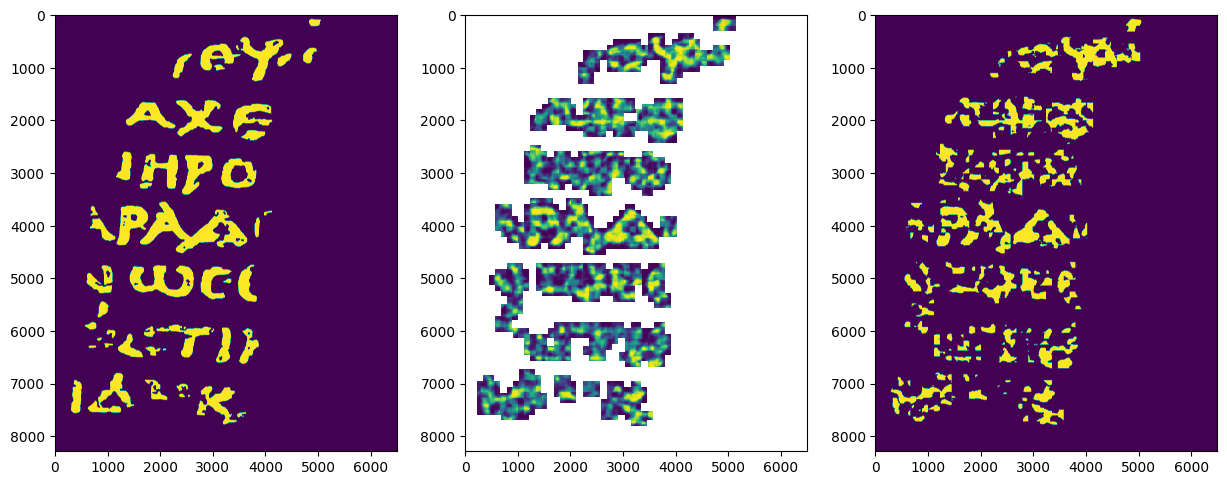

In [38]:
fig, axes = plt.subplots(1, 3, figsize=(15, 8))
axes[0].imshow(valid_mask_gt)
axes[1].imshow(mask_pred_swa)
axes[2].imshow((mask_pred_swa>=best_th).astype(int))

(array([2608614., 1532806., 1065227.,  874568.,  755280.,  685603.,
         642393.,  624255.,  632764.,  598569.,  548068.,  544982.,
         519826.,  468105.,  433042.,  403766.,  390287.,  434004.,
         495269.,  569580.]),
 array([1.60823183e-05, 4.99902398e-02, 9.99643972e-02, 1.49938555e-01,
        1.99912712e-01, 2.49886870e-01, 2.99861027e-01, 3.49835185e-01,
        3.99809342e-01, 4.49783499e-01, 4.99757657e-01, 5.49731814e-01,
        5.99705972e-01, 6.49680129e-01, 6.99654287e-01, 7.49628444e-01,
        7.99602602e-01, 8.49576759e-01, 8.99550917e-01, 9.49525074e-01,
        9.99499232e-01]),
 <BarContainer object of 20 artists>)

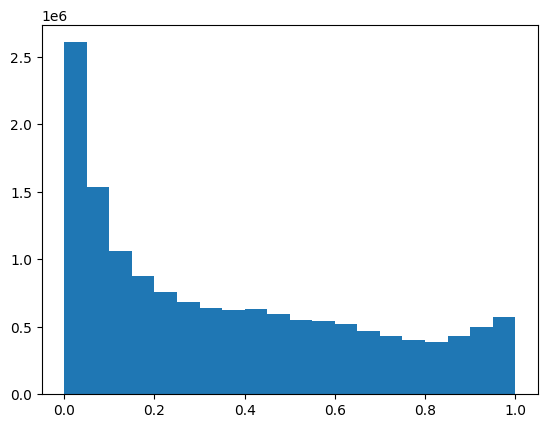

In [39]:
plt.hist(mask_pred_swa.flatten(), bins=20)

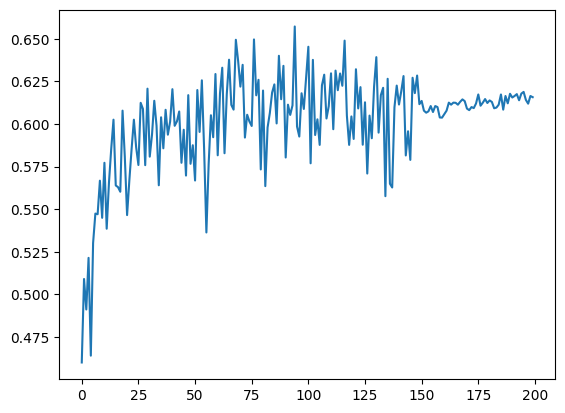

In [1]:
scores=[0.4600,
0.5090,
0.4911,
0.5214,
0.4640,
0.5301,
0.5474,
0.5470,
0.5667,
0.5449,
0.5772,
0.5385,
0.5655,
0.5854,
0.6025,
0.5639,
0.5629,
0.5602,
0.6078,
0.5806,
0.5465,
0.5669,
0.5854,
0.6025,
0.5863,
0.5759,
0.6124,
0.6088,
0.5758,
0.6207,
0.5808,
0.5937,
0.6136,
0.5989,
0.5640,
0.6039,
0.5857,
0.6083,
0.5937,
0.6014,
0.6204,
0.5989,
0.6015,
0.6073,
0.5772,
0.5966,
0.5697,
0.6169,
0.5766,
0.5875,
0.5668,
0.6199,
0.5953,
0.6256,
0.5851,
0.5363,
0.5765,
0.6051,
0.5922,
0.6293,
0.5816,
0.6179,
0.6330,
0.5828,
0.6175,
0.6377,
0.6112,
0.6084,
0.6494,
0.6371,
0.6219,
0.6347,
0.5920,
0.6054,
0.6014,
0.5988,
0.6496,
0.6168,
0.6259,
0.5733,
0.6196,
0.5635,
0.5979,
0.6064,
0.6184,
0.6232,
0.6003,
0.6400,
0.6145,
0.6341,
0.5803,
0.6113,
0.6053,
0.6109,
0.6572,
0.5985,
0.5926,
0.6180,
0.6088,
0.6271,
0.6453,
0.5769,
0.6376,
0.5935,
0.6027,
0.5877,
0.6227,
0.6289,
0.6032,
0.6104,
0.6297,
0.5969,
0.6313,
0.6198,
0.6296,
0.6224,
0.6489,
0.6049,
0.5877,
0.6044,
0.5912,
0.6321,
0.6091,
0.6216,
0.5878,
0.6127,
0.5709,
0.6049,
0.5916,
0.6218,
0.6392,
0.5949,
0.6169,
0.6212,
0.5576,
0.6265,
0.5649,
0.5627,
0.6098,
0.6225,
0.6114,
0.6192,
0.6281,
0.5815,
0.5957,
0.5789,
0.6271,
0.6181,
0.6284,
0.6116,
0.6135,
0.6078,
0.6066,
0.6074,
0.6105,
0.6070,
0.6105,
0.6099,
0.6038,
0.6037,
0.6058,
0.6078,
0.6125,
0.6113,
0.6125,
0.6124,
0.6113,
0.6130,
0.6144,
0.6134,
0.6090,
0.6081,
0.6099,
0.6093,
0.6120,
0.6173,
0.6107,
0.6125,
0.6146,
0.6123,
0.6138,
0.6129,
0.6092,
0.6096,
0.6113,
0.6173,
0.6084,
0.6164,
0.6121,
0.6177,
0.6155,
0.6164,
0.6175,
0.6139,
0.6178,
0.6188,
0.6141,
0.6119,
0.6164,
0.6157]

import matplotlib.pyplot as plt
plt.plot(scores)